In [34]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import timm

import torch.nn.functional as F
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from pathlib import Path
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time

DATASET_PATH = "FF++/"
REAL_PATH = os.path.join(DATASET_PATH, "real")
FAKE_PATH = os.path.join(DATASET_PATH, "fake")

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [36]:
config = {
    'real_dir': 'FF++/real',
    'fake_dir': 'FF++/fake',
    'output_dir': 'output/',
    'eval_dir' : 'FF++/eval_videos/',
    'sample_rate': 1,
    'max_frames': 5000,
    'resize_width': 224,
    'resize_height': 224,
    'limit': None,
    'batch_size': 1024,
    'feature_dim': 20,
    'hidden_dims': [512, 256, 128, 128, 64],
    'dropout_rate': 0.5,
    'learning_rate': 0.001,
    'weight_decay': 1e-5,
    'mixed_precision': True,
    'grad_accum_steps': 4,
    'num_epochs': 1000,
    'patience': 500,
    'val_split': 0.5,
    'test_split': 0.1
}

os.makedirs(config['output_dir'], exist_ok=True)
features_dir = os.path.join(config['output_dir'], 'features')
models_dir = os.path.join(config['output_dir'], 'models')
os.makedirs(features_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

deep_dir = os.path.join(config['output_dir'], 'models/deep')
os.makedirs(deep_dir, exist_ok=True)

vit_dir = os.path.join(config['output_dir'], 'models/vit')
os.makedirs(vit_dir, exist_ok=True)

fine_tuned_vit_dir = os.path.join(config['output_dir'], 'models/fine_tuned_vit')
os.makedirs(fine_tuned_vit_dir, exist_ok=True)

In [37]:
def adaptive_sampling(video_path, sample_rate=3, max_frames=50, resize_shape=(320, 240)):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    duration = total_frames / fps

    if duration < 5:
        sample_rate = max(1, sample_rate // 2)
    else:
        sample_rate = sample_rate

    motion_samples = []
    prev_frame = None

    sample_points = np.linspace(0, total_frames-1, 10, dtype=int)
    for frame_idx in sample_points:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if not ret:
            continue

        frame = cv2.resize(frame, resize_shape)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        if prev_frame is not None:
            diff = cv2.absdiff(frame, prev_frame)
            motion_samples.append(np.mean(diff))

        prev_frame = frame

    cap.release()

    if motion_samples:
        avg_motion = np.mean(motion_samples)
        if avg_motion > 30:
            sample_rate = max(1, sample_rate - 1)
        elif avg_motion < 10:
            sample_rate = sample_rate + 1

    return min(sample_rate, total_frames // max_frames + 1)

In [38]:
def extract_frames(video_path, sample_rate=3, max_frames=50, resize_shape=(320, 240)):
    sample_rate = adaptive_sampling(video_path, sample_rate, max_frames, resize_shape)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video file {video_path}")
        return []

    frames = []
    frame_idx = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_idx % sample_rate == 0:
            frame = cv2.resize(frame, resize_shape)
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames.append(gray)
            if len(frames) >= max_frames:
                break

        frame_idx += 1

    cap.release()
    return frames

In [39]:
def compute_optical_flow(frames):
    if len(frames) < 2:
        return []

    flows = []

    for i in range(len(frames) - 1):
        flow = cv2.calcOpticalFlowFarneback(
            frames[i], frames[i + 1],
            None, 0.5, 3, 15, 3, 5, 1.2, 0
        )
        flows.append(flow)

    return flows

In [40]:
def extract_flow_features(flows):
    if not flows:
        return None

    features = {
        'mag_mean': [],
        'mag_std': [],
        'mag_max': [],
        'dir_std': [],
        'spatial_coherence': [],
        'temporal_consistency': []
    }

    prev_mag = None

    for i, flow in enumerate(flows):
        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

        features['mag_mean'].append(np.mean(mag))
        features['mag_std'].append(np.std(mag))
        features['mag_max'].append(np.max(mag))

        features['dir_std'].append(np.std(ang))
        mag_grad_x = cv2.Sobel(mag, cv2.CV_32F, 1, 0, ksize=3)
        mag_grad_y = cv2.Sobel(mag, cv2.CV_32F, 0, 1, ksize=3)
        spatial_coherence = 1.0 / (1.0 + np.mean(mag_grad_x**2 + mag_grad_y**2))
        features['spatial_coherence'].append(spatial_coherence)
        if prev_mag is not None:
            temp_diff = np.mean(np.abs(mag - prev_mag))
            temp_consistency = 1.0 / (1.0 + temp_diff)
            features['temporal_consistency'].append(temp_consistency)

        prev_mag = mag.copy()

    if len(features['temporal_consistency']) < len(flows) - 1:
        features['temporal_consistency'].append(features['temporal_consistency'][-1] if features['temporal_consistency'] else 0)
    if flows:
        for key in ['mag_mean', 'mag_std', 'mag_max']:
            values = np.array(features[key])
            if len(values) > 0:
                features[f'{key}_trend'] = np.polyfit(np.arange(len(values)), values, 1)[0] if len(values) > 1 else 0
                features[f'{key}_var'] = np.var(values) if len(values) > 1 else 0

        all_mags = np.concatenate([flow_field.reshape(-1, 2) for flow_field in flows], axis=0)
        hist, _ = np.histogramdd(all_mags, bins=10, range=[[-20, 20], [-20, 20]])
        hist = hist / np.sum(hist)
        hist = hist[hist > 0]
        features['flow_entropy'] = -np.sum(hist * np.log2(hist))

    for key in list(features.keys()):
        if isinstance(features[key], list):
            features[key] = np.mean(features[key]) if features[key] else 0

    return features

In [41]:
def process_video(video_path, sample_rate=3, max_frames=50, resize_shape=(320, 240)):
    frames = extract_frames(video_path, sample_rate, max_frames, resize_shape)
    if not frames:
        return None

    flows = compute_optical_flow(frames)
    return extract_flow_features(flows)

In [42]:
def process_videos(video_dir, label, output_dir, sample_rate=3, max_frames=50,
                   resize_width=320, resize_height=240, limit=None):

    os.makedirs(output_dir, exist_ok=True)

    video_paths = list(Path(video_dir).glob('**/*.mp4'))
    video_paths.extend(list(Path(video_dir).glob('**/*.avi')))
    video_paths.extend(list(Path(video_dir).glob('**/*.mov')))

    if limit:
        video_paths = video_paths[:limit]

    features_list = []
    labels = []
    filenames = []

    resize_shape = (resize_width, resize_height)

    for video_path in tqdm(video_paths, desc=f"Processing {label} videos"):
        try:
            features = process_video(str(video_path), sample_rate, max_frames, resize_shape)
            if features:
                features_list.append(features)
                labels.append(label)
                filenames.append(video_path.name)
        except Exception as e:
            print(f"Error processing {video_path}: {e}")

    features_array = []
    feature_names = []

    if features_list:
        feature_names = list(features_list[0].keys())
        features_array = np.zeros((len(features_list), len(feature_names)))
        for i, features in enumerate(features_list):
            for j, name in enumerate(feature_names):
                features_array[i, j] = features[name]

    output_path = os.path.join(output_dir, f"{label}_features.npz")
    np.savez(
        output_path,
        features=features_array,
        labels=np.array(labels),
        filenames=filenames,
        feature_names=feature_names
    )

    print(f"Saved {len(features_list)} {label} video features to {output_path}")

    return features_array, np.array(labels)

In [43]:
class FlowFeatureDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

def load_features(data_dir):
    features_list = []
    labels_list = []

    for filename in os.listdir(data_dir):
        if filename.endswith('_features.npz'):
            data = np.load(os.path.join(data_dir, filename), allow_pickle=True)
            features = data['features']
            labels = data['labels']

            if len(features) > 0:
                features_list.append(features)
                labels_list.append(labels)

    if not features_list:
        return None, None
    features = np.vstack(features_list)
    labels = np.concatenate(labels_list)

    return features, labels

def prepare_dataloaders(data_dir, batch_size=32, val_split=0.2, test_split=0.1, random_state=42):
    features, labels = load_features(data_dir)

    if features is None:
        return None, None, None, None

    train_features, test_features, train_labels, test_labels = train_test_split(
        features, labels, test_size=test_split, random_state=random_state, stratify=labels
    )

    train_features, val_features, train_labels, val_labels = train_test_split(
        train_features, train_labels,
        test_size=val_split / (1 - test_split),
        random_state=random_state,
        stratify=train_labels
    )
    scaler = StandardScaler()
    train_features = scaler.fit_transform(train_features)
    val_features = scaler.transform(val_features)
    test_features = scaler.transform(test_features)

    train_dataset = FlowFeatureDataset(train_features, train_labels)
    val_dataset = FlowFeatureDataset(val_features, val_labels)
    test_dataset = FlowFeatureDataset(test_features, test_labels)

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True
    )
    feature_dim = train_features.shape[1]

    return train_loader, val_loader, test_loader, feature_dim

In [44]:
class DeepFlowClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 256, 128, 128, 64], dropout_rate=0.4):
        super(DeepFlowClassifier, self).__init__()

        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.batch_norm_input = nn.BatchNorm1d(hidden_dims[0])

        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i + 1]))
            self.batch_norms.append(nn.BatchNorm1d(hidden_dims[i + 1]))

        self.output_layer = nn.Linear(hidden_dims[-1], 2)
        self.dropout = nn.Dropout(dropout_rate)

        self.residual_adaptations = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            if hidden_dims[i] != hidden_dims[i + 1]:
                self.residual_adaptations.append(nn.Linear(hidden_dims[i], hidden_dims[i + 1]))
            else:
                self.residual_adaptations.append(None)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.batch_norm_input(x)
        x = F.relu(x)
        x = self.dropout(x)
        for i, (layer, bn) in enumerate(zip(self.layers, self.batch_norms)):
            identity = x
            x = layer(x)
            x = bn(x)
            x = F.relu(x)
            if self.residual_adaptations[i] is not None:
                identity = self.residual_adaptations[i](identity)

            x = x + identity
            x = self.dropout(x)
        x = self.output_layer(x)

        return x

def create_deep_flow_classifier(input_dim, hidden_dims=[128, 64, 32], dropout_rate=0.4):
    model = DeepFlowClassifier(
        input_dim=input_dim,
        hidden_dims=hidden_dims,
        dropout_rate=dropout_rate
    )

    print(f"Created DeepFlowClassifier with {sum(p.numel() for p in model.parameters())} parameters")
    return model

In [45]:
def train_epoch(model, train_loader, optimizer, criterion, device,
               mixed_precision=True, gradient_accumulation_steps=1):
    model.train()
    total_loss = 0.0

    scaler = GradScaler() if mixed_precision else None

    pbar = tqdm(total=len(train_loader), desc="Training")

    optimizer.zero_grad()

    for i, (features, labels) in enumerate(train_loader):
        features = features.to(device)
        labels = labels.to(device)

        with autocast(enabled=mixed_precision):
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss = loss / gradient_accumulation_steps

        if mixed_precision:
            scaler.scale(loss).backward()
        else:
            loss.backward()

        if (i + 1) % gradient_accumulation_steps == 0 or (i + 1) == len(train_loader):
            if mixed_precision:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()

            optimizer.zero_grad()

        total_loss += loss.item() * gradient_accumulation_steps

        pbar.update(1)
        pbar.set_postfix({'loss': total_loss / (i + 1)})

    pbar.close()

    return total_loss / len(train_loader)

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for features, labels in val_loader:
            features = features.to(device)
            labels = labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')

    return total_loss / len(val_loader), accuracy, precision, recall, f1

In [46]:
def test(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for features, labels in test_loader:
            features = features.to(device)
            labels = labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    cm = confusion_matrix(all_labels, all_preds)

    return total_loss / len(test_loader), accuracy, precision, recall, f1, cm


In [47]:
def train_model(model, train_loader, val_loader, test_loader, config, save_dir='models', device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = model.to(device)
    os.makedirs(save_dir, exist_ok=True)
    optimizer = optim.Adam(
        model.parameters(),
        lr=config['learning_rate'],
        weight_decay=config['weight_decay']
    )
    criterion = nn.CrossEntropyLoss()

    scheduler = ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=5, verbose=True
    )

    best_val_f1 = 0.0
    best_epoch = 0
    patience_counter = 0
    train_losses = []
    val_losses = []
    val_accuracies = []
    val_f1_scores = []
    best_model_state = None

    for epoch in range(config['num_epochs']):
        start_time = time.time()

        train_loss = train_epoch(
            model, train_loader, optimizer, criterion, device,
            mixed_precision=config['mixed_precision'],
            gradient_accumulation_steps=config['grad_accum_steps']
        )

        val_loss, val_accuracy, val_precision, val_recall, val_f1 = validate(
            model, val_loader, criterion, device
        )

        scheduler.step(val_f1)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_f1_scores.append(val_f1)
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_epoch = epoch
            patience_counter = 0
            best_model_state = model.state_dict()
            torch.save(best_model_state, os.path.join(save_dir, 'best_model.pt'))
        else:
            patience_counter += 1

        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{config['num_epochs']}, Time: {epoch_time:.2f}s")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}")
        print(f"Best Val F1: {best_val_f1:.4f} (Epoch {best_epoch+1})")
        print(f"Patience: {patience_counter}/{config['patience']}")
        print("-" * 50)

        if patience_counter >= config['patience']:
            print(f"Early stopping after {epoch+1} epochs")
            break
    model.load_state_dict(best_model_state)

    if test_loader is not None:
        test_loss, test_accuracy, test_precision, test_recall, test_f1, cm = test(
            model, test_loader, criterion, device
        )
        print("Test Results:")
        print(f"Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")
        print(f"Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")
        print("Confusion Matrix:")
        print(cm)

    plot_training_curves(train_losses, val_losses, val_accuracies, val_f1_scores, save_dir)
    return best_val_f1, model

In [48]:
def plot_training_curves(train_losses, val_losses, val_accuracies, val_f1_scores, save_dir):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.title('Training and Validation Loss')
    plt.subplot(2, 1, 2)
    plt.plot(val_accuracies, label='Accuracy')
    plt.plot(val_f1_scores, label='F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('Metric')

    plt.legend()
    plt.grid(True)
    plt.title('Validation Metrics')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'training_curves.png'))
    plt.close()



In [49]:
def predict_video(video_path, model, device, sample_rate=3, max_frames=50, resize_shape=(320, 240)):
    features = process_video(video_path, sample_rate, max_frames, resize_shape)

    if features is None:
        print(f"Error processing video: {video_path}")
        return None, None

    features_tensor = torch.FloatTensor([list(features.values())]).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(features_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        prediction = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0, prediction].item()

    return prediction, confidence

In [50]:
def predict_videos(video_dir, model, device, output_csv=None, sample_rate=3, max_frames=50,
                  resize_width=320, resize_height=240):

    video_paths = list(Path(video_dir).glob('**/*.mp4'))
    video_paths.extend(list(Path(video_dir).glob('**/*.avi')))
    video_paths.extend(list(Path(video_dir).glob('**/*.mov')))

    results = []

    resize_shape = (resize_width, resize_height)
    for video_path in tqdm(video_paths, desc="Predicting"):
        try:
            prediction, confidence = predict_video(
                str(video_path), model, device, sample_rate, max_frames, resize_shape
            )

            if prediction is not None:
                results.append({
                    'video': video_path.name,
                    'prediction': 'real' if prediction == 1 else 'fake',
                    'confidence': confidence
                })
        except Exception as e:
            print(f"Error processing {video_path}: {e}")

    results_df = pd.DataFrame(results)

    if output_csv is not None:
        results_df.to_csv(output_csv, index=False)
        print(f"Results saved to {output_csv}")

    if results:
        real_count = sum(1 for result in results if result['prediction'] == 'real')
        fake_count = sum(1 for result in results if result['prediction'] == 'fake')
        total_count = len(results)

        print(f"Summary: {total_count} videos processed")
        print(f"Real: {real_count} ({real_count / total_count * 100:.1f}%)")
        print(f"Fake: {fake_count} ({fake_count / total_count * 100:.1f}%)")
    else:
        print("No videos processed successfully.")

    return results_df

def visualize_results(results_df, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    plt.figure(figsize=(10, 6))
    sns.countplot(x='prediction', data=results_df)
    plt.title('Prediction Counts')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'prediction_counts.png'))

    plt.figure(figsize=(10, 6))
    sns.histplot(data=results_df, x='confidence', hue='prediction', bins=20, kde=True)
    plt.title('Confidence Distribution')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'confidence_distribution.png'))

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='prediction', y='confidence', data=results_df)
    plt.title('Confidence by Prediction')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'confidence_by_prediction.png'))

In [51]:
class ViTClassifier(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        super().__init__()
        
        # Create a small ViT model
        self.vit = timm.create_model(
            'vit_base_patch16_224',  # pretrained ViT model
            pretrained=True,
            num_classes=0  # No final classification head
        )
        
        # Freeze ViT encoder if needed (optional)
        for param in self.vit.parameters():
            param.requires_grad = True  # Set False if you want to freeze

        # Project feature vectors to match ViT expected shape
        self.input_proj = nn.Linear(input_dim, 768)  # vit_base_patch16 has 768 hidden dim

        # Classifier
        self.fc = nn.Linear(768, num_classes)

    def forward(self, x):
        # x shape: (batch_size, feature_dim)

        x = self.input_proj(x)  # (batch_size, 768)
        B = x.shape[0]
        x = x.unsqueeze(1)  # (B, 1, 768) — treat as 1 patch

        # Add positional embedding manually
        cls_token = self.vit.cls_token.expand(B, -1, -1)  # (B, 1, 768)
        x = torch.cat((cls_token, x), dim=1)  # (B, 2, 768)
        x = x + self.vit.pos_embed[:, :x.size(1), :]  # Add positional encoding

        # Pass through Transformer encoder
        x = self.vit.blocks(x)
        x = self.vit.norm(x)

        # Take [CLS] token output
        cls_output = x[:, 0]  # (B, 768)

        out = self.fc(cls_output)  # Final classification
        return out

In [52]:
class FineTunedViTClassifier(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        super().__init__()
        
        self.vit = timm.create_model(
            'vit_base_patch16_224',
            pretrained=True,
            num_classes=0
        )
        
        for name, param in self.vit.named_parameters():
            if any(f'blocks.{i}.' in name for i in [8, 9, 10, 11]) or 'norm' in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        self.input_proj = nn.Linear(input_dim, 768)
        self.pre_classifier_norm = nn.LayerNorm(768)
        self.fc = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.input_proj(x)
        B = x.size(0)
        x = x.unsqueeze(1)

        cls_token = self.vit.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)

        x = self.vit.blocks(x)
        x = self.vit.norm(x)

        cls_output = x[:, 0]
        cls_output = self.pre_classifier_norm(cls_output)

        out = self.fc(cls_output)
        return out

In [53]:
def prepare_features(config):
    os.makedirs(config['output_dir'], exist_ok=True)
    features_dir = os.path.join(config['output_dir'], 'features')
    os.makedirs(features_dir, exist_ok=True)

    real_features_path = os.path.join(features_dir, '1_features.npz')
    fake_features_path = os.path.join(features_dir, '0_features.npz')

    if not (os.path.exists(real_features_path) and os.path.exists(fake_features_path)):
        print("Processing videos...")

        print("Processing real videos...")
        real_features, real_labels = process_videos(
            config['real_dir'], 1, features_dir,
            sample_rate=config['sample_rate'],
            max_frames=config['max_frames'],
            resize_width=config['resize_width'],
            resize_height=config['resize_height'],
            limit=config['limit']
        )

        print("Processing fake videos...")
        fake_features, fake_labels = process_videos(
            config['fake_dir'], 0, features_dir,
            sample_rate=config['sample_rate'],
            max_frames=config['max_frames'],
            resize_width=config['resize_width'],
            resize_height=config['resize_height'],
            limit=config['limit']
        )

        print("Video processing complete!")
    else:
        print("Using existing features...")

In [54]:
prepare_features(config)

Using existing features...


In [55]:
def run_model(config, model_type="fine_tuned_vit"):
    features_dir = os.path.join(config['output_dir'], 'features')
    models_dir = os.path.join(config['output_dir'], 'models', model_type)
    os.makedirs(models_dir, exist_ok=True)

    print("Preparing dataloaders...")
    train_loader, val_loader, test_loader, feature_dim = prepare_dataloaders(
        features_dir,
        batch_size=config['batch_size'],
        val_split=config['val_split'],
        test_split=config['test_split']
    )

    if train_loader is None:
        print("Error: No features found.")
        return None

    print(f"Feature dimension: {feature_dim}")
    config['feature_dim'] = feature_dim

    print(f"Initializing {model_type} model...")
    if model_type == 'deep':
        model = create_deep_flow_classifier(
            input_dim=feature_dim,
            hidden_dims=config['hidden_dims'],
            dropout_rate=config['dropout_rate']
        )
    elif model_type == 'vit':
        model = ViTClassifier(
            input_dim=feature_dim,
            num_classes=2
        )
    elif model_type == 'fine_tuned_vit': 
        model = FineTunedViTClassifier(
            input_dim=feature_dim,
            num_classes=2
        )

    print("Training model...")
    best_val_f1, model = train_model(
        model, train_loader, val_loader, test_loader, config,
        save_dir=models_dir, device=device
    )

    # Save configuration for this model
    with open(os.path.join(models_dir, 'config.json'), 'w') as f:
        json.dump(config, f, indent=4)

    print(f"Training complete for {model_type}! Best validation F1 score: {best_val_f1:.4f}")
    return model

In [56]:
print('Deep CNN')
deep_model = run_model(config, 'deep')

C:\Users\ishan\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Deep CNN
Preparing dataloaders...
Feature dimension: 13
Initializing deep model...
Created DeepFlowClassifier with 370946 parameters
Training model...


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.59it/s, loss=0.854]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 1/1000, Time: 0.04s
Train Loss: 0.8539
Val Loss: 0.6958, Accuracy: 0.5000, F1: 0.4505
Best Val F1: 0.4505 (Epoch 1)
Patience: 0/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 28.95it/s, loss=0.824]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 2/1000, Time: 0.05s
Train Loss: 0.8244
Val Loss: 0.6971, Accuracy: 0.5000, F1: 0.0385
Best Val F1: 0.4505 (Epoch 1)
Patience: 1/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 57.08it/s, loss=0.873]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 3/1000, Time: 0.03s
Train Loss: 0.8728
Val Loss: 0.6997, Accuracy: 0.5100, F1: 0.0392
Best Val F1: 0.4505 (Epoch 1)
Patience: 2/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 51.21it/s, loss=0.965]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 4/1000, Time: 0.03s
Train Loss: 0.9652
Val Loss: 0.7020, Accuracy: 0.5150, F1: 0.1983
Best Val F1: 0.4505 (Epoch 1)
Patience: 3/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.51it/s, loss=0.749]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 5/1000, Time: 0.03s
Train Loss: 0.7493
Val Loss: 0.7033, Accuracy: 0.5250, F1: 0.4172
Best Val F1: 0.4505 (Epoch 1)
Patience: 4/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 51.24it/s, loss=0.738]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 6/1000, Time: 0.04s
Train Loss: 0.7382
Val Loss: 0.7032, Accuracy: 0.5350, F1: 0.5181
Best Val F1: 0.5181 (Epoch 6)
Patience: 0/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.52it/s, loss=0.892]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 7/1000, Time: 0.03s
Train Loss: 0.8922
Val Loss: 0.7021, Accuracy: 0.5450, F1: 0.5646
Best Val F1: 0.5646 (Epoch 7)
Patience: 0/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.51it/s, loss=0.739]


Epoch 8/1000, Time: 0.03s
Train Loss: 0.7386
Val Loss: 0.7021, Accuracy: 0.5600, F1: 0.6140
Best Val F1: 0.6140 (Epoch 8)
Patience: 0/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 57.12it/s, loss=0.879]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 9/1000, Time: 0.03s
Train Loss: 0.8789
Val Loss: 0.7032, Accuracy: 0.5250, F1: 0.6091
Best Val F1: 0.6140 (Epoch 8)
Patience: 1/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 57.11it/s, loss=0.856]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 10/1000, Time: 0.03s
Train Loss: 0.8561
Val Loss: 0.7056, Accuracy: 0.5100, F1: 0.6080
Best Val F1: 0.6140 (Epoch 8)
Patience: 2/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 57.07it/s, loss=0.8]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 11/1000, Time: 0.03s
Train Loss: 0.7995
Val Loss: 0.7087, Accuracy: 0.5050, F1: 0.6087
Best Val F1: 0.6140 (Epoch 8)
Patience: 3/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 51.19it/s, loss=0.817]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 12/1000, Time: 0.03s
Train Loss: 0.8171
Val Loss: 0.7119, Accuracy: 0.4950, F1: 0.6070
Best Val F1: 0.6140 (Epoch 8)
Patience: 4/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.57it/s, loss=0.787]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 13/1000, Time: 0.03s
Train Loss: 0.7869
Val Loss: 0.7151, Accuracy: 0.4950, F1: 0.6070
Best Val F1: 0.6140 (Epoch 8)
Patience: 5/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.59it/s, loss=0.755]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 14/1000, Time: 0.03s
Train Loss: 0.7555
Val Loss: 0.7176, Accuracy: 0.5000, F1: 0.6094
Best Val F1: 0.6140 (Epoch 8)
Patience: 6/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 53.99it/s, loss=0.729]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 15/1000, Time: 0.03s
Train Loss: 0.7291
Val Loss: 0.7190, Accuracy: 0.5000, F1: 0.6094
Best Val F1: 0.6140 (Epoch 8)
Patience: 7/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.55it/s, loss=0.803]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 16/1000, Time: 0.03s
Train Loss: 0.8026
Val Loss: 0.7207, Accuracy: 0.5000, F1: 0.6094
Best Val F1: 0.6140 (Epoch 8)
Patience: 8/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.59it/s, loss=0.793]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 17/1000, Time: 0.03s
Train Loss: 0.7935
Val Loss: 0.7225, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 9/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.51it/s, loss=0.793]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 18/1000, Time: 0.03s
Train Loss: 0.7929
Val Loss: 0.7245, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 10/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 54.46it/s, loss=0.731]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 19/1000, Time: 0.03s
Train Loss: 0.7312
Val Loss: 0.7258, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 11/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.59it/s, loss=0.709]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 20/1000, Time: 0.04s
Train Loss: 0.7085
Val Loss: 0.7271, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 12/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.43it/s, loss=0.739]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 21/1000, Time: 0.03s
Train Loss: 0.7388
Val Loss: 0.7288, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 13/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.07it/s, loss=0.76]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 22/1000, Time: 0.03s
Train Loss: 0.7600
Val Loss: 0.7297, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 14/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.57it/s, loss=0.844]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 23/1000, Time: 0.03s
Train Loss: 0.8436
Val Loss: 0.7311, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 15/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 40.79it/s, loss=0.8]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 24/1000, Time: 0.04s
Train Loss: 0.7996
Val Loss: 0.7318, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 16/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 38.28it/s, loss=0.736]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 25/1000, Time: 0.04s
Train Loss: 0.7357
Val Loss: 0.7331, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 17/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 54.00it/s, loss=0.715]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 26/1000, Time: 0.03s
Train Loss: 0.7145
Val Loss: 0.7341, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 18/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 45.38it/s, loss=0.698]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 27/1000, Time: 0.04s
Train Loss: 0.6977
Val Loss: 0.7352, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 19/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 43.45it/s, loss=0.753]

Epoch 28/1000, Time: 0.04s
Train Loss: 0.7529
Val Loss: 0.7358, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 20/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 45.38it/s, loss=0.681]

Epoch 29/1000, Time: 0.04s
Train Loss: 0.6805
Val Loss: 0.7364, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 21/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.51it/s, loss=0.753]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 30/1000, Time: 0.03s
Train Loss: 0.7529
Val Loss: 0.7369, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 22/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 40.77it/s, loss=0.777]


Epoch 31/1000, Time: 0.04s
Train Loss: 0.7774
Val Loss: 0.7374, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 23/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.60it/s, loss=0.77]

Epoch 32/1000, Time: 0.03s
Train Loss: 0.7696
Val Loss: 0.7378, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 24/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.52it/s, loss=0.742]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 33/1000, Time: 0.03s
Train Loss: 0.7420
Val Loss: 0.7386, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 25/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.91it/s, loss=0.837]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 34/1000, Time: 0.03s
Train Loss: 0.8367
Val Loss: 0.7391, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 26/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 58.26it/s, loss=0.702]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 35/1000, Time: 0.03s
Train Loss: 0.7016
Val Loss: 0.7394, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 27/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 44.33it/s, loss=0.665]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 36/1000, Time: 0.03s
Train Loss: 0.6650
Val Loss: 0.7401, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 28/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 42.50it/s, loss=0.794]


Epoch 37/1000, Time: 0.04s
Train Loss: 0.7936
Val Loss: 0.7408, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 29/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 46.45it/s, loss=0.716]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 38/1000, Time: 0.03s
Train Loss: 0.7157
Val Loss: 0.7408, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 30/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.95it/s, loss=0.835]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 39/1000, Time: 0.03s
Train Loss: 0.8349
Val Loss: 0.7410, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 31/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 57.08it/s, loss=0.734]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 40/1000, Time: 0.03s
Train Loss: 0.7343
Val Loss: 0.7413, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 32/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 57.08it/s, loss=0.714]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 41/1000, Time: 0.03s
Train Loss: 0.7137
Val Loss: 0.7418, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 33/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.49it/s, loss=0.713]


Epoch 42/1000, Time: 0.03s
Train Loss: 0.7127
Val Loss: 0.7423, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 34/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 50.82it/s, loss=0.808]


Epoch 43/1000, Time: 0.03s
Train Loss: 0.8076
Val Loss: 0.7422, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 35/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 54.00it/s, loss=0.807]


Epoch 44/1000, Time: 0.03s
Train Loss: 0.8070
Val Loss: 0.7420, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 36/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 57.09it/s, loss=0.791]

Epoch 45/1000, Time: 0.03s
Train Loss: 0.7910
Val Loss: 0.7422, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 37/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 54.01it/s, loss=0.691]


Epoch 46/1000, Time: 0.03s
Train Loss: 0.6911
Val Loss: 0.7424, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 38/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.47it/s, loss=0.759]


Epoch 47/1000, Time: 0.03s
Train Loss: 0.7586
Val Loss: 0.7420, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 39/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 51.24it/s, loss=0.731]


Epoch 48/1000, Time: 0.03s
Train Loss: 0.7305
Val Loss: 0.7417, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 40/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.95it/s, loss=0.682]

Epoch 49/1000, Time: 0.03s
Train Loss: 0.6815
Val Loss: 0.7417, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 41/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 51.26it/s, loss=0.782]

Epoch 50/1000, Time: 0.03s
Train Loss: 0.7822
Val Loss: 0.7419, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 42/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 43.44it/s, loss=0.731]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 51/1000, Time: 0.04s
Train Loss: 0.7312
Val Loss: 0.7421, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 43/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 46.46it/s, loss=0.796]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 52/1000, Time: 0.04s
Train Loss: 0.7961
Val Loss: 0.7420, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 44/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 53.41it/s, loss=0.75]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 53/1000, Time: 0.03s
Train Loss: 0.7498
Val Loss: 0.7421, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 45/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.56it/s, loss=0.797]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 54/1000, Time: 0.03s
Train Loss: 0.7968
Val Loss: 0.7425, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 46/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.58it/s, loss=0.841]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 55/1000, Time: 0.04s
Train Loss: 0.8408
Val Loss: 0.7426, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 47/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.73it/s, loss=0.744]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 56/1000, Time: 0.03s
Train Loss: 0.7435
Val Loss: 0.7432, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 48/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.45it/s, loss=0.747]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 57/1000, Time: 0.03s
Train Loss: 0.7472
Val Loss: 0.7432, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 49/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 53.98it/s, loss=0.801]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 58/1000, Time: 0.03s
Train Loss: 0.8015
Val Loss: 0.7432, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 50/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.58it/s, loss=0.7]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 59/1000, Time: 0.03s
Train Loss: 0.6996
Val Loss: 0.7431, Accuracy: 0.4900, F1: 0.6016
Best Val F1: 0.6140 (Epoch 8)
Patience: 51/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 50.89it/s, loss=0.729]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 60/1000, Time: 0.03s
Train Loss: 0.7294
Val Loss: 0.7428, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 52/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.26it/s, loss=0.865]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 61/1000, Time: 0.03s
Train Loss: 0.8646
Val Loss: 0.7428, Accuracy: 0.5000, F1: 0.6094
Best Val F1: 0.6140 (Epoch 8)
Patience: 53/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 54.04it/s, loss=0.724]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 62/1000, Time: 0.03s
Train Loss: 0.7239
Val Loss: 0.7432, Accuracy: 0.5000, F1: 0.6094
Best Val F1: 0.6140 (Epoch 8)
Patience: 54/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 45.42it/s, loss=0.713]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 63/1000, Time: 0.03s
Train Loss: 0.7132
Val Loss: 0.7431, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 55/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 46.44it/s, loss=0.786]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 64/1000, Time: 0.04s
Train Loss: 0.7858
Val Loss: 0.7432, Accuracy: 0.5000, F1: 0.6094
Best Val F1: 0.6140 (Epoch 8)
Patience: 56/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 57.06it/s, loss=0.689]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 65/1000, Time: 0.03s
Train Loss: 0.6892
Val Loss: 0.7431, Accuracy: 0.5000, F1: 0.6094
Best Val F1: 0.6140 (Epoch 8)
Patience: 57/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.49it/s, loss=0.723]

Epoch 66/1000, Time: 0.03s
Train Loss: 0.7228
Val Loss: 0.7434, Accuracy: 0.5000, F1: 0.6094
Best Val F1: 0.6140 (Epoch 8)
Patience: 58/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 57.08it/s, loss=0.769]

Epoch 67/1000, Time: 0.03s
Train Loss: 0.7686
Val Loss: 0.7436, Accuracy: 0.5000, F1: 0.6094
Best Val F1: 0.6140 (Epoch 8)
Patience: 59/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 44.39it/s, loss=0.699]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 68/1000, Time: 0.04s
Train Loss: 0.6992
Val Loss: 0.7437, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 60/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 44.37it/s, loss=0.757]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 69/1000, Time: 0.04s
Train Loss: 0.7571
Val Loss: 0.7437, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 61/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.88it/s, loss=0.745]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 70/1000, Time: 0.03s
Train Loss: 0.7451
Val Loss: 0.7438, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 62/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 43.39it/s, loss=0.818]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 71/1000, Time: 0.04s
Train Loss: 0.8180
Val Loss: 0.7435, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 63/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 60.55it/s, loss=0.739]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 72/1000, Time: 0.03s
Train Loss: 0.7391
Val Loss: 0.7437, Accuracy: 0.5000, F1: 0.6063
Best Val F1: 0.6140 (Epoch 8)
Patience: 64/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 45.39it/s, loss=0.713]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 73/1000, Time: 0.03s
Train Loss: 0.7128
Val Loss: 0.7435, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 65/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 53.97it/s, loss=0.707]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 74/1000, Time: 0.03s
Train Loss: 0.7070
Val Loss: 0.7435, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 66/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.52it/s, loss=0.762]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 75/1000, Time: 0.03s
Train Loss: 0.7622
Val Loss: 0.7432, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 67/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 57.07it/s, loss=0.751]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 76/1000, Time: 0.03s
Train Loss: 0.7511
Val Loss: 0.7434, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 68/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.51it/s, loss=0.683]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 77/1000, Time: 0.03s
Train Loss: 0.6827
Val Loss: 0.7437, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 69/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.58it/s, loss=0.795]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 78/1000, Time: 0.03s
Train Loss: 0.7949
Val Loss: 0.7433, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 70/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.30it/s, loss=0.79]

Epoch 79/1000, Time: 0.03s
Train Loss: 0.7898
Val Loss: 0.7437, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 71/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 54.00it/s, loss=0.734]

Epoch 80/1000, Time: 0.03s
Train Loss: 0.7343
Val Loss: 0.7439, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 72/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 54.00it/s, loss=0.7]

Epoch 81/1000, Time: 0.03s
Train Loss: 0.7001
Val Loss: 0.7439, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 73/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.48it/s, loss=0.759]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 82/1000, Time: 0.03s
Train Loss: 0.7591
Val Loss: 0.7442, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 74/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 60.57it/s, loss=0.755]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 83/1000, Time: 0.03s
Train Loss: 0.7545
Val Loss: 0.7439, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 75/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.60it/s, loss=0.755]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 84/1000, Time: 0.03s
Train Loss: 0.7546
Val Loss: 0.7441, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 76/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 51.24it/s, loss=0.778]


Epoch 85/1000, Time: 0.03s
Train Loss: 0.7778
Val Loss: 0.7442, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 77/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.50it/s, loss=0.635]


Epoch 86/1000, Time: 0.04s
Train Loss: 0.6346
Val Loss: 0.7441, Accuracy: 0.5000, F1: 0.6063
Best Val F1: 0.6140 (Epoch 8)
Patience: 78/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.70it/s, loss=0.822]

Epoch 87/1000, Time: 0.03s
Train Loss: 0.8216
Val Loss: 0.7441, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 79/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.57it/s, loss=0.763]


Epoch 88/1000, Time: 0.03s
Train Loss: 0.7627
Val Loss: 0.7440, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 80/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.33it/s, loss=0.755]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 89/1000, Time: 0.04s
Train Loss: 0.7550
Val Loss: 0.7442, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 81/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.74it/s, loss=0.68]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 90/1000, Time: 0.03s
Train Loss: 0.6804
Val Loss: 0.7438, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 82/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 51.22it/s, loss=0.67]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 91/1000, Time: 0.03s
Train Loss: 0.6704
Val Loss: 0.7439, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 83/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.60it/s, loss=0.711]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 92/1000, Time: 0.03s
Train Loss: 0.7111
Val Loss: 0.7437, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 84/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 46.45it/s, loss=0.703]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 93/1000, Time: 0.04s
Train Loss: 0.7034
Val Loss: 0.7438, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 85/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.96it/s, loss=0.752]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 94/1000, Time: 0.03s
Train Loss: 0.7523
Val Loss: 0.7432, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 86/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.53it/s, loss=0.8]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 95/1000, Time: 0.03s
Train Loss: 0.7997
Val Loss: 0.7430, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 87/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 51.23it/s, loss=0.688]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 96/1000, Time: 0.03s
Train Loss: 0.6882
Val Loss: 0.7434, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 88/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.47it/s, loss=0.733]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 97/1000, Time: 0.03s
Train Loss: 0.7330
Val Loss: 0.7432, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 89/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.57it/s, loss=0.776]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 98/1000, Time: 0.03s
Train Loss: 0.7755
Val Loss: 0.7430, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 90/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.59it/s, loss=0.763]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 99/1000, Time: 0.03s
Train Loss: 0.7631
Val Loss: 0.7432, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 91/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.73it/s, loss=0.666]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 100/1000, Time: 0.03s
Train Loss: 0.6660
Val Loss: 0.7431, Accuracy: 0.5000, F1: 0.6063
Best Val F1: 0.6140 (Epoch 8)
Patience: 92/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 44.41it/s, loss=0.751]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 101/1000, Time: 0.03s
Train Loss: 0.7509
Val Loss: 0.7433, Accuracy: 0.5000, F1: 0.6063
Best Val F1: 0.6140 (Epoch 8)
Patience: 93/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.71it/s, loss=0.702]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 102/1000, Time: 0.03s
Train Loss: 0.7018
Val Loss: 0.7434, Accuracy: 0.5000, F1: 0.6063
Best Val F1: 0.6140 (Epoch 8)
Patience: 94/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.92it/s, loss=0.799]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 103/1000, Time: 0.03s
Train Loss: 0.7994
Val Loss: 0.7433, Accuracy: 0.5000, F1: 0.6063
Best Val F1: 0.6140 (Epoch 8)
Patience: 95/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.79it/s, loss=0.804]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 104/1000, Time: 0.03s
Train Loss: 0.8037
Val Loss: 0.7428, Accuracy: 0.5000, F1: 0.6063
Best Val F1: 0.6140 (Epoch 8)
Patience: 96/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 54.00it/s, loss=0.734]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 105/1000, Time: 0.03s
Train Loss: 0.7343
Val Loss: 0.7424, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 97/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s, loss=0.747]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 106/1000, Time: 0.03s
Train Loss: 0.7470
Val Loss: 0.7421, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 98/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 53.94it/s, loss=0.785]


Epoch 107/1000, Time: 0.03s
Train Loss: 0.7853
Val Loss: 0.7425, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 99/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 56.12it/s, loss=0.71]


Epoch 108/1000, Time: 0.03s
Train Loss: 0.7095
Val Loss: 0.7421, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 100/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 46.44it/s, loss=0.761]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 109/1000, Time: 0.04s
Train Loss: 0.7611
Val Loss: 0.7423, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 101/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 40.74it/s, loss=0.682]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 110/1000, Time: 0.04s
Train Loss: 0.6815
Val Loss: 0.7426, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 102/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 42.46it/s, loss=0.766]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 111/1000, Time: 0.03s
Train Loss: 0.7655
Val Loss: 0.7429, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 103/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 40.75it/s, loss=0.845]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 112/1000, Time: 0.04s
Train Loss: 0.8450
Val Loss: 0.7431, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 104/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.69it/s, loss=0.753]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 113/1000, Time: 0.03s
Train Loss: 0.7529
Val Loss: 0.7432, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 105/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.50it/s, loss=0.7]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 114/1000, Time: 0.03s
Train Loss: 0.7003
Val Loss: 0.7428, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 106/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 56.10it/s, loss=0.799]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 115/1000, Time: 0.03s
Train Loss: 0.7991
Val Loss: 0.7428, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 107/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.47it/s, loss=0.757]


Epoch 116/1000, Time: 0.03s
Train Loss: 0.7574
Val Loss: 0.7433, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 108/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.56it/s, loss=0.844]


Epoch 117/1000, Time: 0.03s
Train Loss: 0.8445
Val Loss: 0.7435, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 109/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 39.20it/s, loss=0.72]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 118/1000, Time: 0.04s
Train Loss: 0.7197
Val Loss: 0.7437, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 110/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 35.38it/s, loss=0.769]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 119/1000, Time: 0.05s
Train Loss: 0.7685
Val Loss: 0.7439, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 111/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 42.80it/s, loss=0.695]


Epoch 120/1000, Time: 0.04s
Train Loss: 0.6954
Val Loss: 0.7442, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 112/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 45.41it/s, loss=0.764]


Epoch 121/1000, Time: 0.04s
Train Loss: 0.7640
Val Loss: 0.7441, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 113/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.61it/s, loss=0.756]


Epoch 122/1000, Time: 0.03s
Train Loss: 0.7561
Val Loss: 0.7444, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 114/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s, loss=0.745]

Epoch 123/1000, Time: 0.03s
Train Loss: 0.7451
Val Loss: 0.7441, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 115/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 46.47it/s, loss=0.713]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 124/1000, Time: 0.04s
Train Loss: 0.7132
Val Loss: 0.7447, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 116/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 39.21it/s, loss=0.78]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 125/1000, Time: 0.04s
Train Loss: 0.7799
Val Loss: 0.7450, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 117/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.56it/s, loss=0.753]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 126/1000, Time: 0.04s
Train Loss: 0.7530
Val Loss: 0.7448, Accuracy: 0.4900, F1: 0.6016
Best Val F1: 0.6140 (Epoch 8)
Patience: 118/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 44.34it/s, loss=0.851]


Epoch 127/1000, Time: 0.04s
Train Loss: 0.8506
Val Loss: 0.7447, Accuracy: 0.4900, F1: 0.6016
Best Val F1: 0.6140 (Epoch 8)
Patience: 119/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 44.41it/s, loss=0.748]


Epoch 128/1000, Time: 0.04s
Train Loss: 0.7478
Val Loss: 0.7450, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 120/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.74it/s, loss=0.739]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 129/1000, Time: 0.03s
Train Loss: 0.7389
Val Loss: 0.7447, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 121/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.74it/s, loss=0.736]


Epoch 130/1000, Time: 0.03s
Train Loss: 0.7362
Val Loss: 0.7448, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 122/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.55it/s, loss=0.713]


Epoch 131/1000, Time: 0.03s
Train Loss: 0.7126
Val Loss: 0.7450, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 123/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 54.00it/s, loss=0.727]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 132/1000, Time: 0.03s
Train Loss: 0.7272
Val Loss: 0.7450, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 124/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.72it/s, loss=0.761]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 133/1000, Time: 0.03s
Train Loss: 0.7609
Val Loss: 0.7448, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 125/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.58it/s, loss=0.695]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 134/1000, Time: 0.03s
Train Loss: 0.6946
Val Loss: 0.7450, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 126/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 45.34it/s, loss=0.721]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 135/1000, Time: 0.04s
Train Loss: 0.7213
Val Loss: 0.7448, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 127/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.58it/s, loss=0.721]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 136/1000, Time: 0.03s
Train Loss: 0.7208
Val Loss: 0.7445, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 128/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.56it/s, loss=0.721]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 137/1000, Time: 0.03s
Train Loss: 0.7211
Val Loss: 0.7443, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 129/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 57.09it/s, loss=0.728]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 138/1000, Time: 0.03s
Train Loss: 0.7281
Val Loss: 0.7447, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 130/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.54it/s, loss=0.81]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 139/1000, Time: 0.03s
Train Loss: 0.8096
Val Loss: 0.7448, Accuracy: 0.4900, F1: 0.6016
Best Val F1: 0.6140 (Epoch 8)
Patience: 131/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 44.40it/s, loss=0.756]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 140/1000, Time: 0.04s
Train Loss: 0.7561
Val Loss: 0.7440, Accuracy: 0.4900, F1: 0.6016
Best Val F1: 0.6140 (Epoch 8)
Patience: 132/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 46.49it/s, loss=0.8]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 141/1000, Time: 0.03s
Train Loss: 0.7996
Val Loss: 0.7442, Accuracy: 0.4900, F1: 0.6016
Best Val F1: 0.6140 (Epoch 8)
Patience: 133/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 43.44it/s, loss=0.652]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 142/1000, Time: 0.03s
Train Loss: 0.6525
Val Loss: 0.7439, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 134/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 44.40it/s, loss=0.754]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 143/1000, Time: 0.04s
Train Loss: 0.7539
Val Loss: 0.7435, Accuracy: 0.4850, F1: 0.5961
Best Val F1: 0.6140 (Epoch 8)
Patience: 135/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.97it/s, loss=0.723]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 144/1000, Time: 0.03s
Train Loss: 0.7229
Val Loss: 0.7432, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 136/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 46.45it/s, loss=0.714]

Epoch 145/1000, Time: 0.04s
Train Loss: 0.7142
Val Loss: 0.7436, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 137/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 43.44it/s, loss=0.748]

Epoch 146/1000, Time: 0.04s
Train Loss: 0.7475
Val Loss: 0.7434, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 138/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 44.35it/s, loss=0.724]

Epoch 147/1000, Time: 0.04s
Train Loss: 0.7237
Val Loss: 0.7434, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 139/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 43.46it/s, loss=0.721]

Epoch 148/1000, Time: 0.04s
Train Loss: 0.7206
Val Loss: 0.7433, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 140/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 44.77it/s, loss=0.678]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 149/1000, Time: 0.04s
Train Loss: 0.6780
Val Loss: 0.7433, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 141/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 45.18it/s, loss=0.697]


Epoch 150/1000, Time: 0.04s
Train Loss: 0.6974
Val Loss: 0.7434, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 142/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 40.14it/s, loss=0.725]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 151/1000, Time: 0.04s
Train Loss: 0.7255
Val Loss: 0.7435, Accuracy: 0.5000, F1: 0.6094
Best Val F1: 0.6140 (Epoch 8)
Patience: 143/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 51.26it/s, loss=0.797]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 152/1000, Time: 0.03s
Train Loss: 0.7974
Val Loss: 0.7437, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 144/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 45.43it/s, loss=0.736]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 153/1000, Time: 0.03s
Train Loss: 0.7364
Val Loss: 0.7443, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 145/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.59it/s, loss=0.726]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 154/1000, Time: 0.03s
Train Loss: 0.7256
Val Loss: 0.7446, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 146/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 53.97it/s, loss=0.759]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 155/1000, Time: 0.03s
Train Loss: 0.7589
Val Loss: 0.7452, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 147/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 51.21it/s, loss=0.757]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 156/1000, Time: 0.03s
Train Loss: 0.7570
Val Loss: 0.7452, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 148/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.96it/s, loss=0.694]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 157/1000, Time: 0.03s
Train Loss: 0.6944
Val Loss: 0.7449, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 149/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 51.26it/s, loss=0.738]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 158/1000, Time: 0.03s
Train Loss: 0.7381
Val Loss: 0.7445, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 150/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 44.49it/s, loss=0.728]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 159/1000, Time: 0.04s
Train Loss: 0.7284
Val Loss: 0.7444, Accuracy: 0.5000, F1: 0.6094
Best Val F1: 0.6140 (Epoch 8)
Patience: 151/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 41.33it/s, loss=0.758]


Epoch 160/1000, Time: 0.04s
Train Loss: 0.7582
Val Loss: 0.7440, Accuracy: 0.5000, F1: 0.6094
Best Val F1: 0.6140 (Epoch 8)
Patience: 152/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.58it/s, loss=0.719]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 161/1000, Time: 0.03s
Train Loss: 0.7186
Val Loss: 0.7438, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 153/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 46.83it/s, loss=0.792]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 162/1000, Time: 0.04s
Train Loss: 0.7918
Val Loss: 0.7433, Accuracy: 0.5000, F1: 0.6094
Best Val F1: 0.6140 (Epoch 8)
Patience: 154/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.74it/s, loss=0.779]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 163/1000, Time: 0.03s
Train Loss: 0.7791
Val Loss: 0.7432, Accuracy: 0.5000, F1: 0.6094
Best Val F1: 0.6140 (Epoch 8)
Patience: 155/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 45.39it/s, loss=0.678]

Epoch 164/1000, Time: 0.03s
Train Loss: 0.6783
Val Loss: 0.7432, Accuracy: 0.5000, F1: 0.6094
Best Val F1: 0.6140 (Epoch 8)
Patience: 156/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 51.20it/s, loss=0.702]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 165/1000, Time: 0.03s
Train Loss: 0.7024
Val Loss: 0.7434, Accuracy: 0.5000, F1: 0.6094
Best Val F1: 0.6140 (Epoch 8)
Patience: 157/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 46.46it/s, loss=0.702]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 166/1000, Time: 0.03s
Train Loss: 0.7017
Val Loss: 0.7435, Accuracy: 0.5000, F1: 0.6094
Best Val F1: 0.6140 (Epoch 8)
Patience: 158/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 51.24it/s, loss=0.694]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 167/1000, Time: 0.03s
Train Loss: 0.6939
Val Loss: 0.7435, Accuracy: 0.4950, F1: 0.6070
Best Val F1: 0.6140 (Epoch 8)
Patience: 159/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 54.00it/s, loss=0.721]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 168/1000, Time: 0.03s
Train Loss: 0.7209
Val Loss: 0.7433, Accuracy: 0.5000, F1: 0.6094
Best Val F1: 0.6140 (Epoch 8)
Patience: 160/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 45.43it/s, loss=0.703]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 169/1000, Time: 0.04s
Train Loss: 0.7025
Val Loss: 0.7433, Accuracy: 0.5000, F1: 0.6094
Best Val F1: 0.6140 (Epoch 8)
Patience: 161/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.61it/s, loss=0.694]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 170/1000, Time: 0.03s
Train Loss: 0.6943
Val Loss: 0.7435, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 162/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 51.69it/s, loss=0.635]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 171/1000, Time: 0.03s
Train Loss: 0.6350
Val Loss: 0.7437, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 163/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.95it/s, loss=0.77]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 172/1000, Time: 0.03s
Train Loss: 0.7702
Val Loss: 0.7435, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 164/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 54.01it/s, loss=0.78]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 173/1000, Time: 0.03s
Train Loss: 0.7802
Val Loss: 0.7434, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 165/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.54it/s, loss=0.744]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 174/1000, Time: 0.03s
Train Loss: 0.7443
Val Loss: 0.7435, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 166/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.66it/s, loss=0.71]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 175/1000, Time: 0.03s
Train Loss: 0.7099
Val Loss: 0.7432, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 167/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 50.68it/s, loss=0.699]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 176/1000, Time: 0.03s
Train Loss: 0.6993
Val Loss: 0.7433, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 168/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.86it/s, loss=0.791]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 177/1000, Time: 0.04s
Train Loss: 0.7913
Val Loss: 0.7432, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 169/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 42.32it/s, loss=0.774]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 178/1000, Time: 0.04s
Train Loss: 0.7741
Val Loss: 0.7440, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 170/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.97it/s, loss=0.81]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 179/1000, Time: 0.03s
Train Loss: 0.8101
Val Loss: 0.7435, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 171/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 51.25it/s, loss=0.766]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 180/1000, Time: 0.03s
Train Loss: 0.7663
Val Loss: 0.7431, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 172/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.51it/s, loss=0.825]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 181/1000, Time: 0.03s
Train Loss: 0.8253
Val Loss: 0.7434, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 173/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.75it/s, loss=0.702]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 182/1000, Time: 0.03s
Train Loss: 0.7021
Val Loss: 0.7434, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 174/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 60.56it/s, loss=0.716]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 183/1000, Time: 0.03s
Train Loss: 0.7162
Val Loss: 0.7435, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 175/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 57.06it/s, loss=0.871]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 184/1000, Time: 0.03s
Train Loss: 0.8713
Val Loss: 0.7434, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 176/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 57.06it/s, loss=0.737]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 185/1000, Time: 0.03s
Train Loss: 0.7369
Val Loss: 0.7435, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 177/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 53.97it/s, loss=0.654]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 186/1000, Time: 0.03s
Train Loss: 0.6537
Val Loss: 0.7437, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 178/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 53.99it/s, loss=0.739]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 187/1000, Time: 0.03s
Train Loss: 0.7387
Val Loss: 0.7441, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 179/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 53.98it/s, loss=0.702]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 188/1000, Time: 0.03s
Train Loss: 0.7019
Val Loss: 0.7440, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 180/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 57.09it/s, loss=0.721]

Epoch 189/1000, Time: 0.03s
Train Loss: 0.7210
Val Loss: 0.7443, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 181/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.97it/s, loss=0.719]


Epoch 190/1000, Time: 0.03s
Train Loss: 0.7187
Val Loss: 0.7438, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 182/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.57it/s, loss=0.724]


Epoch 191/1000, Time: 0.03s
Train Loss: 0.7245
Val Loss: 0.7439, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 183/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 58.80it/s, loss=0.729]


Epoch 192/1000, Time: 0.03s
Train Loss: 0.7294
Val Loss: 0.7437, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 184/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.50it/s, loss=0.776]


Epoch 193/1000, Time: 0.03s
Train Loss: 0.7764
Val Loss: 0.7436, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 185/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.93it/s, loss=0.787]


Epoch 194/1000, Time: 0.03s
Train Loss: 0.7870
Val Loss: 0.7438, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 186/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 53.99it/s, loss=0.664]

Epoch 195/1000, Time: 0.03s
Train Loss: 0.6642
Val Loss: 0.7441, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 187/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 53.98it/s, loss=0.702]


Epoch 196/1000, Time: 0.03s
Train Loss: 0.7015
Val Loss: 0.7443, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 188/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.48it/s, loss=0.874]


Epoch 197/1000, Time: 0.03s
Train Loss: 0.8736
Val Loss: 0.7443, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 189/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.55it/s, loss=0.807]


Epoch 198/1000, Time: 0.03s
Train Loss: 0.8066
Val Loss: 0.7441, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 190/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 54.00it/s, loss=0.794]


Epoch 199/1000, Time: 0.03s
Train Loss: 0.7938
Val Loss: 0.7441, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 191/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 37.69it/s, loss=0.705]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 200/1000, Time: 0.04s
Train Loss: 0.7052
Val Loss: 0.7440, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 192/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 39.66it/s, loss=0.74]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 201/1000, Time: 0.04s
Train Loss: 0.7400
Val Loss: 0.7439, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 193/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.50it/s, loss=0.706]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 202/1000, Time: 0.03s
Train Loss: 0.7058
Val Loss: 0.7441, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 194/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 45.41it/s, loss=0.764]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 203/1000, Time: 0.03s
Train Loss: 0.7638
Val Loss: 0.7443, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 195/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 39.18it/s, loss=0.655]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 204/1000, Time: 0.04s
Train Loss: 0.6547
Val Loss: 0.7441, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 196/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.96it/s, loss=0.747]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 205/1000, Time: 0.03s
Train Loss: 0.7467
Val Loss: 0.7440, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 197/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.96it/s, loss=0.682]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 206/1000, Time: 0.03s
Train Loss: 0.6815
Val Loss: 0.7435, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 198/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.93it/s, loss=0.752]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 207/1000, Time: 0.03s
Train Loss: 0.7521
Val Loss: 0.7434, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 199/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 36.33it/s, loss=0.778]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 208/1000, Time: 0.05s
Train Loss: 0.7775
Val Loss: 0.7436, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 200/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 45.43it/s, loss=0.742]


Epoch 209/1000, Time: 0.04s
Train Loss: 0.7423
Val Loss: 0.7435, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 201/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.70it/s, loss=0.668]


Epoch 210/1000, Time: 0.03s
Train Loss: 0.6675
Val Loss: 0.7438, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 202/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.92it/s, loss=0.701]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 211/1000, Time: 0.03s
Train Loss: 0.7014
Val Loss: 0.7436, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 203/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.97it/s, loss=0.667]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 212/1000, Time: 0.03s
Train Loss: 0.6669
Val Loss: 0.7437, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 204/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 45.42it/s, loss=0.712]

Epoch 213/1000, Time: 0.04s
Train Loss: 0.7117
Val Loss: 0.7436, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 205/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 32.75it/s, loss=0.721]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 214/1000, Time: 0.05s
Train Loss: 0.7209
Val Loss: 0.7434, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 206/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 51.24it/s, loss=0.736]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 215/1000, Time: 0.03s
Train Loss: 0.7362
Val Loss: 0.7438, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 207/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 57.11it/s, loss=0.708]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 216/1000, Time: 0.03s
Train Loss: 0.7080
Val Loss: 0.7435, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 208/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 44.42it/s, loss=0.669]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 217/1000, Time: 0.03s
Train Loss: 0.6688
Val Loss: 0.7439, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 209/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.59it/s, loss=0.73]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 218/1000, Time: 0.03s
Train Loss: 0.7297
Val Loss: 0.7441, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 210/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.82it/s, loss=0.748]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 219/1000, Time: 0.03s
Train Loss: 0.7479
Val Loss: 0.7438, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 211/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.93it/s, loss=0.743]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 220/1000, Time: 0.03s
Train Loss: 0.7426
Val Loss: 0.7441, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 212/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.74it/s, loss=0.745]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 221/1000, Time: 0.04s
Train Loss: 0.7450
Val Loss: 0.7443, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 213/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.50it/s, loss=0.706]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 222/1000, Time: 0.03s
Train Loss: 0.7063
Val Loss: 0.7436, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 214/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.70it/s, loss=0.778]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 223/1000, Time: 0.03s
Train Loss: 0.7783
Val Loss: 0.7438, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 215/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.75it/s, loss=0.765]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 224/1000, Time: 0.03s
Train Loss: 0.7648
Val Loss: 0.7436, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 216/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.55it/s, loss=0.701]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 225/1000, Time: 0.03s
Train Loss: 0.7012
Val Loss: 0.7437, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 217/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.61it/s, loss=0.694]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 226/1000, Time: 0.03s
Train Loss: 0.6941
Val Loss: 0.7438, Accuracy: 0.4900, F1: 0.5952
Best Val F1: 0.6140 (Epoch 8)
Patience: 218/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 56.73it/s, loss=0.718]

Epoch 227/1000, Time: 0.03s
Train Loss: 0.7180
Val Loss: 0.7438, Accuracy: 0.4900, F1: 0.5952
Best Val F1: 0.6140 (Epoch 8)
Patience: 219/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 53.92it/s, loss=0.695]

Epoch 228/1000, Time: 0.03s
Train Loss: 0.6948
Val Loss: 0.7441, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 220/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 53.99it/s, loss=0.717]

Epoch 229/1000, Time: 0.03s
Train Loss: 0.7168
Val Loss: 0.7442, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 221/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.14it/s, loss=0.739]


Epoch 230/1000, Time: 0.03s
Train Loss: 0.7390
Val Loss: 0.7444, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 222/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 44.39it/s, loss=0.782]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 231/1000, Time: 0.04s
Train Loss: 0.7822
Val Loss: 0.7444, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 223/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 57.09it/s, loss=0.797]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 232/1000, Time: 0.03s
Train Loss: 0.7969
Val Loss: 0.7444, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 224/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 51.25it/s, loss=0.738]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 233/1000, Time: 0.03s
Train Loss: 0.7376
Val Loss: 0.7444, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 225/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.60it/s, loss=0.679]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 234/1000, Time: 0.03s
Train Loss: 0.6787
Val Loss: 0.7442, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 226/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.94it/s, loss=0.743]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 235/1000, Time: 0.03s
Train Loss: 0.7427
Val Loss: 0.7441, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 227/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 54.02it/s, loss=0.764]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 236/1000, Time: 0.03s
Train Loss: 0.7640
Val Loss: 0.7440, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 228/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.92it/s, loss=0.755]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 237/1000, Time: 0.03s
Train Loss: 0.7553
Val Loss: 0.7437, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 229/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 54.01it/s, loss=0.75]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 238/1000, Time: 0.03s
Train Loss: 0.7502
Val Loss: 0.7433, Accuracy: 0.4850, F1: 0.5929
Best Val F1: 0.6140 (Epoch 8)
Patience: 230/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.98it/s, loss=0.702]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 239/1000, Time: 0.03s
Train Loss: 0.7023
Val Loss: 0.7433, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 231/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.59it/s, loss=0.684]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 240/1000, Time: 0.03s
Train Loss: 0.6841
Val Loss: 0.7432, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 232/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.58it/s, loss=0.805]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 241/1000, Time: 0.04s
Train Loss: 0.8054
Val Loss: 0.7436, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 233/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.73it/s, loss=0.755]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 242/1000, Time: 0.04s
Train Loss: 0.7549
Val Loss: 0.7433, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 234/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 45.42it/s, loss=0.749]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 243/1000, Time: 0.04s
Train Loss: 0.7485
Val Loss: 0.7428, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 235/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.58it/s, loss=0.771]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 244/1000, Time: 0.03s
Train Loss: 0.7715
Val Loss: 0.7427, Accuracy: 0.4850, F1: 0.5929
Best Val F1: 0.6140 (Epoch 8)
Patience: 236/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.73it/s, loss=0.74]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 245/1000, Time: 0.03s
Train Loss: 0.7401
Val Loss: 0.7432, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 237/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.59it/s, loss=0.689]


Epoch 246/1000, Time: 0.03s
Train Loss: 0.6889
Val Loss: 0.7430, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 238/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.98it/s, loss=0.767]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 247/1000, Time: 0.03s
Train Loss: 0.7668
Val Loss: 0.7425, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 239/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.97it/s, loss=0.74]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 248/1000, Time: 0.03s
Train Loss: 0.7397
Val Loss: 0.7426, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 240/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 46.55it/s, loss=0.743]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 249/1000, Time: 0.04s
Train Loss: 0.7433
Val Loss: 0.7428, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 241/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.59it/s, loss=0.823]


Epoch 250/1000, Time: 0.04s
Train Loss: 0.8225
Val Loss: 0.7431, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 242/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 46.49it/s, loss=0.695]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 251/1000, Time: 0.03s
Train Loss: 0.6947
Val Loss: 0.7429, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 243/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.74it/s, loss=0.749]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 252/1000, Time: 0.03s
Train Loss: 0.7495
Val Loss: 0.7431, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 244/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 44.86it/s, loss=0.769]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 253/1000, Time: 0.04s
Train Loss: 0.7689
Val Loss: 0.7435, Accuracy: 0.4900, F1: 0.5952
Best Val F1: 0.6140 (Epoch 8)
Patience: 245/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.56it/s, loss=0.782]


Epoch 254/1000, Time: 0.03s
Train Loss: 0.7819
Val Loss: 0.7436, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 246/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.75it/s, loss=0.738]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 255/1000, Time: 0.03s
Train Loss: 0.7377
Val Loss: 0.7433, Accuracy: 0.4900, F1: 0.5952
Best Val F1: 0.6140 (Epoch 8)
Patience: 247/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 42.51it/s, loss=0.715]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 256/1000, Time: 0.04s
Train Loss: 0.7146
Val Loss: 0.7436, Accuracy: 0.4900, F1: 0.5952
Best Val F1: 0.6140 (Epoch 8)
Patience: 248/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.18it/s, loss=0.726]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 257/1000, Time: 0.03s
Train Loss: 0.7262
Val Loss: 0.7438, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 249/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.97it/s, loss=0.664]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 258/1000, Time: 0.03s
Train Loss: 0.6636
Val Loss: 0.7439, Accuracy: 0.4900, F1: 0.5952
Best Val F1: 0.6140 (Epoch 8)
Patience: 250/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.58it/s, loss=0.726]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 259/1000, Time: 0.03s
Train Loss: 0.7264
Val Loss: 0.7439, Accuracy: 0.4900, F1: 0.5952
Best Val F1: 0.6140 (Epoch 8)
Patience: 251/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.98it/s, loss=0.753]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 260/1000, Time: 0.03s
Train Loss: 0.7525
Val Loss: 0.7438, Accuracy: 0.4900, F1: 0.5952
Best Val F1: 0.6140 (Epoch 8)
Patience: 252/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.95it/s, loss=0.748]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 261/1000, Time: 0.03s
Train Loss: 0.7475
Val Loss: 0.7438, Accuracy: 0.4900, F1: 0.5952
Best Val F1: 0.6140 (Epoch 8)
Patience: 253/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.97it/s, loss=0.801]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 262/1000, Time: 0.03s
Train Loss: 0.8006
Val Loss: 0.7437, Accuracy: 0.4900, F1: 0.5952
Best Val F1: 0.6140 (Epoch 8)
Patience: 254/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 46.46it/s, loss=0.724]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 263/1000, Time: 0.03s
Train Loss: 0.7240
Val Loss: 0.7435, Accuracy: 0.4900, F1: 0.5952
Best Val F1: 0.6140 (Epoch 8)
Patience: 255/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.73it/s, loss=0.717]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 264/1000, Time: 0.04s
Train Loss: 0.7166
Val Loss: 0.7440, Accuracy: 0.4900, F1: 0.5952
Best Val F1: 0.6140 (Epoch 8)
Patience: 256/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 45.40it/s, loss=0.771]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 265/1000, Time: 0.04s
Train Loss: 0.7715
Val Loss: 0.7440, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 257/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 51.25it/s, loss=0.75]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 266/1000, Time: 0.03s
Train Loss: 0.7501
Val Loss: 0.7438, Accuracy: 0.5000, F1: 0.6094
Best Val F1: 0.6140 (Epoch 8)
Patience: 258/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.97it/s, loss=0.659]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 267/1000, Time: 0.03s
Train Loss: 0.6592
Val Loss: 0.7436, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 259/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 45.42it/s, loss=0.697]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 268/1000, Time: 0.04s
Train Loss: 0.6971
Val Loss: 0.7435, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 260/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 46.22it/s, loss=0.789]


Epoch 269/1000, Time: 0.04s
Train Loss: 0.7895
Val Loss: 0.7436, Accuracy: 0.5000, F1: 0.6094
Best Val F1: 0.6140 (Epoch 8)
Patience: 261/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 46.48it/s, loss=0.713]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 270/1000, Time: 0.04s
Train Loss: 0.7129
Val Loss: 0.7436, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 262/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 43.45it/s, loss=0.689]


Epoch 271/1000, Time: 0.04s
Train Loss: 0.6892
Val Loss: 0.7439, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 263/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 40.78it/s, loss=0.724]


Epoch 272/1000, Time: 0.04s
Train Loss: 0.7238
Val Loss: 0.7434, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 264/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 42.52it/s, loss=0.85]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 273/1000, Time: 0.04s
Train Loss: 0.8504
Val Loss: 0.7438, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 265/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 44.42it/s, loss=0.757]


Epoch 274/1000, Time: 0.04s
Train Loss: 0.7568
Val Loss: 0.7436, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 266/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 43.46it/s, loss=0.674]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 275/1000, Time: 0.04s
Train Loss: 0.6742
Val Loss: 0.7438, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 267/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 43.46it/s, loss=0.721]


Epoch 276/1000, Time: 0.04s
Train Loss: 0.7215
Val Loss: 0.7439, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 268/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 39.97it/s, loss=0.757]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 277/1000, Time: 0.04s
Train Loss: 0.7569
Val Loss: 0.7438, Accuracy: 0.4950, F1: 0.5976
Best Val F1: 0.6140 (Epoch 8)
Patience: 269/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 43.45it/s, loss=0.688]


Epoch 278/1000, Time: 0.04s
Train Loss: 0.6880
Val Loss: 0.7439, Accuracy: 0.4900, F1: 0.5952
Best Val F1: 0.6140 (Epoch 8)
Patience: 270/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 44.39it/s, loss=0.697]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 279/1000, Time: 0.04s
Train Loss: 0.6968
Val Loss: 0.7440, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 271/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 40.78it/s, loss=0.817]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 280/1000, Time: 0.04s
Train Loss: 0.8172
Val Loss: 0.7438, Accuracy: 0.4900, F1: 0.5952
Best Val F1: 0.6140 (Epoch 8)
Patience: 272/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 43.46it/s, loss=0.756]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 281/1000, Time: 0.04s
Train Loss: 0.7563
Val Loss: 0.7441, Accuracy: 0.4900, F1: 0.5952
Best Val F1: 0.6140 (Epoch 8)
Patience: 273/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.65it/s, loss=0.684]


Epoch 282/1000, Time: 0.04s
Train Loss: 0.6837
Val Loss: 0.7444, Accuracy: 0.4900, F1: 0.5952
Best Val F1: 0.6140 (Epoch 8)
Patience: 274/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.59it/s, loss=0.791]


Epoch 283/1000, Time: 0.04s
Train Loss: 0.7906
Val Loss: 0.7440, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 275/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 46.47it/s, loss=0.788]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 284/1000, Time: 0.03s
Train Loss: 0.7884
Val Loss: 0.7438, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 276/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.65it/s, loss=0.791]


Epoch 285/1000, Time: 0.04s
Train Loss: 0.7907
Val Loss: 0.7440, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 277/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.97it/s, loss=0.721]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 286/1000, Time: 0.03s
Train Loss: 0.7206
Val Loss: 0.7438, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 278/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.39it/s, loss=0.73]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 287/1000, Time: 0.03s
Train Loss: 0.7299
Val Loss: 0.7443, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 279/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.72it/s, loss=0.741]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 288/1000, Time: 0.04s
Train Loss: 0.7413
Val Loss: 0.7437, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 280/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 39.97it/s, loss=0.712]

Epoch 289/1000, Time: 0.04s
Train Loss: 0.7119
Val Loss: 0.7434, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 281/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.73it/s, loss=0.744]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 290/1000, Time: 0.04s
Train Loss: 0.7437
Val Loss: 0.7434, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 282/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 43.46it/s, loss=0.701]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 291/1000, Time: 0.04s
Train Loss: 0.7011
Val Loss: 0.7433, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 283/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 39.98it/s, loss=0.779]


Epoch 292/1000, Time: 0.04s
Train Loss: 0.7790
Val Loss: 0.7433, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 284/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.76it/s, loss=0.748]


Epoch 293/1000, Time: 0.03s
Train Loss: 0.7484
Val Loss: 0.7436, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 285/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 41.62it/s, loss=0.741]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 294/1000, Time: 0.04s
Train Loss: 0.7407
Val Loss: 0.7440, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 286/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 45.42it/s, loss=0.749]


Epoch 295/1000, Time: 0.04s
Train Loss: 0.7486
Val Loss: 0.7439, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 287/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 44.39it/s, loss=0.658]


Epoch 296/1000, Time: 0.04s
Train Loss: 0.6579
Val Loss: 0.7438, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 288/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 43.99it/s, loss=0.772]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 297/1000, Time: 0.04s
Train Loss: 0.7717
Val Loss: 0.7438, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 289/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 45.42it/s, loss=0.755]

Epoch 298/1000, Time: 0.03s
Train Loss: 0.7555
Val Loss: 0.7441, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 290/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.56it/s, loss=0.781]


Epoch 299/1000, Time: 0.04s
Train Loss: 0.7807
Val Loss: 0.7439, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 291/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 46.48it/s, loss=0.724]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 300/1000, Time: 0.04s
Train Loss: 0.7241
Val Loss: 0.7438, Accuracy: 0.5000, F1: 0.6063
Best Val F1: 0.6140 (Epoch 8)
Patience: 292/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 45.42it/s, loss=0.749]

Epoch 301/1000, Time: 0.04s
Train Loss: 0.7493
Val Loss: 0.7436, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 293/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 45.42it/s, loss=0.683]


Epoch 302/1000, Time: 0.04s
Train Loss: 0.6829
Val Loss: 0.7433, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 294/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 41.62it/s, loss=0.744]


Epoch 303/1000, Time: 0.04s
Train Loss: 0.7444
Val Loss: 0.7437, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 295/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.73it/s, loss=0.771]


Epoch 304/1000, Time: 0.03s
Train Loss: 0.7713
Val Loss: 0.7438, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 296/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.98it/s, loss=0.707]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 305/1000, Time: 0.04s
Train Loss: 0.7072
Val Loss: 0.7441, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 297/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.75it/s, loss=0.744]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 306/1000, Time: 0.03s
Train Loss: 0.7439
Val Loss: 0.7441, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 298/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.51it/s, loss=0.726]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 307/1000, Time: 0.03s
Train Loss: 0.7259
Val Loss: 0.7438, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 299/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 54.01it/s, loss=0.723]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 308/1000, Time: 0.03s
Train Loss: 0.7231
Val Loss: 0.7439, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 300/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.52it/s, loss=0.755]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 309/1000, Time: 0.03s
Train Loss: 0.7551
Val Loss: 0.7441, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 301/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 54.47it/s, loss=0.765]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 310/1000, Time: 0.03s
Train Loss: 0.7652
Val Loss: 0.7444, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 302/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 57.12it/s, loss=0.709]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 311/1000, Time: 0.03s
Train Loss: 0.7092
Val Loss: 0.7443, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 303/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 57.03it/s, loss=0.759]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 312/1000, Time: 0.03s
Train Loss: 0.7594
Val Loss: 0.7442, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 304/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.74it/s, loss=0.732]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 313/1000, Time: 0.03s
Train Loss: 0.7316
Val Loss: 0.7442, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 305/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.74it/s, loss=0.791]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 314/1000, Time: 0.03s
Train Loss: 0.7907
Val Loss: 0.7440, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 306/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 51.23it/s, loss=0.706]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 315/1000, Time: 0.03s
Train Loss: 0.7063
Val Loss: 0.7439, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 307/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 51.25it/s, loss=0.675]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 316/1000, Time: 0.03s
Train Loss: 0.6746
Val Loss: 0.7440, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 308/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.58it/s, loss=0.67]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 317/1000, Time: 0.03s
Train Loss: 0.6700
Val Loss: 0.7437, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 309/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 51.26it/s, loss=0.694]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 318/1000, Time: 0.03s
Train Loss: 0.6942
Val Loss: 0.7432, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 310/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 57.12it/s, loss=0.718]


Epoch 319/1000, Time: 0.03s
Train Loss: 0.7180
Val Loss: 0.7432, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 311/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 53.99it/s, loss=0.708]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 320/1000, Time: 0.03s
Train Loss: 0.7085
Val Loss: 0.7435, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 312/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.55it/s, loss=0.732]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 321/1000, Time: 0.03s
Train Loss: 0.7318
Val Loss: 0.7436, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 313/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 57.10it/s, loss=0.728]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 322/1000, Time: 0.03s
Train Loss: 0.7276
Val Loss: 0.7435, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 314/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.60it/s, loss=0.706]


Epoch 323/1000, Time: 0.03s
Train Loss: 0.7063
Val Loss: 0.7436, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 315/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.52it/s, loss=0.816]


Epoch 324/1000, Time: 0.03s
Train Loss: 0.8155
Val Loss: 0.7434, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 316/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.46it/s, loss=0.83]


Epoch 325/1000, Time: 0.03s
Train Loss: 0.8300
Val Loss: 0.7441, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 317/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 53.43it/s, loss=0.737]

Epoch 326/1000, Time: 0.03s
Train Loss: 0.7374
Val Loss: 0.7441, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 318/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 53.97it/s, loss=0.667]


Epoch 327/1000, Time: 0.03s
Train Loss: 0.6669
Val Loss: 0.7440, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 319/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.94it/s, loss=0.743]


Epoch 328/1000, Time: 0.03s
Train Loss: 0.7431
Val Loss: 0.7439, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 320/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 57.07it/s, loss=0.695]


Epoch 329/1000, Time: 0.03s
Train Loss: 0.6950
Val Loss: 0.7444, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 321/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.50it/s, loss=0.713]


Epoch 330/1000, Time: 0.03s
Train Loss: 0.7133
Val Loss: 0.7444, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 322/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 58.80it/s, loss=0.736]


Epoch 331/1000, Time: 0.03s
Train Loss: 0.7362
Val Loss: 0.7446, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 323/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 53.99it/s, loss=0.784]


Epoch 332/1000, Time: 0.03s
Train Loss: 0.7838
Val Loss: 0.7434, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 324/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 58.71it/s, loss=0.732]


Epoch 333/1000, Time: 0.03s
Train Loss: 0.7318
Val Loss: 0.7435, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 325/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.50it/s, loss=0.76]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 334/1000, Time: 0.03s
Train Loss: 0.7602
Val Loss: 0.7436, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 326/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.58it/s, loss=0.65]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 335/1000, Time: 0.03s
Train Loss: 0.6495
Val Loss: 0.7432, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 327/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 56.62it/s, loss=0.733]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 336/1000, Time: 0.03s
Train Loss: 0.7326
Val Loss: 0.7436, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 328/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 54.00it/s, loss=0.738]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 337/1000, Time: 0.03s
Train Loss: 0.7376
Val Loss: 0.7433, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 329/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 54.03it/s, loss=0.791]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 338/1000, Time: 0.03s
Train Loss: 0.7906
Val Loss: 0.7437, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 330/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 57.09it/s, loss=0.806]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 339/1000, Time: 0.03s
Train Loss: 0.8061
Val Loss: 0.7438, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 331/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.52it/s, loss=0.796]


Epoch 340/1000, Time: 0.03s
Train Loss: 0.7964
Val Loss: 0.7442, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 332/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 60.56it/s, loss=0.743]

Epoch 341/1000, Time: 0.03s
Train Loss: 0.7432
Val Loss: 0.7444, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 333/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 54.01it/s, loss=0.804]


Epoch 342/1000, Time: 0.03s
Train Loss: 0.8039
Val Loss: 0.7444, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 334/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.57it/s, loss=0.744]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 343/1000, Time: 0.03s
Train Loss: 0.7443
Val Loss: 0.7444, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 335/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.52it/s, loss=0.743]


Epoch 344/1000, Time: 0.03s
Train Loss: 0.7434
Val Loss: 0.7444, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 336/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 53.99it/s, loss=0.819]


Epoch 345/1000, Time: 0.03s
Train Loss: 0.8190
Val Loss: 0.7445, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 337/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 58.76it/s, loss=0.786]


Epoch 346/1000, Time: 0.03s
Train Loss: 0.7859
Val Loss: 0.7444, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 338/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 44.40it/s, loss=0.732]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 347/1000, Time: 0.04s
Train Loss: 0.7324
Val Loss: 0.7447, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 339/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 53.97it/s, loss=0.74]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 348/1000, Time: 0.03s
Train Loss: 0.7402
Val Loss: 0.7448, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 340/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 53.92it/s, loss=0.761]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 349/1000, Time: 0.03s
Train Loss: 0.7615
Val Loss: 0.7441, Accuracy: 0.5000, F1: 0.6094
Best Val F1: 0.6140 (Epoch 8)
Patience: 341/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.53it/s, loss=0.723]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 350/1000, Time: 0.03s
Train Loss: 0.7233
Val Loss: 0.7444, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 342/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.95it/s, loss=0.714]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 351/1000, Time: 0.03s
Train Loss: 0.7139
Val Loss: 0.7444, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 343/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.59it/s, loss=0.703]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 352/1000, Time: 0.03s
Train Loss: 0.7033
Val Loss: 0.7443, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 344/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 53.99it/s, loss=0.713]


Epoch 353/1000, Time: 0.03s
Train Loss: 0.7132
Val Loss: 0.7442, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 345/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.53it/s, loss=0.784]


Epoch 354/1000, Time: 0.03s
Train Loss: 0.7838
Val Loss: 0.7444, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 346/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.57it/s, loss=0.718]


Epoch 355/1000, Time: 0.03s
Train Loss: 0.7184
Val Loss: 0.7447, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 347/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.52it/s, loss=0.689]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 356/1000, Time: 0.03s
Train Loss: 0.6886
Val Loss: 0.7452, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 348/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.91it/s, loss=0.824]

Epoch 357/1000, Time: 0.03s
Train Loss: 0.8241
Val Loss: 0.7456, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 349/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.65it/s, loss=0.718]


Epoch 358/1000, Time: 0.03s
Train Loss: 0.7180
Val Loss: 0.7455, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 350/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.93it/s, loss=0.7]


Epoch 359/1000, Time: 0.03s
Train Loss: 0.6996
Val Loss: 0.7455, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 351/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 51.19it/s, loss=0.771]


Epoch 360/1000, Time: 0.03s
Train Loss: 0.7710
Val Loss: 0.7454, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 352/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.58it/s, loss=0.711]


Epoch 361/1000, Time: 0.03s
Train Loss: 0.7114
Val Loss: 0.7453, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 353/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.49it/s, loss=0.748]

Epoch 362/1000, Time: 0.03s
Train Loss: 0.7484
Val Loss: 0.7454, Accuracy: 0.4850, F1: 0.5961
Best Val F1: 0.6140 (Epoch 8)
Patience: 354/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 57.02it/s, loss=0.697]


Epoch 363/1000, Time: 0.03s
Train Loss: 0.6967
Val Loss: 0.7458, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 355/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 58.78it/s, loss=0.725]


Epoch 364/1000, Time: 0.03s
Train Loss: 0.7250
Val Loss: 0.7454, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 356/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 35.67it/s, loss=0.733]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 365/1000, Time: 0.04s
Train Loss: 0.7334
Val Loss: 0.7454, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 357/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.57it/s, loss=0.79]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 366/1000, Time: 0.04s
Train Loss: 0.7896
Val Loss: 0.7454, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 358/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 46.37it/s, loss=0.718]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 367/1000, Time: 0.03s
Train Loss: 0.7184
Val Loss: 0.7459, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 359/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 46.45it/s, loss=0.83]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 368/1000, Time: 0.04s
Train Loss: 0.8296
Val Loss: 0.7458, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 360/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 44.84it/s, loss=0.694]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 369/1000, Time: 0.04s
Train Loss: 0.6940
Val Loss: 0.7459, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 361/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.60it/s, loss=0.747]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 370/1000, Time: 0.03s
Train Loss: 0.7466
Val Loss: 0.7460, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 362/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.56it/s, loss=0.741]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 371/1000, Time: 0.04s
Train Loss: 0.7411
Val Loss: 0.7459, Accuracy: 0.4850, F1: 0.5961
Best Val F1: 0.6140 (Epoch 8)
Patience: 363/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 39.44it/s, loss=0.698]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 372/1000, Time: 0.04s
Train Loss: 0.6985
Val Loss: 0.7463, Accuracy: 0.4900, F1: 0.6016
Best Val F1: 0.6140 (Epoch 8)
Patience: 364/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 36.61it/s, loss=0.678]

Epoch 373/1000, Time: 0.04s
Train Loss: 0.6777
Val Loss: 0.7457, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 365/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 51.27it/s, loss=0.838]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 374/1000, Time: 0.03s
Train Loss: 0.8381
Val Loss: 0.7457, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 366/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 51.25it/s, loss=0.69]


Epoch 375/1000, Time: 0.03s
Train Loss: 0.6905
Val Loss: 0.7455, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 367/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.50it/s, loss=0.683]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 376/1000, Time: 0.03s
Train Loss: 0.6829
Val Loss: 0.7449, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 368/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 35.06it/s, loss=0.69]

Epoch 377/1000, Time: 0.04s
Train Loss: 0.6904
Val Loss: 0.7448, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 369/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 58.78it/s, loss=0.659]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 378/1000, Time: 0.03s
Train Loss: 0.6595
Val Loss: 0.7443, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 370/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 39.95it/s, loss=0.78]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 379/1000, Time: 0.04s
Train Loss: 0.7802
Val Loss: 0.7440, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 371/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 53.18it/s, loss=0.697]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 380/1000, Time: 0.03s
Train Loss: 0.6967
Val Loss: 0.7442, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 372/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 53.48it/s, loss=0.738]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 381/1000, Time: 0.03s
Train Loss: 0.7379
Val Loss: 0.7438, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 373/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 46.47it/s, loss=0.672]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 382/1000, Time: 0.03s
Train Loss: 0.6725
Val Loss: 0.7436, Accuracy: 0.4900, F1: 0.5952
Best Val F1: 0.6140 (Epoch 8)
Patience: 374/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 43.09it/s, loss=0.785]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 383/1000, Time: 0.04s
Train Loss: 0.7852
Val Loss: 0.7436, Accuracy: 0.4900, F1: 0.5952
Best Val F1: 0.6140 (Epoch 8)
Patience: 375/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.61it/s, loss=0.697]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 384/1000, Time: 0.03s
Train Loss: 0.6975
Val Loss: 0.7434, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 376/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.16it/s, loss=0.7]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 385/1000, Time: 0.03s
Train Loss: 0.7002
Val Loss: 0.7431, Accuracy: 0.4900, F1: 0.5952
Best Val F1: 0.6140 (Epoch 8)
Patience: 377/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 54.00it/s, loss=0.789]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 386/1000, Time: 0.03s
Train Loss: 0.7894
Val Loss: 0.7429, Accuracy: 0.4900, F1: 0.5952
Best Val F1: 0.6140 (Epoch 8)
Patience: 378/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 54.02it/s, loss=0.737]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 387/1000, Time: 0.03s
Train Loss: 0.7370
Val Loss: 0.7428, Accuracy: 0.4900, F1: 0.5952
Best Val F1: 0.6140 (Epoch 8)
Patience: 379/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 53.54it/s, loss=0.772]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 388/1000, Time: 0.03s
Train Loss: 0.7722
Val Loss: 0.7427, Accuracy: 0.4900, F1: 0.5952
Best Val F1: 0.6140 (Epoch 8)
Patience: 380/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.57it/s, loss=0.708]


Epoch 389/1000, Time: 0.03s
Train Loss: 0.7084
Val Loss: 0.7431, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 381/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.54it/s, loss=0.747]

Epoch 390/1000, Time: 0.03s
Train Loss: 0.7469
Val Loss: 0.7430, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 382/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 51.22it/s, loss=0.752]

Epoch 391/1000, Time: 0.03s
Train Loss: 0.7520
Val Loss: 0.7433, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 383/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 46.45it/s, loss=0.707]


Epoch 392/1000, Time: 0.03s
Train Loss: 0.7074
Val Loss: 0.7436, Accuracy: 0.4900, F1: 0.5952
Best Val F1: 0.6140 (Epoch 8)
Patience: 384/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.59it/s, loss=0.848]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 393/1000, Time: 0.04s
Train Loss: 0.8483
Val Loss: 0.7433, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 385/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 46.38it/s, loss=0.71]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 394/1000, Time: 0.03s
Train Loss: 0.7101
Val Loss: 0.7436, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 386/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 56.96it/s, loss=0.717]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 395/1000, Time: 0.03s
Train Loss: 0.7166
Val Loss: 0.7440, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 387/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.01it/s, loss=0.778]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 396/1000, Time: 0.03s
Train Loss: 0.7776
Val Loss: 0.7436, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 388/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.58it/s, loss=0.755]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 397/1000, Time: 0.03s
Train Loss: 0.7546
Val Loss: 0.7437, Accuracy: 0.5000, F1: 0.6063
Best Val F1: 0.6140 (Epoch 8)
Patience: 389/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 46.46it/s, loss=0.819]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 398/1000, Time: 0.04s
Train Loss: 0.8189
Val Loss: 0.7438, Accuracy: 0.5000, F1: 0.6063
Best Val F1: 0.6140 (Epoch 8)
Patience: 390/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 51.21it/s, loss=0.752]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 399/1000, Time: 0.03s
Train Loss: 0.7521
Val Loss: 0.7437, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 391/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 58.76it/s, loss=0.779]

Epoch 400/1000, Time: 0.03s
Train Loss: 0.7794
Val Loss: 0.7436, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 392/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 51.19it/s, loss=0.671]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 401/1000, Time: 0.03s
Train Loss: 0.6706
Val Loss: 0.7435, Accuracy: 0.5000, F1: 0.6063
Best Val F1: 0.6140 (Epoch 8)
Patience: 393/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 33.29it/s, loss=0.732]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 402/1000, Time: 0.04s
Train Loss: 0.7319
Val Loss: 0.7434, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 394/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.58it/s, loss=0.693]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 403/1000, Time: 0.03s
Train Loss: 0.6930
Val Loss: 0.7435, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 395/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.52it/s, loss=0.7]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 404/1000, Time: 0.03s
Train Loss: 0.7003
Val Loss: 0.7439, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 396/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 44.79it/s, loss=0.759]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 405/1000, Time: 0.03s
Train Loss: 0.7591
Val Loss: 0.7440, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 397/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.54it/s, loss=0.732]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 406/1000, Time: 0.03s
Train Loss: 0.7316
Val Loss: 0.7440, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 398/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 41.60it/s, loss=0.758]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 407/1000, Time: 0.04s
Train Loss: 0.7578
Val Loss: 0.7437, Accuracy: 0.5000, F1: 0.6094
Best Val F1: 0.6140 (Epoch 8)
Patience: 399/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 44.19it/s, loss=0.751]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 408/1000, Time: 0.03s
Train Loss: 0.7508
Val Loss: 0.7439, Accuracy: 0.5000, F1: 0.6094
Best Val F1: 0.6140 (Epoch 8)
Patience: 400/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 41.49it/s, loss=0.825]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 409/1000, Time: 0.04s
Train Loss: 0.8250
Val Loss: 0.7443, Accuracy: 0.4950, F1: 0.6070
Best Val F1: 0.6140 (Epoch 8)
Patience: 401/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 43.98it/s, loss=0.705]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 410/1000, Time: 0.04s
Train Loss: 0.7045
Val Loss: 0.7444, Accuracy: 0.5000, F1: 0.6094
Best Val F1: 0.6140 (Epoch 8)
Patience: 402/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.59it/s, loss=0.736]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 411/1000, Time: 0.03s
Train Loss: 0.7360
Val Loss: 0.7443, Accuracy: 0.5000, F1: 0.6094
Best Val F1: 0.6140 (Epoch 8)
Patience: 403/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 58.80it/s, loss=0.71]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 412/1000, Time: 0.03s
Train Loss: 0.7096
Val Loss: 0.7433, Accuracy: 0.5000, F1: 0.6094
Best Val F1: 0.6140 (Epoch 8)
Patience: 404/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.96it/s, loss=0.735]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 413/1000, Time: 0.03s
Train Loss: 0.7346
Val Loss: 0.7434, Accuracy: 0.5000, F1: 0.6094
Best Val F1: 0.6140 (Epoch 8)
Patience: 405/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.97it/s, loss=0.737]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 414/1000, Time: 0.04s
Train Loss: 0.7368
Val Loss: 0.7435, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 406/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 40.79it/s, loss=0.773]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 415/1000, Time: 0.04s
Train Loss: 0.7732
Val Loss: 0.7436, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 407/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.60it/s, loss=0.762]

Epoch 416/1000, Time: 0.03s
Train Loss: 0.7617
Val Loss: 0.7438, Accuracy: 0.5000, F1: 0.6063
Best Val F1: 0.6140 (Epoch 8)
Patience: 408/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 50.90it/s, loss=0.689]


Epoch 417/1000, Time: 0.03s
Train Loss: 0.6891
Val Loss: 0.7440, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 409/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, loss=0.746]


Epoch 418/1000, Time: 0.03s
Train Loss: 0.7457
Val Loss: 0.7442, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 410/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 44.40it/s, loss=0.73]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 419/1000, Time: 0.03s
Train Loss: 0.7295
Val Loss: 0.7441, Accuracy: 0.4900, F1: 0.5952
Best Val F1: 0.6140 (Epoch 8)
Patience: 411/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 46.49it/s, loss=0.745]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 420/1000, Time: 0.03s
Train Loss: 0.7453
Val Loss: 0.7441, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 412/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 51.27it/s, loss=0.717]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 421/1000, Time: 0.03s
Train Loss: 0.7167
Val Loss: 0.7443, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 413/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 58.70it/s, loss=0.743]

Epoch 422/1000, Time: 0.03s
Train Loss: 0.7435
Val Loss: 0.7437, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 414/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.92it/s, loss=0.769]

Epoch 423/1000, Time: 0.03s
Train Loss: 0.7686
Val Loss: 0.7441, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 415/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.53it/s, loss=0.662]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 424/1000, Time: 0.03s
Train Loss: 0.6621
Val Loss: 0.7440, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 416/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 57.08it/s, loss=0.715]

Epoch 425/1000, Time: 0.03s
Train Loss: 0.7146
Val Loss: 0.7438, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 417/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 35.61it/s, loss=0.698]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 426/1000, Time: 0.04s
Train Loss: 0.6976
Val Loss: 0.7436, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 418/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 42.48it/s, loss=0.717]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 427/1000, Time: 0.04s
Train Loss: 0.7172
Val Loss: 0.7439, Accuracy: 0.4900, F1: 0.5952
Best Val F1: 0.6140 (Epoch 8)
Patience: 419/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 32.22it/s, loss=0.702]

Epoch 428/1000, Time: 0.05s
Train Loss: 0.7020
Val Loss: 0.7439, Accuracy: 0.4900, F1: 0.5952
Best Val F1: 0.6140 (Epoch 8)
Patience: 420/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.61it/s, loss=0.793]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 429/1000, Time: 0.03s
Train Loss: 0.7929
Val Loss: 0.7442, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 421/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.94it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 430/1000, Time: 0.03s
Train Loss: 0.6853
Val Loss: 0.7437, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 422/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 54.06it/s, loss=0.678]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 431/1000, Time: 0.03s
Train Loss: 0.6779
Val Loss: 0.7437, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 423/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.60it/s, loss=0.754]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 432/1000, Time: 0.03s
Train Loss: 0.7537
Val Loss: 0.7441, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 424/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.55it/s, loss=0.799]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 433/1000, Time: 0.03s
Train Loss: 0.7987
Val Loss: 0.7439, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 425/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.57it/s, loss=0.772]


Epoch 434/1000, Time: 0.03s
Train Loss: 0.7721
Val Loss: 0.7439, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 426/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 42.49it/s, loss=0.785]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 435/1000, Time: 0.04s
Train Loss: 0.7845
Val Loss: 0.7439, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 427/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.91it/s, loss=0.679]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 436/1000, Time: 0.03s
Train Loss: 0.6792
Val Loss: 0.7441, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 428/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 57.11it/s, loss=0.731]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 437/1000, Time: 0.03s
Train Loss: 0.7311
Val Loss: 0.7443, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 429/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.97it/s, loss=0.638]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 438/1000, Time: 0.03s
Train Loss: 0.6375
Val Loss: 0.7439, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 430/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 57.51it/s, loss=0.699]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 439/1000, Time: 0.03s
Train Loss: 0.6988
Val Loss: 0.7443, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 431/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 58.79it/s, loss=0.704]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 440/1000, Time: 0.03s
Train Loss: 0.7045
Val Loss: 0.7436, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 432/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.97it/s, loss=0.77]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 441/1000, Time: 0.03s
Train Loss: 0.7700
Val Loss: 0.7439, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 433/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 57.12it/s, loss=0.723]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 442/1000, Time: 0.03s
Train Loss: 0.7235
Val Loss: 0.7443, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 434/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 62.50it/s, loss=0.742]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 443/1000, Time: 0.03s
Train Loss: 0.7425
Val Loss: 0.7443, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 435/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 53.66it/s, loss=0.645]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 444/1000, Time: 0.03s
Train Loss: 0.6455
Val Loss: 0.7435, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 436/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.93it/s, loss=0.799]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 445/1000, Time: 0.03s
Train Loss: 0.7987
Val Loss: 0.7433, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 437/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.48it/s, loss=0.797]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 446/1000, Time: 0.04s
Train Loss: 0.7970
Val Loss: 0.7429, Accuracy: 0.4900, F1: 0.5952
Best Val F1: 0.6140 (Epoch 8)
Patience: 438/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 43.43it/s, loss=0.732]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 447/1000, Time: 0.03s
Train Loss: 0.7318
Val Loss: 0.7430, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 439/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 44.42it/s, loss=0.737]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 448/1000, Time: 0.04s
Train Loss: 0.7368
Val Loss: 0.7428, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 440/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 38.43it/s, loss=0.72]


Epoch 449/1000, Time: 0.05s
Train Loss: 0.7203
Val Loss: 0.7427, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 441/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.59it/s, loss=0.693]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 450/1000, Time: 0.03s
Train Loss: 0.6930
Val Loss: 0.7430, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 442/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 58.76it/s, loss=0.812]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 451/1000, Time: 0.03s
Train Loss: 0.8124
Val Loss: 0.7428, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 443/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 53.97it/s, loss=0.694]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 452/1000, Time: 0.03s
Train Loss: 0.6943
Val Loss: 0.7433, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 444/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 57.11it/s, loss=0.691]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 453/1000, Time: 0.03s
Train Loss: 0.6909
Val Loss: 0.7436, Accuracy: 0.4900, F1: 0.6016
Best Val F1: 0.6140 (Epoch 8)
Patience: 445/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.61it/s, loss=0.78]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 454/1000, Time: 0.03s
Train Loss: 0.7805
Val Loss: 0.7433, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 446/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 56.60it/s, loss=0.764]


Epoch 455/1000, Time: 0.03s
Train Loss: 0.7637
Val Loss: 0.7431, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 447/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 51.22it/s, loss=0.833]

Epoch 456/1000, Time: 0.03s
Train Loss: 0.8331
Val Loss: 0.7433, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 448/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 58.75it/s, loss=0.709]


Epoch 457/1000, Time: 0.03s
Train Loss: 0.7092
Val Loss: 0.7437, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 449/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 57.11it/s, loss=0.699]


Epoch 458/1000, Time: 0.03s
Train Loss: 0.6992
Val Loss: 0.7437, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 450/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.59it/s, loss=0.741]

Epoch 459/1000, Time: 0.03s
Train Loss: 0.7408
Val Loss: 0.7440, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 451/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.93it/s, loss=0.763]

Epoch 460/1000, Time: 0.03s
Train Loss: 0.7630
Val Loss: 0.7437, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 452/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 46.53it/s, loss=0.761]


Epoch 461/1000, Time: 0.03s
Train Loss: 0.7606
Val Loss: 0.7442, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 453/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 52.61it/s, loss=0.863]

Epoch 462/1000, Time: 0.03s
Train Loss: 0.8631
Val Loss: 0.7434, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 454/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.78it/s, loss=0.694]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 463/1000, Time: 0.03s
Train Loss: 0.6939
Val Loss: 0.7441, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 455/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 45.96it/s, loss=0.77]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 464/1000, Time: 0.04s
Train Loss: 0.7698
Val Loss: 0.7442, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 456/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 44.59it/s, loss=0.748]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 465/1000, Time: 0.04s
Train Loss: 0.7483
Val Loss: 0.7439, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 457/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 42.47it/s, loss=0.793]


Epoch 466/1000, Time: 0.04s
Train Loss: 0.7931
Val Loss: 0.7444, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 458/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 21.18it/s, loss=0.806]


Epoch 467/1000, Time: 0.06s
Train Loss: 0.8061
Val Loss: 0.7441, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 459/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 31.22it/s, loss=0.779]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 468/1000, Time: 0.05s
Train Loss: 0.7794
Val Loss: 0.7445, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 460/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.98it/s, loss=0.767]


Epoch 469/1000, Time: 0.03s
Train Loss: 0.7668
Val Loss: 0.7448, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 461/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 44.43it/s, loss=0.787]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 470/1000, Time: 0.03s
Train Loss: 0.7872
Val Loss: 0.7448, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 462/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 54.03it/s, loss=0.841]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 471/1000, Time: 0.03s
Train Loss: 0.8413
Val Loss: 0.7446, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 463/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 33.30it/s, loss=0.706]


Epoch 472/1000, Time: 0.05s
Train Loss: 0.7064
Val Loss: 0.7444, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 464/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 40.77it/s, loss=0.735]

Epoch 473/1000, Time: 0.04s
Train Loss: 0.7347
Val Loss: 0.7444, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 465/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 46.46it/s, loss=0.749]


Epoch 474/1000, Time: 0.03s
Train Loss: 0.7491
Val Loss: 0.7447, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 466/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.67it/s, loss=0.647]


Epoch 475/1000, Time: 0.03s
Train Loss: 0.6470
Val Loss: 0.7446, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 467/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 45.42it/s, loss=0.749]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 476/1000, Time: 0.04s
Train Loss: 0.7495
Val Loss: 0.7446, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 468/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.49it/s, loss=0.734]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 477/1000, Time: 0.03s
Train Loss: 0.7338
Val Loss: 0.7440, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 469/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.76it/s, loss=0.684]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 478/1000, Time: 0.04s
Train Loss: 0.6840
Val Loss: 0.7443, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 470/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.70it/s, loss=0.724]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 479/1000, Time: 0.03s
Train Loss: 0.7235
Val Loss: 0.7440, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 471/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 42.53it/s, loss=0.693]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 480/1000, Time: 0.04s
Train Loss: 0.6932
Val Loss: 0.7438, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 472/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.96it/s, loss=0.704]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 481/1000, Time: 0.03s
Train Loss: 0.7040
Val Loss: 0.7444, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 473/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 42.52it/s, loss=0.782]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 482/1000, Time: 0.04s
Train Loss: 0.7824
Val Loss: 0.7444, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 474/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 46.47it/s, loss=0.702]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 483/1000, Time: 0.04s
Train Loss: 0.7024
Val Loss: 0.7444, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 475/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.95it/s, loss=0.695]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 484/1000, Time: 0.03s
Train Loss: 0.6952
Val Loss: 0.7442, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 476/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 43.40it/s, loss=0.732]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 485/1000, Time: 0.04s
Train Loss: 0.7321
Val Loss: 0.7442, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 477/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 47.82it/s, loss=0.704]


Epoch 486/1000, Time: 0.04s
Train Loss: 0.7041
Val Loss: 0.7442, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 478/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 48.72it/s, loss=0.788]

Epoch 487/1000, Time: 0.03s
Train Loss: 0.7883
Val Loss: 0.7443, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 479/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 37.65it/s, loss=0.696]

Epoch 488/1000, Time: 0.04s
Train Loss: 0.6961
Val Loss: 0.7445, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 480/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 54.83it/s, loss=0.787]


Epoch 489/1000, Time: 0.03s
Train Loss: 0.7866
Val Loss: 0.7447, Accuracy: 0.5000, F1: 0.6063
Best Val F1: 0.6140 (Epoch 8)
Patience: 481/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.51it/s, loss=0.714]

Epoch 490/1000, Time: 0.03s
Train Loss: 0.7141
Val Loss: 0.7446, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 482/500
--------------------------------------------------



C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 51.55it/s, loss=0.77]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 491/1000, Time: 0.03s
Train Loss: 0.7702
Val Loss: 0.7447, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 483/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 45.43it/s, loss=0.707]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 492/1000, Time: 0.03s
Train Loss: 0.7072
Val Loss: 0.7448, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 484/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.95it/s, loss=0.794]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 493/1000, Time: 0.03s
Train Loss: 0.7939
Val Loss: 0.7448, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 485/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.93it/s, loss=0.738]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 494/1000, Time: 0.03s
Train Loss: 0.7377
Val Loss: 0.7450, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 486/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 60.52it/s, loss=0.707]


Epoch 495/1000, Time: 0.03s
Train Loss: 0.7067
Val Loss: 0.7447, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6140 (Epoch 8)
Patience: 487/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 51.21it/s, loss=0.774]


Epoch 496/1000, Time: 0.03s
Train Loss: 0.7742
Val Loss: 0.7448, Accuracy: 0.4900, F1: 0.6016
Best Val F1: 0.6140 (Epoch 8)
Patience: 488/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 55.42it/s, loss=0.752]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 497/1000, Time: 0.03s
Train Loss: 0.7525
Val Loss: 0.7449, Accuracy: 0.4900, F1: 0.6016
Best Val F1: 0.6140 (Epoch 8)
Patience: 489/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 51.18it/s, loss=0.694]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 498/1000, Time: 0.03s
Train Loss: 0.6944
Val Loss: 0.7448, Accuracy: 0.4900, F1: 0.6016
Best Val F1: 0.6140 (Epoch 8)
Patience: 490/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 54.03it/s, loss=0.777]


Epoch 499/1000, Time: 0.03s
Train Loss: 0.7772
Val Loss: 0.7450, Accuracy: 0.4900, F1: 0.6016
Best Val F1: 0.6140 (Epoch 8)
Patience: 491/500
--------------------------------------------------


C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 54.02it/s, loss=0.742]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 500/1000, Time: 0.03s
Train Loss: 0.7423
Val Loss: 0.7450, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6140 (Epoch 8)
Patience: 492/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 54.01it/s, loss=0.797]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 501/1000, Time: 0.03s
Train Loss: 0.7972
Val Loss: 0.7449, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 493/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 49.95it/s, loss=0.66]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 502/1000, Time: 0.03s
Train Loss: 0.6597
Val Loss: 0.7450, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 494/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 51.22it/s, loss=0.674]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 503/1000, Time: 0.03s
Train Loss: 0.6737
Val Loss: 0.7445, Accuracy: 0.5000, F1: 0.6063
Best Val F1: 0.6140 (Epoch 8)
Patience: 495/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 51.23it/s, loss=0.696]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 504/1000, Time: 0.04s
Train Loss: 0.6957
Val Loss: 0.7442, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 496/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 43.44it/s, loss=0.696]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 505/1000, Time: 0.04s
Train Loss: 0.6961
Val Loss: 0.7442, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 497/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 51.21it/s, loss=0.811]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 506/1000, Time: 0.03s
Train Loss: 0.8112
Val Loss: 0.7443, Accuracy: 0.4950, F1: 0.6008
Best Val F1: 0.6140 (Epoch 8)
Patience: 498/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 51.21it/s, loss=0.64]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 507/1000, Time: 0.03s
Train Loss: 0.6402
Val Loss: 0.7441, Accuracy: 0.4850, F1: 0.5961
Best Val F1: 0.6140 (Epoch 8)
Patience: 499/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00, 56.74it/s, loss=0.693]


Epoch 508/1000, Time: 0.03s
Train Loss: 0.6929
Val Loss: 0.7440, Accuracy: 0.4900, F1: 0.6016
Best Val F1: 0.6140 (Epoch 8)
Patience: 500/500
--------------------------------------------------
Early stopping after 508 epochs
Test Results:
Loss: 0.7771, Accuracy: 0.5000
Precision: 0.5000, Recall: 0.8000, F1: 0.6154
Confusion Matrix:
[[ 4 16]
 [ 4 16]]
Training complete for deep! Best validation F1 score: 0.6140


In [57]:
print('ViT')
vit_model = run_model(config, 'vit')

ViT
Preparing dataloaders...
Feature dimension: 13
Initializing vit model...


C:\Users\ishan\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Training model...


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it, loss=0.703]
C:\Users\ishan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 1/1000, Time: 1.26s
Train Loss: 0.7027
Val Loss: 6.7067, Accuracy: 0.5000, F1: 0.0000
Best Val F1: 0.0000 (Epoch 1)
Patience: 1/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s, loss=6.69]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 2/1000, Time: 1.39s
Train Loss: 6.6930
Val Loss: 12.8519, Accuracy: 0.5000, F1: 0.6667
Best Val F1: 0.6667 (Epoch 2)
Patience: 0/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s, loss=12.8]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 3/1000, Time: 1.03s
Train Loss: 12.7735
Val Loss: 1.5208, Accuracy: 0.5000, F1: 0.6667
Best Val F1: 0.6667 (Epoch 2)
Patience: 1/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s, loss=1.53]
C:\Users\ishan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 4/1000, Time: 1.03s
Train Loss: 1.5293
Val Loss: 6.9568, Accuracy: 0.5000, F1: 0.0000
Best Val F1: 0.6667 (Epoch 2)
Patience: 2/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s, loss=6.96]
C:\Users\ishan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 5/1000, Time: 1.06s
Train Loss: 6.9560
Val Loss: 4.2065, Accuracy: 0.5000, F1: 0.0000
Best Val F1: 0.6667 (Epoch 2)
Patience: 3/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, loss=4.21]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 6/1000, Time: 1.05s
Train Loss: 4.2076
Val Loss: 0.7003, Accuracy: 0.5000, F1: 0.6667
Best Val F1: 0.6667 (Epoch 2)
Patience: 4/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, loss=0.701]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 7/1000, Time: 1.07s
Train Loss: 0.7014
Val Loss: 2.0352, Accuracy: 0.5000, F1: 0.6667
Best Val F1: 0.6667 (Epoch 2)
Patience: 5/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, loss=2.03]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 8/1000, Time: 1.05s
Train Loss: 2.0344
Val Loss: 0.7275, Accuracy: 0.5000, F1: 0.6667
Best Val F1: 0.6667 (Epoch 2)
Patience: 6/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s, loss=0.726]
C:\Users\ishan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 9/1000, Time: 1.02s
Train Loss: 0.7264
Val Loss: 0.9764, Accuracy: 0.5000, F1: 0.0000
Best Val F1: 0.6667 (Epoch 2)
Patience: 7/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s, loss=0.975]
C:\Users\ishan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 10/1000, Time: 1.03s
Train Loss: 0.9751
Val Loss: 0.8915, Accuracy: 0.5000, F1: 0.0000
Best Val F1: 0.6667 (Epoch 2)
Patience: 8/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s, loss=0.89]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 11/1000, Time: 1.04s
Train Loss: 0.8897
Val Loss: 0.6975, Accuracy: 0.5000, F1: 0.6667
Best Val F1: 0.6667 (Epoch 2)
Patience: 9/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s, loss=0.695]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 12/1000, Time: 1.01s
Train Loss: 0.6952
Val Loss: 0.8698, Accuracy: 0.5000, F1: 0.6667
Best Val F1: 0.6667 (Epoch 2)
Patience: 10/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s, loss=0.867]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 13/1000, Time: 1.04s
Train Loss: 0.8667
Val Loss: 0.8260, Accuracy: 0.5000, F1: 0.6667
Best Val F1: 0.6667 (Epoch 2)
Patience: 11/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, loss=0.823]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 14/1000, Time: 1.05s
Train Loss: 0.8226
Val Loss: 0.6949, Accuracy: 0.5000, F1: 0.6667
Best Val F1: 0.6667 (Epoch 2)
Patience: 12/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s, loss=0.691]
C:\Users\ishan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 15/1000, Time: 1.01s
Train Loss: 0.6914
Val Loss: 0.7079, Accuracy: 0.5000, F1: 0.0000
Best Val F1: 0.6667 (Epoch 2)
Patience: 13/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s, loss=0.704]
C:\Users\ishan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 16/1000, Time: 1.05s
Train Loss: 0.7043
Val Loss: 0.7372, Accuracy: 0.5000, F1: 0.0000
Best Val F1: 0.6667 (Epoch 2)
Patience: 14/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, loss=0.733]
C:\Users\ishan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 17/1000, Time: 1.10s
Train Loss: 0.7334
Val Loss: 0.7353, Accuracy: 0.5000, F1: 0.0000
Best Val F1: 0.6667 (Epoch 2)
Patience: 15/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, loss=0.731]
C:\Users\ishan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 18/1000, Time: 1.12s
Train Loss: 0.7313
Val Loss: 0.7081, Accuracy: 0.5000, F1: 0.0000
Best Val F1: 0.6667 (Epoch 2)
Patience: 16/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s, loss=0.704]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 19/1000, Time: 1.12s
Train Loss: 0.7038
Val Loss: 0.6935, Accuracy: 0.4650, F1: 0.5597
Best Val F1: 0.6667 (Epoch 2)
Patience: 17/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s, loss=0.689]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 20/1000, Time: 1.15s
Train Loss: 0.6888
Val Loss: 0.7068, Accuracy: 0.5000, F1: 0.6667
Best Val F1: 0.6667 (Epoch 2)
Patience: 18/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s, loss=0.702]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 21/1000, Time: 1.30s
Train Loss: 0.7017
Val Loss: 0.7135, Accuracy: 0.5000, F1: 0.6667
Best Val F1: 0.6667 (Epoch 2)
Patience: 19/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it, loss=0.708]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 22/1000, Time: 1.32s
Train Loss: 0.7081
Val Loss: 0.7122, Accuracy: 0.5000, F1: 0.6667
Best Val F1: 0.6667 (Epoch 2)
Patience: 20/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s, loss=0.707]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 23/1000, Time: 1.24s
Train Loss: 0.7066
Val Loss: 0.7047, Accuracy: 0.5000, F1: 0.6667
Best Val F1: 0.6667 (Epoch 2)
Patience: 21/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s, loss=0.699]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 24/1000, Time: 1.20s
Train Loss: 0.6989
Val Loss: 0.6968, Accuracy: 0.5000, F1: 0.6667
Best Val F1: 0.6667 (Epoch 2)
Patience: 22/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s, loss=0.691]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 25/1000, Time: 1.18s
Train Loss: 0.6909
Val Loss: 0.6937, Accuracy: 0.5150, F1: 0.5727
Best Val F1: 0.6667 (Epoch 2)
Patience: 23/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, loss=0.688]
C:\Users\ishan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 26/1000, Time: 1.10s
Train Loss: 0.6876
Val Loss: 0.6963, Accuracy: 0.5000, F1: 0.0000
Best Val F1: 0.6667 (Epoch 2)
Patience: 24/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, loss=0.69]
C:\Users\ishan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 27/1000, Time: 1.10s
Train Loss: 0.6900
Val Loss: 0.6984, Accuracy: 0.5000, F1: 0.0000
Best Val F1: 0.6667 (Epoch 2)
Patience: 25/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, loss=0.692]
C:\Users\ishan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 28/1000, Time: 1.11s
Train Loss: 0.6920
Val Loss: 0.6997, Accuracy: 0.5000, F1: 0.0000
Best Val F1: 0.6667 (Epoch 2)
Patience: 26/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s, loss=0.693]
C:\Users\ishan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 29/1000, Time: 1.24s
Train Loss: 0.6932
Val Loss: 0.6998, Accuracy: 0.5000, F1: 0.0000
Best Val F1: 0.6667 (Epoch 2)
Patience: 27/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s, loss=0.693]
C:\Users\ishan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 30/1000, Time: 1.16s
Train Loss: 0.6930
Val Loss: 0.6986, Accuracy: 0.5000, F1: 0.0000
Best Val F1: 0.6667 (Epoch 2)
Patience: 28/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s, loss=0.692]
C:\Users\ishan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 31/1000, Time: 1.17s
Train Loss: 0.6917
Val Loss: 0.6968, Accuracy: 0.5000, F1: 0.0000
Best Val F1: 0.6667 (Epoch 2)
Patience: 29/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, loss=0.69]
C:\Users\ishan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 32/1000, Time: 1.12s
Train Loss: 0.6897
Val Loss: 0.6951, Accuracy: 0.5000, F1: 0.0000
Best Val F1: 0.6667 (Epoch 2)
Patience: 30/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s, loss=0.688]
C:\Users\ishan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 33/1000, Time: 1.32s
Train Loss: 0.6878
Val Loss: 0.6945, Accuracy: 0.5000, F1: 0.0000
Best Val F1: 0.6667 (Epoch 2)
Patience: 31/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s, loss=0.687]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 34/1000, Time: 1.22s
Train Loss: 0.6871
Val Loss: 0.6941, Accuracy: 0.5350, F1: 0.4973
Best Val F1: 0.6667 (Epoch 2)
Patience: 32/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s, loss=0.687]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 35/1000, Time: 1.17s
Train Loss: 0.6866
Val Loss: 0.6940, Accuracy: 0.5600, F1: 0.5963
Best Val F1: 0.6667 (Epoch 2)
Patience: 33/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s, loss=0.686]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 36/1000, Time: 1.13s
Train Loss: 0.6863
Val Loss: 0.6941, Accuracy: 0.4900, F1: 0.5952
Best Val F1: 0.6667 (Epoch 2)
Patience: 34/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s, loss=0.686]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 37/1000, Time: 1.12s
Train Loss: 0.6862
Val Loss: 0.6943, Accuracy: 0.4850, F1: 0.6113
Best Val F1: 0.6667 (Epoch 2)
Patience: 35/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, loss=0.686]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 38/1000, Time: 1.11s
Train Loss: 0.6864
Val Loss: 0.6946, Accuracy: 0.4850, F1: 0.6113
Best Val F1: 0.6667 (Epoch 2)
Patience: 36/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, loss=0.687]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 39/1000, Time: 1.08s
Train Loss: 0.6865
Val Loss: 0.6948, Accuracy: 0.4850, F1: 0.6113
Best Val F1: 0.6667 (Epoch 2)
Patience: 37/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, loss=0.687]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 40/1000, Time: 1.09s
Train Loss: 0.6866
Val Loss: 0.6949, Accuracy: 0.4700, F1: 0.6103
Best Val F1: 0.6667 (Epoch 2)
Patience: 38/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s, loss=0.687]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 41/1000, Time: 1.12s
Train Loss: 0.6866
Val Loss: 0.6949, Accuracy: 0.4650, F1: 0.6081
Best Val F1: 0.6667 (Epoch 2)
Patience: 39/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s, loss=0.687]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 42/1000, Time: 1.06s
Train Loss: 0.6866
Val Loss: 0.6949, Accuracy: 0.4750, F1: 0.6125
Best Val F1: 0.6667 (Epoch 2)
Patience: 40/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, loss=0.687]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 43/1000, Time: 1.08s
Train Loss: 0.6865
Val Loss: 0.6949, Accuracy: 0.4800, F1: 0.6090
Best Val F1: 0.6667 (Epoch 2)
Patience: 41/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s, loss=0.686]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 44/1000, Time: 1.21s
Train Loss: 0.6864
Val Loss: 0.6948, Accuracy: 0.4850, F1: 0.6113
Best Val F1: 0.6667 (Epoch 2)
Patience: 42/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s, loss=0.686]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 45/1000, Time: 1.26s
Train Loss: 0.6862
Val Loss: 0.6948, Accuracy: 0.4850, F1: 0.6113
Best Val F1: 0.6667 (Epoch 2)
Patience: 43/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, loss=0.686]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 46/1000, Time: 1.11s
Train Loss: 0.6861
Val Loss: 0.6947, Accuracy: 0.4850, F1: 0.6113
Best Val F1: 0.6667 (Epoch 2)
Patience: 44/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, loss=0.686]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 47/1000, Time: 1.10s
Train Loss: 0.6860
Val Loss: 0.6946, Accuracy: 0.4850, F1: 0.6113
Best Val F1: 0.6667 (Epoch 2)
Patience: 45/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s, loss=0.686]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 48/1000, Time: 1.18s
Train Loss: 0.6859
Val Loss: 0.6946, Accuracy: 0.4850, F1: 0.6113
Best Val F1: 0.6667 (Epoch 2)
Patience: 46/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s, loss=0.686]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 49/1000, Time: 1.16s
Train Loss: 0.6858
Val Loss: 0.6945, Accuracy: 0.5000, F1: 0.6154
Best Val F1: 0.6667 (Epoch 2)
Patience: 47/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s, loss=0.686]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 50/1000, Time: 1.15s
Train Loss: 0.6857
Val Loss: 0.6945, Accuracy: 0.5000, F1: 0.6124
Best Val F1: 0.6667 (Epoch 2)
Patience: 48/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s, loss=0.686]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 51/1000, Time: 1.12s
Train Loss: 0.6856
Val Loss: 0.6944, Accuracy: 0.5000, F1: 0.6124
Best Val F1: 0.6667 (Epoch 2)
Patience: 49/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, loss=0.686]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 52/1000, Time: 1.08s
Train Loss: 0.6856
Val Loss: 0.6944, Accuracy: 0.4950, F1: 0.6070
Best Val F1: 0.6667 (Epoch 2)
Patience: 50/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, loss=0.686]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 53/1000, Time: 1.08s
Train Loss: 0.6855
Val Loss: 0.6944, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6667 (Epoch 2)
Patience: 51/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 54/1000, Time: 1.07s
Train Loss: 0.6855
Val Loss: 0.6944, Accuracy: 0.4950, F1: 0.6039
Best Val F1: 0.6667 (Epoch 2)
Patience: 52/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 55/1000, Time: 1.06s
Train Loss: 0.6855
Val Loss: 0.6944, Accuracy: 0.4900, F1: 0.5984
Best Val F1: 0.6667 (Epoch 2)
Patience: 53/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 56/1000, Time: 1.04s
Train Loss: 0.6854
Val Loss: 0.6943, Accuracy: 0.4750, F1: 0.5783
Best Val F1: 0.6667 (Epoch 2)
Patience: 54/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 57/1000, Time: 1.05s
Train Loss: 0.6854
Val Loss: 0.6943, Accuracy: 0.4800, F1: 0.5772
Best Val F1: 0.6667 (Epoch 2)
Patience: 55/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 58/1000, Time: 1.06s
Train Loss: 0.6854
Val Loss: 0.6943, Accuracy: 0.4750, F1: 0.5679
Best Val F1: 0.6667 (Epoch 2)
Patience: 56/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 59/1000, Time: 1.06s
Train Loss: 0.6853
Val Loss: 0.6943, Accuracy: 0.4700, F1: 0.5620
Best Val F1: 0.6667 (Epoch 2)
Patience: 57/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 60/1000, Time: 1.08s
Train Loss: 0.6853
Val Loss: 0.6943, Accuracy: 0.4700, F1: 0.5620
Best Val F1: 0.6667 (Epoch 2)
Patience: 58/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 61/1000, Time: 1.06s
Train Loss: 0.6853
Val Loss: 0.6943, Accuracy: 0.4750, F1: 0.5643
Best Val F1: 0.6667 (Epoch 2)
Patience: 59/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 62/1000, Time: 1.20s
Train Loss: 0.6853
Val Loss: 0.6943, Accuracy: 0.4850, F1: 0.5690
Best Val F1: 0.6667 (Epoch 2)
Patience: 60/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 63/1000, Time: 1.26s
Train Loss: 0.6853
Val Loss: 0.6943, Accuracy: 0.4800, F1: 0.5630
Best Val F1: 0.6667 (Epoch 2)
Patience: 61/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 64/1000, Time: 1.29s
Train Loss: 0.6853
Val Loss: 0.6943, Accuracy: 0.4850, F1: 0.5654
Best Val F1: 0.6667 (Epoch 2)
Patience: 62/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 65/1000, Time: 1.27s
Train Loss: 0.6853
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5751
Best Val F1: 0.6667 (Epoch 2)
Patience: 63/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 66/1000, Time: 1.30s
Train Loss: 0.6853
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5776
Best Val F1: 0.6667 (Epoch 2)
Patience: 64/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 67/1000, Time: 1.18s
Train Loss: 0.6853
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5776
Best Val F1: 0.6667 (Epoch 2)
Patience: 65/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 68/1000, Time: 1.15s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5776
Best Val F1: 0.6667 (Epoch 2)
Patience: 66/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 69/1000, Time: 1.15s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5776
Best Val F1: 0.6667 (Epoch 2)
Patience: 67/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 70/1000, Time: 1.11s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5776
Best Val F1: 0.6667 (Epoch 2)
Patience: 68/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 71/1000, Time: 1.12s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5776
Best Val F1: 0.6667 (Epoch 2)
Patience: 69/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 72/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5776
Best Val F1: 0.6667 (Epoch 2)
Patience: 70/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 73/1000, Time: 1.08s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5776
Best Val F1: 0.6667 (Epoch 2)
Patience: 71/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 74/1000, Time: 1.07s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5776
Best Val F1: 0.6667 (Epoch 2)
Patience: 72/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 75/1000, Time: 1.07s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5776
Best Val F1: 0.6667 (Epoch 2)
Patience: 73/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 76/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5776
Best Val F1: 0.6667 (Epoch 2)
Patience: 74/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 77/1000, Time: 1.11s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5776
Best Val F1: 0.6667 (Epoch 2)
Patience: 75/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 78/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5776
Best Val F1: 0.6667 (Epoch 2)
Patience: 76/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 79/1000, Time: 1.12s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5776
Best Val F1: 0.6667 (Epoch 2)
Patience: 77/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 80/1000, Time: 1.12s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5776
Best Val F1: 0.6667 (Epoch 2)
Patience: 78/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 81/1000, Time: 1.06s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5776
Best Val F1: 0.6667 (Epoch 2)
Patience: 79/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 82/1000, Time: 1.05s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 80/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 83/1000, Time: 1.05s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 81/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 84/1000, Time: 1.04s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 82/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 85/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 83/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 86/1000, Time: 1.11s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 84/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 87/1000, Time: 1.12s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 85/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 88/1000, Time: 1.06s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 86/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 89/1000, Time: 1.06s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 87/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 90/1000, Time: 1.11s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 88/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 91/1000, Time: 1.09s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 89/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 92/1000, Time: 1.09s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 90/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 93/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 91/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 94/1000, Time: 1.09s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 92/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 95/1000, Time: 1.06s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 93/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 96/1000, Time: 1.07s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 94/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 97/1000, Time: 1.09s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 95/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 98/1000, Time: 1.05s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 96/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 99/1000, Time: 1.06s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 97/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 100/1000, Time: 1.06s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 98/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 101/1000, Time: 1.09s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 99/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 102/1000, Time: 1.04s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 100/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 103/1000, Time: 1.05s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 101/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 104/1000, Time: 1.18s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 102/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 105/1000, Time: 1.15s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 103/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 106/1000, Time: 1.26s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 104/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 107/1000, Time: 1.19s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 105/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 108/1000, Time: 1.24s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 106/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 109/1000, Time: 1.36s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 107/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 110/1000, Time: 1.21s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 108/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 111/1000, Time: 1.19s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 109/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 112/1000, Time: 1.17s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 110/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 113/1000, Time: 1.12s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 111/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 114/1000, Time: 1.06s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 112/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 115/1000, Time: 1.08s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 113/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 116/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 114/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 117/1000, Time: 1.11s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 115/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 118/1000, Time: 1.08s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 116/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 119/1000, Time: 1.12s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 117/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 120/1000, Time: 1.12s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 118/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 121/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 119/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 122/1000, Time: 1.09s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 120/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 123/1000, Time: 1.07s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 121/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 124/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 122/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 125/1000, Time: 1.06s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 123/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 126/1000, Time: 1.04s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 124/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 127/1000, Time: 1.11s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 125/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 128/1000, Time: 1.05s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 126/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 129/1000, Time: 1.05s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 127/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 130/1000, Time: 1.04s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 128/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 131/1000, Time: 1.04s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 129/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 132/1000, Time: 1.06s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 130/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 133/1000, Time: 1.13s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 131/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 134/1000, Time: 1.12s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 132/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 135/1000, Time: 1.12s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 133/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 136/1000, Time: 1.15s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 134/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 137/1000, Time: 1.16s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 135/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 138/1000, Time: 1.12s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 136/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 139/1000, Time: 1.15s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 137/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 140/1000, Time: 1.19s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 138/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 141/1000, Time: 1.14s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 139/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 142/1000, Time: 1.08s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 140/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 143/1000, Time: 1.09s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 141/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 144/1000, Time: 1.05s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 142/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 145/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 143/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 146/1000, Time: 1.15s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 144/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 147/1000, Time: 1.07s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 145/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 148/1000, Time: 1.12s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 146/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 149/1000, Time: 1.12s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 147/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 150/1000, Time: 1.13s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 148/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 151/1000, Time: 1.21s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 149/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 152/1000, Time: 1.16s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 150/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 153/1000, Time: 1.12s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 151/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 154/1000, Time: 1.09s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 152/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 155/1000, Time: 1.09s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 153/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 156/1000, Time: 1.09s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 154/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 157/1000, Time: 1.13s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 155/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 158/1000, Time: 1.15s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 156/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 159/1000, Time: 1.18s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 157/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 160/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 158/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 161/1000, Time: 1.08s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 159/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 162/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 160/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 163/1000, Time: 1.13s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 161/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 164/1000, Time: 1.15s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 162/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 165/1000, Time: 1.15s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 163/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 166/1000, Time: 1.19s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 164/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 167/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 165/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 168/1000, Time: 1.08s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 166/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 169/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 167/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 170/1000, Time: 1.15s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 168/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 171/1000, Time: 1.15s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 169/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 172/1000, Time: 1.11s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 170/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 173/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 171/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 174/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 172/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 175/1000, Time: 1.14s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 173/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 176/1000, Time: 1.13s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 174/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 177/1000, Time: 1.20s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 175/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 178/1000, Time: 1.15s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 176/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 179/1000, Time: 1.21s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 177/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 180/1000, Time: 1.18s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 178/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 181/1000, Time: 1.13s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 179/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 182/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 180/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 183/1000, Time: 1.11s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 181/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 184/1000, Time: 1.11s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 182/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 185/1000, Time: 1.15s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 183/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 186/1000, Time: 1.14s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 184/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 187/1000, Time: 1.15s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 185/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 188/1000, Time: 1.11s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 186/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 189/1000, Time: 1.14s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 187/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 190/1000, Time: 1.11s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 188/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 191/1000, Time: 1.15s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 189/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 192/1000, Time: 1.17s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 190/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 193/1000, Time: 1.22s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 191/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 194/1000, Time: 1.20s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 192/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 195/1000, Time: 1.13s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 193/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 196/1000, Time: 1.13s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 194/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 197/1000, Time: 1.09s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 195/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 198/1000, Time: 1.11s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 196/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 199/1000, Time: 1.15s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 197/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 200/1000, Time: 1.16s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 198/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 201/1000, Time: 1.19s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 199/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 202/1000, Time: 1.14s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 200/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 203/1000, Time: 1.15s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 201/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 204/1000, Time: 1.21s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 202/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 205/1000, Time: 1.20s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 203/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 206/1000, Time: 1.28s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 204/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 207/1000, Time: 1.41s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 205/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 208/1000, Time: 1.38s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 206/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 209/1000, Time: 1.26s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 207/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 210/1000, Time: 1.14s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 208/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 211/1000, Time: 1.13s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 209/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 212/1000, Time: 1.17s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 210/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 213/1000, Time: 1.18s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 211/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 214/1000, Time: 1.17s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 212/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 215/1000, Time: 1.17s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 213/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 216/1000, Time: 1.09s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 214/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 217/1000, Time: 1.17s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 215/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 218/1000, Time: 1.18s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 216/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 219/1000, Time: 1.13s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 217/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 220/1000, Time: 1.15s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 218/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 221/1000, Time: 1.15s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 219/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 222/1000, Time: 1.13s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 220/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 223/1000, Time: 1.18s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 221/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 224/1000, Time: 1.12s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 222/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 225/1000, Time: 1.11s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 223/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 226/1000, Time: 1.12s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 224/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 227/1000, Time: 1.09s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 225/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 228/1000, Time: 1.07s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 226/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 229/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 227/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 230/1000, Time: 1.09s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 228/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 231/1000, Time: 1.08s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 229/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 232/1000, Time: 1.14s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 230/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 233/1000, Time: 1.14s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 231/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 234/1000, Time: 1.15s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 232/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 235/1000, Time: 1.18s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 233/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 236/1000, Time: 1.15s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 234/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 237/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 235/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 238/1000, Time: 1.07s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 236/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 239/1000, Time: 1.07s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 237/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 240/1000, Time: 1.06s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 238/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 241/1000, Time: 1.09s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 239/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 242/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 240/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 243/1000, Time: 1.09s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 241/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 244/1000, Time: 1.08s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 242/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 245/1000, Time: 1.08s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 243/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 246/1000, Time: 1.09s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 244/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 247/1000, Time: 1.11s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 245/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 248/1000, Time: 1.12s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 246/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 249/1000, Time: 1.12s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 247/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 250/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 248/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 251/1000, Time: 1.11s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 249/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 252/1000, Time: 1.09s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 250/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 253/1000, Time: 1.08s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 251/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 254/1000, Time: 1.13s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 252/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 255/1000, Time: 1.09s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 253/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 256/1000, Time: 1.09s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 254/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 257/1000, Time: 1.08s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 255/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 258/1000, Time: 1.09s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 256/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 259/1000, Time: 1.20s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 257/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 260/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 258/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 261/1000, Time: 1.15s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 259/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 262/1000, Time: 1.26s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 260/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 263/1000, Time: 1.14s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 261/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 264/1000, Time: 1.14s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 262/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 265/1000, Time: 1.14s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 263/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 266/1000, Time: 1.12s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 264/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 267/1000, Time: 1.08s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 265/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 268/1000, Time: 1.08s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 266/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 269/1000, Time: 1.21s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 267/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 270/1000, Time: 1.30s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 268/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 271/1000, Time: 1.09s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 269/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 272/1000, Time: 1.13s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 270/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 273/1000, Time: 1.12s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 271/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 274/1000, Time: 1.12s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 272/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 275/1000, Time: 1.12s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 273/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 276/1000, Time: 1.16s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 274/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 277/1000, Time: 1.15s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 275/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 278/1000, Time: 1.19s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 276/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 279/1000, Time: 1.16s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 277/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 280/1000, Time: 1.12s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 278/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 281/1000, Time: 1.11s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 279/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 282/1000, Time: 1.12s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 280/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 283/1000, Time: 1.14s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 281/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 284/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 282/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 285/1000, Time: 1.08s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 283/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 286/1000, Time: 1.11s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 284/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 287/1000, Time: 1.19s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 285/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 288/1000, Time: 1.17s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 286/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 289/1000, Time: 1.18s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 287/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 290/1000, Time: 1.16s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 288/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 291/1000, Time: 1.16s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 289/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 292/1000, Time: 1.13s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 290/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 293/1000, Time: 1.11s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 291/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 294/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 292/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 295/1000, Time: 1.07s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 293/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 296/1000, Time: 1.08s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 294/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 297/1000, Time: 1.09s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 295/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 298/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 296/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 299/1000, Time: 1.07s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 297/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 300/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 298/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 301/1000, Time: 1.08s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 299/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 302/1000, Time: 1.09s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 300/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 303/1000, Time: 1.14s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 301/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 304/1000, Time: 1.25s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 302/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 305/1000, Time: 1.20s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 303/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 306/1000, Time: 1.18s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 304/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 307/1000, Time: 1.20s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 305/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 308/1000, Time: 1.11s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 306/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 309/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 307/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 310/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 308/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 311/1000, Time: 1.06s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 309/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 312/1000, Time: 1.13s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 310/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 313/1000, Time: 1.19s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 311/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 314/1000, Time: 1.21s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 312/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 315/1000, Time: 1.25s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 313/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 316/1000, Time: 1.18s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 314/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 317/1000, Time: 1.21s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 315/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 318/1000, Time: 1.16s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 316/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 319/1000, Time: 1.19s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 317/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 320/1000, Time: 1.13s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 318/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 321/1000, Time: 1.08s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 319/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 322/1000, Time: 1.06s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 320/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 323/1000, Time: 1.03s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 321/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 324/1000, Time: 1.05s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 322/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 325/1000, Time: 1.03s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 323/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 326/1000, Time: 1.03s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 324/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 327/1000, Time: 1.05s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 325/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 328/1000, Time: 1.05s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 326/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 329/1000, Time: 1.04s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 327/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 330/1000, Time: 1.09s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 328/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 331/1000, Time: 1.05s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 329/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 332/1000, Time: 1.08s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 330/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 333/1000, Time: 1.07s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 331/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 334/1000, Time: 1.07s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 332/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 335/1000, Time: 1.08s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 333/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 336/1000, Time: 1.05s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 334/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 337/1000, Time: 1.07s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 335/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 338/1000, Time: 1.07s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 336/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 339/1000, Time: 1.04s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 337/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 340/1000, Time: 1.05s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 338/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 341/1000, Time: 1.05s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 339/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 342/1000, Time: 1.05s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 340/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 343/1000, Time: 1.05s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 341/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 344/1000, Time: 1.06s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 342/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 345/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 343/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 346/1000, Time: 1.08s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 344/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 347/1000, Time: 1.13s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 345/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 348/1000, Time: 1.12s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 346/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 349/1000, Time: 1.11s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 347/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 350/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 348/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 351/1000, Time: 1.09s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 349/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 352/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 350/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 353/1000, Time: 1.07s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 351/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 354/1000, Time: 1.05s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 352/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 355/1000, Time: 1.07s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 353/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 356/1000, Time: 1.07s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 354/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 357/1000, Time: 1.11s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 355/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 358/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 356/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 359/1000, Time: 1.08s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 357/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 360/1000, Time: 1.05s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 358/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 361/1000, Time: 1.17s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 359/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 362/1000, Time: 1.15s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 360/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 363/1000, Time: 1.21s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 361/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 364/1000, Time: 1.20s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 362/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 365/1000, Time: 1.35s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 363/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 366/1000, Time: 1.28s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 364/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 367/1000, Time: 1.21s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 365/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 368/1000, Time: 1.18s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 366/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 369/1000, Time: 1.18s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 367/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 370/1000, Time: 1.45s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 368/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 371/1000, Time: 1.17s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 369/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 372/1000, Time: 1.19s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 370/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 373/1000, Time: 1.17s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 371/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 374/1000, Time: 1.20s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 372/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 375/1000, Time: 1.19s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 373/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 376/1000, Time: 1.17s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 374/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 377/1000, Time: 1.16s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 375/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 378/1000, Time: 1.26s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 376/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 379/1000, Time: 1.12s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 377/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 380/1000, Time: 1.08s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 378/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 381/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 379/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 382/1000, Time: 1.16s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 380/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 383/1000, Time: 1.16s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 381/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 384/1000, Time: 1.17s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 382/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 385/1000, Time: 1.16s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 383/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 386/1000, Time: 1.17s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 384/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 387/1000, Time: 1.09s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 385/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 388/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 386/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 389/1000, Time: 1.11s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 387/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 390/1000, Time: 1.12s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 388/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 391/1000, Time: 1.11s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 389/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 392/1000, Time: 1.08s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 390/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 393/1000, Time: 1.07s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 391/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 394/1000, Time: 1.08s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 392/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 395/1000, Time: 1.06s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 393/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 396/1000, Time: 1.04s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 394/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 397/1000, Time: 1.05s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 395/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 398/1000, Time: 1.05s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 396/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 399/1000, Time: 1.04s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 397/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 400/1000, Time: 1.11s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 398/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 401/1000, Time: 1.04s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 399/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 402/1000, Time: 1.06s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 400/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 403/1000, Time: 1.08s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 401/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 404/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 402/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 405/1000, Time: 1.06s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 403/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 406/1000, Time: 1.07s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 404/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 407/1000, Time: 1.06s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 405/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 408/1000, Time: 1.04s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 406/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 409/1000, Time: 1.05s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 407/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 410/1000, Time: 1.04s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 408/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 411/1000, Time: 1.05s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 409/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 412/1000, Time: 1.05s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 410/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 413/1000, Time: 1.06s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 411/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 414/1000, Time: 1.03s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 412/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 415/1000, Time: 1.03s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 413/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 416/1000, Time: 1.02s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 414/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 417/1000, Time: 1.06s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 415/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 418/1000, Time: 1.09s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 416/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 419/1000, Time: 1.12s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 417/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 420/1000, Time: 1.11s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 418/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 421/1000, Time: 1.13s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 419/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 422/1000, Time: 1.13s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 420/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 423/1000, Time: 1.09s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 421/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 424/1000, Time: 1.08s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 422/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 425/1000, Time: 1.09s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 423/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 426/1000, Time: 1.09s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 424/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 427/1000, Time: 1.09s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 425/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 428/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 426/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 429/1000, Time: 1.13s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 427/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 430/1000, Time: 1.11s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 428/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 431/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 429/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 432/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 430/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 433/1000, Time: 1.15s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 431/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 434/1000, Time: 1.15s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 432/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 435/1000, Time: 1.14s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 433/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 436/1000, Time: 1.15s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 434/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 437/1000, Time: 1.15s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 435/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 438/1000, Time: 1.14s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 436/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 439/1000, Time: 1.11s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 437/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 440/1000, Time: 1.12s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 438/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 441/1000, Time: 1.11s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 439/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 442/1000, Time: 1.10s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 440/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 443/1000, Time: 1.11s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 441/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 444/1000, Time: 1.11s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 442/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 445/1000, Time: 1.11s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 443/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 446/1000, Time: 1.13s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 444/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 447/1000, Time: 1.12s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5050, F1: 0.5714
Best Val F1: 0.6667 (Epoch 2)
Patience: 445/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 448/1000, Time: 1.14s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 446/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 449/1000, Time: 1.15s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 447/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 450/1000, Time: 1.15s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 448/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 451/1000, Time: 1.13s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 449/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 452/1000, Time: 1.13s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 450/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 453/1000, Time: 1.12s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 451/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 454/1000, Time: 1.14s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 452/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 455/1000, Time: 1.13s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 453/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 456/1000, Time: 1.12s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 454/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 457/1000, Time: 1.12s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 455/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 458/1000, Time: 1.12s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 456/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 459/1000, Time: 1.13s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 457/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 460/1000, Time: 1.11s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 458/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 461/1000, Time: 1.13s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 459/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 462/1000, Time: 1.17s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 460/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 463/1000, Time: 1.17s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 461/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 464/1000, Time: 1.15s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 462/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 465/1000, Time: 1.16s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 463/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 466/1000, Time: 1.15s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 464/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 467/1000, Time: 1.19s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 465/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 468/1000, Time: 1.16s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 466/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 469/1000, Time: 1.18s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 467/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 470/1000, Time: 1.20s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 468/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 471/1000, Time: 1.19s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 469/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 472/1000, Time: 1.17s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 470/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 473/1000, Time: 1.16s
Train Loss: 0.6852
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 471/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 474/1000, Time: 1.14s
Train Loss: 0.6851
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 472/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 475/1000, Time: 1.18s
Train Loss: 0.6851
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 473/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 476/1000, Time: 1.20s
Train Loss: 0.6851
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 474/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 477/1000, Time: 1.23s
Train Loss: 0.6851
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 475/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 478/1000, Time: 1.17s
Train Loss: 0.6851
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 476/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 479/1000, Time: 1.21s
Train Loss: 0.6851
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 477/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 480/1000, Time: 1.19s
Train Loss: 0.6851
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 478/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 481/1000, Time: 1.15s
Train Loss: 0.6851
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 479/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 482/1000, Time: 1.19s
Train Loss: 0.6851
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 480/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 483/1000, Time: 1.22s
Train Loss: 0.6851
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 481/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 484/1000, Time: 1.17s
Train Loss: 0.6851
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 482/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 485/1000, Time: 1.16s
Train Loss: 0.6851
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 483/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 486/1000, Time: 1.16s
Train Loss: 0.6851
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 484/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 487/1000, Time: 1.16s
Train Loss: 0.6851
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 485/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 488/1000, Time: 1.18s
Train Loss: 0.6851
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 486/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 489/1000, Time: 1.22s
Train Loss: 0.6851
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 487/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 490/1000, Time: 1.31s
Train Loss: 0.6851
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 488/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 491/1000, Time: 1.23s
Train Loss: 0.6851
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 489/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 492/1000, Time: 1.25s
Train Loss: 0.6851
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 490/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 493/1000, Time: 1.38s
Train Loss: 0.6851
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 491/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 494/1000, Time: 1.27s
Train Loss: 0.6851
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 492/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 495/1000, Time: 1.20s
Train Loss: 0.6851
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 493/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 496/1000, Time: 1.19s
Train Loss: 0.6851
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 494/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 497/1000, Time: 1.28s
Train Loss: 0.6851
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 495/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 498/1000, Time: 1.23s
Train Loss: 0.6851
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 496/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 499/1000, Time: 1.29s
Train Loss: 0.6851
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 497/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 500/1000, Time: 1.27s
Train Loss: 0.6851
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 498/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it, loss=0.685]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 501/1000, Time: 1.33s
Train Loss: 0.6851
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 499/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s, loss=0.685]


Epoch 502/1000, Time: 1.30s
Train Loss: 0.6851
Val Loss: 0.6943, Accuracy: 0.5100, F1: 0.5739
Best Val F1: 0.6667 (Epoch 2)
Patience: 500/500
--------------------------------------------------
Early stopping after 502 epochs
Test Results:
Loss: 0.6959, Accuracy: 0.5500
Precision: 0.5385, Recall: 0.7000, F1: 0.6087
Confusion Matrix:
[[ 8 12]
 [ 6 14]]
Training complete for vit! Best validation F1 score: 0.6667


In [58]:
print('Fine Tuned ViT')
fine_tuned_vit_model = run_model(config, 'fine_tuned_vit')

Fine Tuned ViT
Preparing dataloaders...
Feature dimension: 13
Initializing fine_tuned_vit model...


C:\Users\ishan\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Training model...


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s, loss=0.734]
C:\Users\ishan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 1/1000, Time: 1.00s
Train Loss: 0.7335
Val Loss: 1.7135, Accuracy: 0.5000, F1: 0.0000
Best Val F1: 0.0000 (Epoch 1)
Patience: 1/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s, loss=1.72]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 2/1000, Time: 1.46s
Train Loss: 1.7213
Val Loss: 1.1087, Accuracy: 0.5000, F1: 0.6667
Best Val F1: 0.6667 (Epoch 2)
Patience: 0/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss=1.11]
C:\Users\ishan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 3/1000, Time: 0.91s
Train Loss: 1.1069
Val Loss: 0.7813, Accuracy: 0.5000, F1: 0.0000
Best Val F1: 0.6667 (Epoch 2)
Patience: 1/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s, loss=0.793]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 4/1000, Time: 0.98s
Train Loss: 0.7935
Val Loss: 0.7058, Accuracy: 0.5000, F1: 0.6667
Best Val F1: 0.6667 (Epoch 2)
Patience: 2/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s, loss=0.705]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 5/1000, Time: 0.96s
Train Loss: 0.7055
Val Loss: 0.7019, Accuracy: 0.5000, F1: 0.6667
Best Val F1: 0.6667 (Epoch 2)
Patience: 3/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.705]
C:\Users\ishan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 6/1000, Time: 0.91s
Train Loss: 0.7053
Val Loss: 0.7010, Accuracy: 0.5000, F1: 0.0000
Best Val F1: 0.6667 (Epoch 2)
Patience: 4/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.724]
C:\Users\ishan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 7/1000, Time: 0.88s
Train Loss: 0.7242
Val Loss: 0.6933, Accuracy: 0.5000, F1: 0.0000
Best Val F1: 0.6667 (Epoch 2)
Patience: 5/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, loss=0.689]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 8/1000, Time: 0.87s
Train Loss: 0.6886
Val Loss: 0.6960, Accuracy: 0.5000, F1: 0.6667
Best Val F1: 0.6667 (Epoch 2)
Patience: 6/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.712]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 9/1000, Time: 1.28s
Train Loss: 0.7122
Val Loss: 0.6941, Accuracy: 0.5050, F1: 0.6689
Best Val F1: 0.6689 (Epoch 9)
Patience: 0/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.679]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 10/1000, Time: 0.89s
Train Loss: 0.6787
Val Loss: 0.6922, Accuracy: 0.5250, F1: 0.4099
Best Val F1: 0.6689 (Epoch 9)
Patience: 1/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s, loss=0.687]
C:\Users\ishan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 11/1000, Time: 0.86s
Train Loss: 0.6875
Val Loss: 0.6938, Accuracy: 0.5000, F1: 0.0000
Best Val F1: 0.6689 (Epoch 9)
Patience: 2/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s, loss=0.703]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 12/1000, Time: 0.87s
Train Loss: 0.7028
Val Loss: 0.6929, Accuracy: 0.4950, F1: 0.5976
Best Val F1: 0.6689 (Epoch 9)
Patience: 3/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.677]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 13/1000, Time: 0.89s
Train Loss: 0.6769
Val Loss: 0.6965, Accuracy: 0.5000, F1: 0.6183
Best Val F1: 0.6689 (Epoch 9)
Patience: 4/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.668]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 14/1000, Time: 0.92s
Train Loss: 0.6684
Val Loss: 0.7037, Accuracy: 0.5000, F1: 0.6094
Best Val F1: 0.6689 (Epoch 9)
Patience: 5/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.66]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 15/1000, Time: 0.92s
Train Loss: 0.6597
Val Loss: 0.7174, Accuracy: 0.5000, F1: 0.6183
Best Val F1: 0.6689 (Epoch 9)
Patience: 6/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s, loss=0.642]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 16/1000, Time: 0.94s
Train Loss: 0.6422
Val Loss: 0.7241, Accuracy: 0.4950, F1: 0.6189
Best Val F1: 0.6689 (Epoch 9)
Patience: 7/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.644]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 17/1000, Time: 0.93s
Train Loss: 0.6436
Val Loss: 0.7329, Accuracy: 0.5050, F1: 0.6207
Best Val F1: 0.6689 (Epoch 9)
Patience: 8/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.625]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 18/1000, Time: 0.89s
Train Loss: 0.6254
Val Loss: 0.7774, Accuracy: 0.5100, F1: 0.6142
Best Val F1: 0.6689 (Epoch 9)
Patience: 9/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.616]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 19/1000, Time: 0.89s
Train Loss: 0.6161
Val Loss: 0.7718, Accuracy: 0.5100, F1: 0.6231
Best Val F1: 0.6689 (Epoch 9)
Patience: 10/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, loss=0.607]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 20/1000, Time: 0.88s
Train Loss: 0.6066
Val Loss: 0.9080, Accuracy: 0.4950, F1: 0.5976
Best Val F1: 0.6689 (Epoch 9)
Patience: 11/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, loss=0.586]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 21/1000, Time: 0.88s
Train Loss: 0.5859
Val Loss: 0.9581, Accuracy: 0.4950, F1: 0.5844
Best Val F1: 0.6689 (Epoch 9)
Patience: 12/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.588]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 22/1000, Time: 0.91s
Train Loss: 0.5880
Val Loss: 0.9737, Accuracy: 0.5250, F1: 0.6025
Best Val F1: 0.6689 (Epoch 9)
Patience: 13/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, loss=0.587]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 23/1000, Time: 0.91s
Train Loss: 0.5865
Val Loss: 1.0200, Accuracy: 0.4950, F1: 0.5073
Best Val F1: 0.6689 (Epoch 9)
Patience: 14/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s, loss=0.573]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 24/1000, Time: 0.92s
Train Loss: 0.5734
Val Loss: 0.9477, Accuracy: 0.5250, F1: 0.6058
Best Val F1: 0.6689 (Epoch 9)
Patience: 15/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, loss=0.572]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 25/1000, Time: 0.89s
Train Loss: 0.5722
Val Loss: 0.9683, Accuracy: 0.5150, F1: 0.5764
Best Val F1: 0.6689 (Epoch 9)
Patience: 16/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.571]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 26/1000, Time: 0.90s
Train Loss: 0.5706
Val Loss: 1.1028, Accuracy: 0.5000, F1: 0.4949
Best Val F1: 0.6689 (Epoch 9)
Patience: 17/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.581]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 27/1000, Time: 0.90s
Train Loss: 0.5807
Val Loss: 0.8472, Accuracy: 0.5150, F1: 0.6166
Best Val F1: 0.6689 (Epoch 9)
Patience: 18/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, loss=0.598]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 28/1000, Time: 0.88s
Train Loss: 0.5979
Val Loss: 0.8414, Accuracy: 0.4950, F1: 0.6100
Best Val F1: 0.6689 (Epoch 9)
Patience: 19/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, loss=0.603]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 29/1000, Time: 0.90s
Train Loss: 0.6035
Val Loss: 0.8983, Accuracy: 0.5000, F1: 0.6000
Best Val F1: 0.6689 (Epoch 9)
Patience: 20/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, loss=0.585]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 30/1000, Time: 0.92s
Train Loss: 0.5850
Val Loss: 1.0158, Accuracy: 0.5100, F1: 0.5776
Best Val F1: 0.6689 (Epoch 9)
Patience: 21/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.554]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 31/1000, Time: 0.92s
Train Loss: 0.5537
Val Loss: 1.0411, Accuracy: 0.5300, F1: 0.5566
Best Val F1: 0.6689 (Epoch 9)
Patience: 22/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, loss=0.555]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 32/1000, Time: 0.91s
Train Loss: 0.5547
Val Loss: 1.0676, Accuracy: 0.5250, F1: 0.4751
Best Val F1: 0.6689 (Epoch 9)
Patience: 23/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s, loss=0.562]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 33/1000, Time: 0.94s
Train Loss: 0.5622
Val Loss: 1.0997, Accuracy: 0.5450, F1: 0.5027
Best Val F1: 0.6689 (Epoch 9)
Patience: 24/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss=0.555]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 34/1000, Time: 0.92s
Train Loss: 0.5550
Val Loss: 1.0946, Accuracy: 0.5150, F1: 0.5359
Best Val F1: 0.6689 (Epoch 9)
Patience: 25/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s, loss=0.541]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 35/1000, Time: 0.94s
Train Loss: 0.5413
Val Loss: 1.0915, Accuracy: 0.4800, F1: 0.5357
Best Val F1: 0.6689 (Epoch 9)
Patience: 26/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.541]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 36/1000, Time: 0.91s
Train Loss: 0.5410
Val Loss: 1.0933, Accuracy: 0.5050, F1: 0.5787
Best Val F1: 0.6689 (Epoch 9)
Patience: 27/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s, loss=0.536]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 37/1000, Time: 0.94s
Train Loss: 0.5363
Val Loss: 1.1010, Accuracy: 0.5100, F1: 0.5847
Best Val F1: 0.6689 (Epoch 9)
Patience: 28/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s, loss=0.545]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 38/1000, Time: 0.93s
Train Loss: 0.5453
Val Loss: 1.1123, Accuracy: 0.5000, F1: 0.5763
Best Val F1: 0.6689 (Epoch 9)
Patience: 29/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s, loss=0.538]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 39/1000, Time: 0.94s
Train Loss: 0.5385
Val Loss: 1.1175, Accuracy: 0.4950, F1: 0.5702
Best Val F1: 0.6689 (Epoch 9)
Patience: 30/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.537]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 40/1000, Time: 0.89s
Train Loss: 0.5372
Val Loss: 1.1157, Accuracy: 0.4950, F1: 0.5702
Best Val F1: 0.6689 (Epoch 9)
Patience: 31/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.535]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 41/1000, Time: 0.89s
Train Loss: 0.5352
Val Loss: 1.1139, Accuracy: 0.5000, F1: 0.5726
Best Val F1: 0.6689 (Epoch 9)
Patience: 32/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.529]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 42/1000, Time: 0.89s
Train Loss: 0.5287
Val Loss: 1.1124, Accuracy: 0.5000, F1: 0.5690
Best Val F1: 0.6689 (Epoch 9)
Patience: 33/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.534]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 43/1000, Time: 0.90s
Train Loss: 0.5343
Val Loss: 1.1126, Accuracy: 0.5050, F1: 0.5639
Best Val F1: 0.6689 (Epoch 9)
Patience: 34/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s, loss=0.527]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 44/1000, Time: 0.94s
Train Loss: 0.5267
Val Loss: 1.1160, Accuracy: 0.5150, F1: 0.5571
Best Val F1: 0.6689 (Epoch 9)
Patience: 35/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s, loss=0.528]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 45/1000, Time: 0.94s
Train Loss: 0.5276
Val Loss: 1.1234, Accuracy: 0.5300, F1: 0.5607
Best Val F1: 0.6689 (Epoch 9)
Patience: 36/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s, loss=0.519]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 46/1000, Time: 0.97s
Train Loss: 0.5189
Val Loss: 1.1283, Accuracy: 0.5200, F1: 0.5340
Best Val F1: 0.6689 (Epoch 9)
Patience: 37/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss=0.523]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 47/1000, Time: 0.92s
Train Loss: 0.5228
Val Loss: 1.1328, Accuracy: 0.5200, F1: 0.5340
Best Val F1: 0.6689 (Epoch 9)
Patience: 38/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, loss=0.524]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 48/1000, Time: 0.91s
Train Loss: 0.5242
Val Loss: 1.1365, Accuracy: 0.5250, F1: 0.5366
Best Val F1: 0.6689 (Epoch 9)
Patience: 39/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s, loss=0.517]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 49/1000, Time: 0.95s
Train Loss: 0.5175
Val Loss: 1.1383, Accuracy: 0.5250, F1: 0.5366
Best Val F1: 0.6689 (Epoch 9)
Patience: 40/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, loss=0.511]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 50/1000, Time: 0.92s
Train Loss: 0.5107
Val Loss: 1.1393, Accuracy: 0.5250, F1: 0.5455
Best Val F1: 0.6689 (Epoch 9)
Patience: 41/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s, loss=0.503]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 51/1000, Time: 0.94s
Train Loss: 0.5032
Val Loss: 1.1401, Accuracy: 0.5350, F1: 0.5592
Best Val F1: 0.6689 (Epoch 9)
Patience: 42/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s, loss=0.511]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 52/1000, Time: 0.93s
Train Loss: 0.5107
Val Loss: 1.1404, Accuracy: 0.5300, F1: 0.5566
Best Val F1: 0.6689 (Epoch 9)
Patience: 43/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss=0.504]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 53/1000, Time: 0.92s
Train Loss: 0.5040
Val Loss: 1.1409, Accuracy: 0.5300, F1: 0.5607
Best Val F1: 0.6689 (Epoch 9)
Patience: 44/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s, loss=0.506]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 54/1000, Time: 0.93s
Train Loss: 0.5057
Val Loss: 1.1415, Accuracy: 0.5200, F1: 0.5556
Best Val F1: 0.6689 (Epoch 9)
Patience: 45/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, loss=0.504]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 55/1000, Time: 0.91s
Train Loss: 0.5038
Val Loss: 1.1427, Accuracy: 0.5150, F1: 0.5530
Best Val F1: 0.6689 (Epoch 9)
Patience: 46/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.501]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 56/1000, Time: 0.90s
Train Loss: 0.5005
Val Loss: 1.1441, Accuracy: 0.5150, F1: 0.5530
Best Val F1: 0.6689 (Epoch 9)
Patience: 47/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s, loss=0.506]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 57/1000, Time: 0.87s
Train Loss: 0.5058
Val Loss: 1.1457, Accuracy: 0.5200, F1: 0.5596
Best Val F1: 0.6689 (Epoch 9)
Patience: 48/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, loss=0.506]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 58/1000, Time: 0.87s
Train Loss: 0.5064
Val Loss: 1.1467, Accuracy: 0.5200, F1: 0.5596
Best Val F1: 0.6689 (Epoch 9)
Patience: 49/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 59/1000, Time: 0.88s
Train Loss: 0.4973
Val Loss: 1.1478, Accuracy: 0.5200, F1: 0.5596
Best Val F1: 0.6689 (Epoch 9)
Patience: 50/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, loss=0.502]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 60/1000, Time: 0.90s
Train Loss: 0.5016
Val Loss: 1.1489, Accuracy: 0.5200, F1: 0.5596
Best Val F1: 0.6689 (Epoch 9)
Patience: 51/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, loss=0.509]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 61/1000, Time: 0.87s
Train Loss: 0.5093
Val Loss: 1.1500, Accuracy: 0.5200, F1: 0.5596
Best Val F1: 0.6689 (Epoch 9)
Patience: 52/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s, loss=0.493]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 62/1000, Time: 0.88s
Train Loss: 0.4930
Val Loss: 1.1513, Accuracy: 0.5200, F1: 0.5596
Best Val F1: 0.6689 (Epoch 9)
Patience: 53/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 63/1000, Time: 0.89s
Train Loss: 0.4966
Val Loss: 1.1525, Accuracy: 0.5200, F1: 0.5596
Best Val F1: 0.6689 (Epoch 9)
Patience: 54/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s, loss=0.49]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 64/1000, Time: 0.87s
Train Loss: 0.4896
Val Loss: 1.1531, Accuracy: 0.5200, F1: 0.5596
Best Val F1: 0.6689 (Epoch 9)
Patience: 55/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss=0.511]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 65/1000, Time: 0.93s
Train Loss: 0.5107
Val Loss: 1.1538, Accuracy: 0.5200, F1: 0.5596
Best Val F1: 0.6689 (Epoch 9)
Patience: 56/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s, loss=0.501]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 66/1000, Time: 0.93s
Train Loss: 0.5010
Val Loss: 1.1544, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 57/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s, loss=0.493]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 67/1000, Time: 0.92s
Train Loss: 0.4931
Val Loss: 1.1548, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 58/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.504]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 68/1000, Time: 0.90s
Train Loss: 0.5037
Val Loss: 1.1552, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 59/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.5]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 69/1000, Time: 0.90s
Train Loss: 0.4999
Val Loss: 1.1555, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 60/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, loss=0.51]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 70/1000, Time: 0.89s
Train Loss: 0.5098
Val Loss: 1.1556, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 61/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, loss=0.499]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 71/1000, Time: 0.87s
Train Loss: 0.4992
Val Loss: 1.1557, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 62/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, loss=0.506]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 72/1000, Time: 0.89s
Train Loss: 0.5062
Val Loss: 1.1558, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 63/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.502]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 73/1000, Time: 0.90s
Train Loss: 0.5018
Val Loss: 1.1558, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 64/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s, loss=0.503]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 74/1000, Time: 0.87s
Train Loss: 0.5028
Val Loss: 1.1557, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 65/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, loss=0.502]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 75/1000, Time: 0.88s
Train Loss: 0.5015
Val Loss: 1.1557, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 66/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, loss=0.496]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 76/1000, Time: 0.88s
Train Loss: 0.4965
Val Loss: 1.1557, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 67/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.5]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 77/1000, Time: 0.91s
Train Loss: 0.5001
Val Loss: 1.1557, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 68/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s, loss=0.506]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 78/1000, Time: 0.95s
Train Loss: 0.5061
Val Loss: 1.1556, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 69/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s, loss=0.505]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 79/1000, Time: 0.97s
Train Loss: 0.5047
Val Loss: 1.1556, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 70/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 80/1000, Time: 0.95s
Train Loss: 0.4967
Val Loss: 1.1555, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 71/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss=0.505]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 81/1000, Time: 0.91s
Train Loss: 0.5054
Val Loss: 1.1555, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 72/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, loss=0.496]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 82/1000, Time: 0.89s
Train Loss: 0.4956
Val Loss: 1.1555, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 73/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s, loss=0.49]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 83/1000, Time: 0.97s
Train Loss: 0.4897
Val Loss: 1.1555, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 74/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s, loss=0.502]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 84/1000, Time: 0.93s
Train Loss: 0.5023
Val Loss: 1.1555, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 75/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, loss=0.505]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 85/1000, Time: 0.92s
Train Loss: 0.5052
Val Loss: 1.1554, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 76/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s, loss=0.495]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 86/1000, Time: 0.96s
Train Loss: 0.4950
Val Loss: 1.1554, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 77/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s, loss=0.499]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 87/1000, Time: 0.96s
Train Loss: 0.4986
Val Loss: 1.1555, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 78/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s, loss=0.501]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 88/1000, Time: 0.97s
Train Loss: 0.5008
Val Loss: 1.1555, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 79/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.491]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 89/1000, Time: 0.91s
Train Loss: 0.4914
Val Loss: 1.1555, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 80/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss=0.504]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 90/1000, Time: 0.92s
Train Loss: 0.5044
Val Loss: 1.1555, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 81/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s, loss=0.501]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 91/1000, Time: 0.92s
Train Loss: 0.5012
Val Loss: 1.1555, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 82/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s, loss=0.499]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 92/1000, Time: 0.92s
Train Loss: 0.4993
Val Loss: 1.1555, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 83/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.502]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 93/1000, Time: 0.91s
Train Loss: 0.5021
Val Loss: 1.1556, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 84/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 94/1000, Time: 0.91s
Train Loss: 0.4969
Val Loss: 1.1556, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 85/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s, loss=0.501]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 95/1000, Time: 0.93s
Train Loss: 0.5008
Val Loss: 1.1556, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 86/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.502]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 96/1000, Time: 0.90s
Train Loss: 0.5024
Val Loss: 1.1556, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 87/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 97/1000, Time: 0.94s
Train Loss: 0.4968
Val Loss: 1.1556, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 88/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s, loss=0.503]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 98/1000, Time: 0.87s
Train Loss: 0.5032
Val Loss: 1.1556, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 89/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, loss=0.501]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 99/1000, Time: 0.88s
Train Loss: 0.5012
Val Loss: 1.1556, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 90/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, loss=0.502]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 100/1000, Time: 0.89s
Train Loss: 0.5019
Val Loss: 1.1556, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 91/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss=0.496]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 101/1000, Time: 0.92s
Train Loss: 0.4961
Val Loss: 1.1556, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 92/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.492]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 102/1000, Time: 0.90s
Train Loss: 0.4924
Val Loss: 1.1557, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 93/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, loss=0.494]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 103/1000, Time: 0.88s
Train Loss: 0.4942
Val Loss: 1.1557, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 94/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.501]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 104/1000, Time: 0.90s
Train Loss: 0.5014
Val Loss: 1.1557, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 95/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s, loss=0.502]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 105/1000, Time: 0.94s
Train Loss: 0.5021
Val Loss: 1.1557, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 96/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.496]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 106/1000, Time: 0.92s
Train Loss: 0.4964
Val Loss: 1.1557, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 97/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.486]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 107/1000, Time: 0.90s
Train Loss: 0.4857
Val Loss: 1.1557, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 98/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.505]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 108/1000, Time: 0.91s
Train Loss: 0.5053
Val Loss: 1.1557, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 99/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s, loss=0.496]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 109/1000, Time: 0.88s
Train Loss: 0.4959
Val Loss: 1.1557, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 100/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.489]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 110/1000, Time: 0.91s
Train Loss: 0.4895
Val Loss: 1.1557, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 101/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss=0.493]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 111/1000, Time: 0.92s
Train Loss: 0.4927
Val Loss: 1.1557, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 102/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s, loss=0.502]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 112/1000, Time: 0.87s
Train Loss: 0.5022
Val Loss: 1.1557, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 103/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss=0.494]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 113/1000, Time: 0.91s
Train Loss: 0.4937
Val Loss: 1.1557, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 104/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s, loss=0.491]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 114/1000, Time: 0.87s
Train Loss: 0.4910
Val Loss: 1.1557, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 105/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, loss=0.504]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 115/1000, Time: 0.88s
Train Loss: 0.5036
Val Loss: 1.1558, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 106/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, loss=0.494]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 116/1000, Time: 0.88s
Train Loss: 0.4942
Val Loss: 1.1558, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 107/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, loss=0.492]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 117/1000, Time: 0.87s
Train Loss: 0.4917
Val Loss: 1.1558, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 108/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, loss=0.494]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 118/1000, Time: 0.89s
Train Loss: 0.4941
Val Loss: 1.1558, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 109/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s, loss=0.493]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 119/1000, Time: 0.94s
Train Loss: 0.4934
Val Loss: 1.1558, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 110/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s, loss=0.496]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 120/1000, Time: 0.91s
Train Loss: 0.4959
Val Loss: 1.1558, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 111/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, loss=0.504]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 121/1000, Time: 0.87s
Train Loss: 0.5043
Val Loss: 1.1558, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 112/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.493]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 122/1000, Time: 0.92s
Train Loss: 0.4935
Val Loss: 1.1558, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 113/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s, loss=0.5]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 123/1000, Time: 0.99s
Train Loss: 0.5004
Val Loss: 1.1558, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 114/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, loss=0.502]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 124/1000, Time: 0.92s
Train Loss: 0.5024
Val Loss: 1.1558, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 115/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, loss=0.498]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 125/1000, Time: 0.87s
Train Loss: 0.4981
Val Loss: 1.1558, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 116/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, loss=0.499]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 126/1000, Time: 0.87s
Train Loss: 0.4991
Val Loss: 1.1558, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 117/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.498]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 127/1000, Time: 0.89s
Train Loss: 0.4980
Val Loss: 1.1558, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 118/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, loss=0.495]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 128/1000, Time: 0.89s
Train Loss: 0.4952
Val Loss: 1.1559, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 119/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, loss=0.495]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 129/1000, Time: 0.87s
Train Loss: 0.4946
Val Loss: 1.1559, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 120/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.501]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 130/1000, Time: 0.89s
Train Loss: 0.5011
Val Loss: 1.1559, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 121/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s, loss=0.492]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 131/1000, Time: 0.86s
Train Loss: 0.4919
Val Loss: 1.1559, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 122/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s, loss=0.498]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 132/1000, Time: 0.86s
Train Loss: 0.4981
Val Loss: 1.1559, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 123/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, loss=0.509]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 133/1000, Time: 0.88s
Train Loss: 0.5095
Val Loss: 1.1559, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 124/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s, loss=0.505]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 134/1000, Time: 0.88s
Train Loss: 0.5055
Val Loss: 1.1559, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 125/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s, loss=0.494]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 135/1000, Time: 0.94s
Train Loss: 0.4938
Val Loss: 1.1559, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 126/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, loss=0.498]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 136/1000, Time: 0.89s
Train Loss: 0.4984
Val Loss: 1.1559, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 127/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss=0.491]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 137/1000, Time: 0.92s
Train Loss: 0.4912
Val Loss: 1.1559, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 128/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.501]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 138/1000, Time: 0.90s
Train Loss: 0.5009
Val Loss: 1.1559, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 129/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, loss=0.493]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 139/1000, Time: 0.91s
Train Loss: 0.4931
Val Loss: 1.1559, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 130/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss=0.503]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 140/1000, Time: 0.90s
Train Loss: 0.5029
Val Loss: 1.1559, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 131/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s, loss=0.496]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 141/1000, Time: 0.93s
Train Loss: 0.4962
Val Loss: 1.1559, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 132/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, loss=0.495]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 142/1000, Time: 0.90s
Train Loss: 0.4953
Val Loss: 1.1560, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 133/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, loss=0.504]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 143/1000, Time: 0.88s
Train Loss: 0.5044
Val Loss: 1.1560, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 134/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, loss=0.51]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 144/1000, Time: 0.89s
Train Loss: 0.5104
Val Loss: 1.1560, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 135/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s, loss=0.503]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 145/1000, Time: 0.86s
Train Loss: 0.5033
Val Loss: 1.1560, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 136/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s, loss=0.493]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 146/1000, Time: 0.88s
Train Loss: 0.4932
Val Loss: 1.1560, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 137/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, loss=0.498]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 147/1000, Time: 0.89s
Train Loss: 0.4975
Val Loss: 1.1560, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 138/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 148/1000, Time: 0.86s
Train Loss: 0.4973
Val Loss: 1.1560, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 139/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 149/1000, Time: 0.89s
Train Loss: 0.4970
Val Loss: 1.1560, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 140/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 150/1000, Time: 0.91s
Train Loss: 0.4974
Val Loss: 1.1560, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 141/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, loss=0.494]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 151/1000, Time: 0.88s
Train Loss: 0.4935
Val Loss: 1.1560, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 142/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, loss=0.502]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 152/1000, Time: 0.90s
Train Loss: 0.5016
Val Loss: 1.1561, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 143/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.498]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 153/1000, Time: 0.92s
Train Loss: 0.4980
Val Loss: 1.1561, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 144/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s, loss=0.503]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 154/1000, Time: 0.93s
Train Loss: 0.5033
Val Loss: 1.1561, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 145/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s, loss=0.491]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 155/1000, Time: 0.93s
Train Loss: 0.4908
Val Loss: 1.1561, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 146/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, loss=0.498]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 156/1000, Time: 0.92s
Train Loss: 0.4981
Val Loss: 1.1561, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 147/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s, loss=0.505]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 157/1000, Time: 0.94s
Train Loss: 0.5049
Val Loss: 1.1561, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 148/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, loss=0.501]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 158/1000, Time: 0.92s
Train Loss: 0.5010
Val Loss: 1.1561, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 149/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, loss=0.49]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 159/1000, Time: 0.91s
Train Loss: 0.4900
Val Loss: 1.1561, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 150/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss=0.5]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 160/1000, Time: 0.93s
Train Loss: 0.4998
Val Loss: 1.1561, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 151/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.498]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 161/1000, Time: 0.91s
Train Loss: 0.4980
Val Loss: 1.1561, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 152/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.5]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 162/1000, Time: 0.90s
Train Loss: 0.4997
Val Loss: 1.1562, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 153/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, loss=0.501]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 163/1000, Time: 0.88s
Train Loss: 0.5011
Val Loss: 1.1562, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 154/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.493]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 164/1000, Time: 0.90s
Train Loss: 0.4934
Val Loss: 1.1562, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 155/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, loss=0.503]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 165/1000, Time: 0.87s
Train Loss: 0.5032
Val Loss: 1.1562, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 156/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, loss=0.494]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 166/1000, Time: 0.89s
Train Loss: 0.4944
Val Loss: 1.1562, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 157/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.5]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 167/1000, Time: 0.90s
Train Loss: 0.4996
Val Loss: 1.1562, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 158/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, loss=0.491]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 168/1000, Time: 0.88s
Train Loss: 0.4911
Val Loss: 1.1562, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 159/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, loss=0.506]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 169/1000, Time: 0.88s
Train Loss: 0.5063
Val Loss: 1.1562, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 160/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, loss=0.503]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 170/1000, Time: 0.88s
Train Loss: 0.5028
Val Loss: 1.1562, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 161/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.496]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 171/1000, Time: 0.90s
Train Loss: 0.4963
Val Loss: 1.1562, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 162/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.507]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 172/1000, Time: 0.92s
Train Loss: 0.5072
Val Loss: 1.1562, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 163/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss=0.499]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 173/1000, Time: 0.93s
Train Loss: 0.4989
Val Loss: 1.1562, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 164/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s, loss=0.505]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 174/1000, Time: 0.94s
Train Loss: 0.5049
Val Loss: 1.1562, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 165/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s, loss=0.498]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 175/1000, Time: 0.95s
Train Loss: 0.4976
Val Loss: 1.1563, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 166/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s, loss=0.503]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 176/1000, Time: 0.96s
Train Loss: 0.5034
Val Loss: 1.1563, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 167/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s, loss=0.493]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 177/1000, Time: 0.95s
Train Loss: 0.4931
Val Loss: 1.1563, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 168/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, loss=0.502]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 178/1000, Time: 0.92s
Train Loss: 0.5016
Val Loss: 1.1563, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 169/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s, loss=0.498]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 179/1000, Time: 1.03s
Train Loss: 0.4979
Val Loss: 1.1563, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 170/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.491]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 180/1000, Time: 0.91s
Train Loss: 0.4911
Val Loss: 1.1563, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 171/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.493]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 181/1000, Time: 0.90s
Train Loss: 0.4932
Val Loss: 1.1563, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 172/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 182/1000, Time: 0.89s
Train Loss: 0.4969
Val Loss: 1.1563, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 173/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, loss=0.495]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 183/1000, Time: 0.88s
Train Loss: 0.4952
Val Loss: 1.1563, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 174/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s, loss=0.499]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 184/1000, Time: 0.93s
Train Loss: 0.4986
Val Loss: 1.1563, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 175/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 185/1000, Time: 0.93s
Train Loss: 0.4974
Val Loss: 1.1563, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 176/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.49]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 186/1000, Time: 0.90s
Train Loss: 0.4903
Val Loss: 1.1563, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 177/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, loss=0.499]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 187/1000, Time: 0.89s
Train Loss: 0.4986
Val Loss: 1.1563, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 178/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, loss=0.507]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 188/1000, Time: 0.90s
Train Loss: 0.5067
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 179/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, loss=0.498]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 189/1000, Time: 0.91s
Train Loss: 0.4981
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 180/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.494]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 190/1000, Time: 0.95s
Train Loss: 0.4943
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 181/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss=0.503]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 191/1000, Time: 0.91s
Train Loss: 0.5026
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 182/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s, loss=0.494]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 192/1000, Time: 0.93s
Train Loss: 0.4937
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 183/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.499]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 193/1000, Time: 0.90s
Train Loss: 0.4987
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 184/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s, loss=0.498]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 194/1000, Time: 0.92s
Train Loss: 0.4977
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 185/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, loss=0.498]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 195/1000, Time: 0.91s
Train Loss: 0.4983
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 186/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss=0.501]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 196/1000, Time: 0.92s
Train Loss: 0.5013
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 187/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s, loss=0.498]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 197/1000, Time: 0.86s
Train Loss: 0.4984
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 188/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.494]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 198/1000, Time: 0.92s
Train Loss: 0.4936
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 189/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.499]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 199/1000, Time: 0.90s
Train Loss: 0.4991
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 190/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 200/1000, Time: 0.92s
Train Loss: 0.4973
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 191/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, loss=0.509]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 201/1000, Time: 0.87s
Train Loss: 0.5087
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 192/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.506]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 202/1000, Time: 0.89s
Train Loss: 0.5063
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 193/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s, loss=0.505]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 203/1000, Time: 0.99s
Train Loss: 0.5054
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 194/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s, loss=0.498]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 204/1000, Time: 0.91s
Train Loss: 0.4976
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 195/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.498]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 205/1000, Time: 0.90s
Train Loss: 0.4983
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 196/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, loss=0.504]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 206/1000, Time: 0.88s
Train Loss: 0.5037
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 197/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s, loss=0.498]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 207/1000, Time: 0.96s
Train Loss: 0.4983
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 198/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s, loss=0.505]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 208/1000, Time: 0.95s
Train Loss: 0.5049
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 199/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s, loss=0.504]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 209/1000, Time: 0.94s
Train Loss: 0.5045
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 200/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s, loss=0.5]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 210/1000, Time: 0.94s
Train Loss: 0.4998
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 201/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s, loss=0.494]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 211/1000, Time: 0.92s
Train Loss: 0.4940
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 202/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss=0.5]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 212/1000, Time: 0.93s
Train Loss: 0.4996
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 203/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.503]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 213/1000, Time: 0.90s
Train Loss: 0.5031
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 204/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.493]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 214/1000, Time: 0.91s
Train Loss: 0.4930
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 205/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s, loss=0.489]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 215/1000, Time: 0.87s
Train Loss: 0.4888
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 206/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, loss=0.494]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 216/1000, Time: 0.87s
Train Loss: 0.4938
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 207/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s, loss=0.498]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 217/1000, Time: 0.86s
Train Loss: 0.4978
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 208/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s, loss=0.5]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 218/1000, Time: 0.85s
Train Loss: 0.5000
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 209/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s, loss=0.5]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 219/1000, Time: 0.86s
Train Loss: 0.5000
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 210/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 220/1000, Time: 0.90s
Train Loss: 0.4966
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 211/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s, loss=0.499]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 221/1000, Time: 0.87s
Train Loss: 0.4994
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 212/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, loss=0.503]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 222/1000, Time: 0.88s
Train Loss: 0.5032
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 213/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.494]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 223/1000, Time: 0.89s
Train Loss: 0.4943
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 214/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.509]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 224/1000, Time: 0.89s
Train Loss: 0.5088
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 215/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 225/1000, Time: 0.92s
Train Loss: 0.4967
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 216/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.5]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 226/1000, Time: 0.91s
Train Loss: 0.5003
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 217/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, loss=0.507]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 227/1000, Time: 0.89s
Train Loss: 0.5072
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 218/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.506]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 228/1000, Time: 0.93s
Train Loss: 0.5061
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 219/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s, loss=0.496]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 229/1000, Time: 0.98s
Train Loss: 0.4957
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 220/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.501]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 230/1000, Time: 0.90s
Train Loss: 0.5006
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 221/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, loss=0.496]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 231/1000, Time: 0.87s
Train Loss: 0.4955
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 222/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, loss=0.486]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 232/1000, Time: 0.87s
Train Loss: 0.4865
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 223/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s, loss=0.494]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 233/1000, Time: 0.88s
Train Loss: 0.4943
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 224/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s, loss=0.488]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 234/1000, Time: 0.96s
Train Loss: 0.4882
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 225/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.485]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 235/1000, Time: 0.91s
Train Loss: 0.4852
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 226/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.501]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 236/1000, Time: 0.89s
Train Loss: 0.5006
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 227/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, loss=0.495]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 237/1000, Time: 0.88s
Train Loss: 0.4950
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 228/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, loss=0.505]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 238/1000, Time: 0.89s
Train Loss: 0.5045
Val Loss: 1.1564, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 229/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 239/1000, Time: 0.90s
Train Loss: 0.4974
Val Loss: 1.1565, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 230/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.506]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 240/1000, Time: 0.88s
Train Loss: 0.5057
Val Loss: 1.1565, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 231/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.498]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 241/1000, Time: 0.91s
Train Loss: 0.4978
Val Loss: 1.1565, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 232/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.492]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 242/1000, Time: 0.93s
Train Loss: 0.4919
Val Loss: 1.1565, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 233/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 243/1000, Time: 0.91s
Train Loss: 0.4971
Val Loss: 1.1565, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 234/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s, loss=0.499]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 244/1000, Time: 0.96s
Train Loss: 0.4987
Val Loss: 1.1565, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 235/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 245/1000, Time: 0.98s
Train Loss: 0.4975
Val Loss: 1.1565, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 236/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s, loss=0.504]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 246/1000, Time: 0.94s
Train Loss: 0.5036
Val Loss: 1.1565, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 237/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 247/1000, Time: 0.91s
Train Loss: 0.4974
Val Loss: 1.1565, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 238/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, loss=0.498]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 248/1000, Time: 0.87s
Train Loss: 0.4980
Val Loss: 1.1565, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 239/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.503]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 249/1000, Time: 0.90s
Train Loss: 0.5028
Val Loss: 1.1565, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 240/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, loss=0.501]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 250/1000, Time: 0.89s
Train Loss: 0.5013
Val Loss: 1.1565, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 241/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, loss=0.506]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 251/1000, Time: 0.87s
Train Loss: 0.5061
Val Loss: 1.1565, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 242/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s, loss=0.504]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 252/1000, Time: 0.86s
Train Loss: 0.5038
Val Loss: 1.1565, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 243/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, loss=0.502]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 253/1000, Time: 0.90s
Train Loss: 0.5018
Val Loss: 1.1565, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 244/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, loss=0.495]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 254/1000, Time: 0.89s
Train Loss: 0.4946
Val Loss: 1.1565, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 245/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.502]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 255/1000, Time: 0.89s
Train Loss: 0.5021
Val Loss: 1.1566, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 246/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 256/1000, Time: 0.88s
Train Loss: 0.4966
Val Loss: 1.1566, Accuracy: 0.5250, F1: 0.5622
Best Val F1: 0.6689 (Epoch 9)
Patience: 247/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.505]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 257/1000, Time: 0.90s
Train Loss: 0.5050
Val Loss: 1.1566, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 248/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.502]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 258/1000, Time: 0.90s
Train Loss: 0.5017
Val Loss: 1.1566, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 249/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 259/1000, Time: 0.93s
Train Loss: 0.4966
Val Loss: 1.1566, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 250/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.503]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 260/1000, Time: 0.91s
Train Loss: 0.5033
Val Loss: 1.1566, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 251/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, loss=0.505]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 261/1000, Time: 0.93s
Train Loss: 0.5046
Val Loss: 1.1566, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 252/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss=0.486]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 262/1000, Time: 0.92s
Train Loss: 0.4856
Val Loss: 1.1566, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 253/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.492]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 263/1000, Time: 0.91s
Train Loss: 0.4925
Val Loss: 1.1566, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 254/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s, loss=0.493]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 264/1000, Time: 0.93s
Train Loss: 0.4929
Val Loss: 1.1566, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 255/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, loss=0.501]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 265/1000, Time: 0.91s
Train Loss: 0.5014
Val Loss: 1.1566, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 256/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, loss=0.496]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 266/1000, Time: 0.89s
Train Loss: 0.4959
Val Loss: 1.1567, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 257/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s, loss=0.507]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 267/1000, Time: 0.93s
Train Loss: 0.5070
Val Loss: 1.1567, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 258/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.491]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 268/1000, Time: 0.93s
Train Loss: 0.4915
Val Loss: 1.1567, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 259/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.5]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 269/1000, Time: 0.91s
Train Loss: 0.5001
Val Loss: 1.1567, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 260/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, loss=0.494]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 270/1000, Time: 0.88s
Train Loss: 0.4943
Val Loss: 1.1567, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 261/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, loss=0.489]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 271/1000, Time: 0.88s
Train Loss: 0.4892
Val Loss: 1.1567, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 262/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s, loss=0.504]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 272/1000, Time: 0.87s
Train Loss: 0.5044
Val Loss: 1.1567, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 263/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s, loss=0.496]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 273/1000, Time: 0.86s
Train Loss: 0.4962
Val Loss: 1.1568, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 264/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, loss=0.502]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 274/1000, Time: 0.88s
Train Loss: 0.5022
Val Loss: 1.1568, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 265/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.492]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 275/1000, Time: 0.90s
Train Loss: 0.4923
Val Loss: 1.1568, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 266/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss=0.496]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 276/1000, Time: 0.93s
Train Loss: 0.4962
Val Loss: 1.1568, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 267/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 277/1000, Time: 0.94s
Train Loss: 0.4966
Val Loss: 1.1568, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 268/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 278/1000, Time: 0.92s
Train Loss: 0.4971
Val Loss: 1.1568, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 269/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s, loss=0.5]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 279/1000, Time: 0.96s
Train Loss: 0.5005
Val Loss: 1.1568, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 270/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s, loss=0.493]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 280/1000, Time: 1.06s
Train Loss: 0.4933
Val Loss: 1.1568, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 271/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s, loss=0.501]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 281/1000, Time: 0.95s
Train Loss: 0.5014
Val Loss: 1.1569, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 272/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s, loss=0.489]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 282/1000, Time: 1.01s
Train Loss: 0.4889
Val Loss: 1.1569, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 273/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s, loss=0.494]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 283/1000, Time: 0.98s
Train Loss: 0.4935
Val Loss: 1.1569, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 274/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, loss=0.495]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 284/1000, Time: 0.89s
Train Loss: 0.4953
Val Loss: 1.1569, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 275/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, loss=0.502]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 285/1000, Time: 0.90s
Train Loss: 0.5016
Val Loss: 1.1569, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 276/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 286/1000, Time: 0.90s
Train Loss: 0.4974
Val Loss: 1.1569, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 277/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.499]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 287/1000, Time: 0.89s
Train Loss: 0.4989
Val Loss: 1.1569, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 278/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.494]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 288/1000, Time: 0.88s
Train Loss: 0.4937
Val Loss: 1.1569, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 279/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, loss=0.491]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 289/1000, Time: 0.87s
Train Loss: 0.4910
Val Loss: 1.1569, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 280/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, loss=0.503]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 290/1000, Time: 0.87s
Train Loss: 0.5027
Val Loss: 1.1570, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 281/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.508]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 291/1000, Time: 0.91s
Train Loss: 0.5083
Val Loss: 1.1570, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 282/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.501]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 292/1000, Time: 0.91s
Train Loss: 0.5014
Val Loss: 1.1570, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 283/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, loss=0.501]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 293/1000, Time: 0.90s
Train Loss: 0.5005
Val Loss: 1.1570, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 284/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s, loss=0.509]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 294/1000, Time: 0.93s
Train Loss: 0.5093
Val Loss: 1.1570, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 285/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss=0.502]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 295/1000, Time: 0.93s
Train Loss: 0.5016
Val Loss: 1.1570, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 286/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss=0.503]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 296/1000, Time: 0.92s
Train Loss: 0.5028
Val Loss: 1.1570, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 287/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 297/1000, Time: 0.91s
Train Loss: 0.4967
Val Loss: 1.1570, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 288/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, loss=0.491]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 298/1000, Time: 0.91s
Train Loss: 0.4905
Val Loss: 1.1570, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 289/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss=0.498]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 299/1000, Time: 0.92s
Train Loss: 0.4982
Val Loss: 1.1570, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 290/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.495]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 300/1000, Time: 0.90s
Train Loss: 0.4953
Val Loss: 1.1570, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 291/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.492]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 301/1000, Time: 0.88s
Train Loss: 0.4920
Val Loss: 1.1571, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 292/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.5]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 302/1000, Time: 0.93s
Train Loss: 0.4998
Val Loss: 1.1571, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 293/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, loss=0.498]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 303/1000, Time: 0.90s
Train Loss: 0.4976
Val Loss: 1.1571, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 294/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, loss=0.5]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 304/1000, Time: 0.90s
Train Loss: 0.4998
Val Loss: 1.1571, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 295/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.495]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 305/1000, Time: 0.90s
Train Loss: 0.4950
Val Loss: 1.1571, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 296/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.503]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 306/1000, Time: 0.90s
Train Loss: 0.5027
Val Loss: 1.1571, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 297/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.503]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 307/1000, Time: 0.89s
Train Loss: 0.5032
Val Loss: 1.1571, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 298/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, loss=0.498]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 308/1000, Time: 0.89s
Train Loss: 0.4975
Val Loss: 1.1571, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 299/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.505]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 309/1000, Time: 0.88s
Train Loss: 0.5048
Val Loss: 1.1571, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 300/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.499]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 310/1000, Time: 0.90s
Train Loss: 0.4987
Val Loss: 1.1571, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 301/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, loss=0.492]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 311/1000, Time: 0.87s
Train Loss: 0.4925
Val Loss: 1.1571, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 302/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.495]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 312/1000, Time: 0.90s
Train Loss: 0.4947
Val Loss: 1.1571, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 303/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s, loss=0.499]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 313/1000, Time: 0.97s
Train Loss: 0.4986
Val Loss: 1.1571, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 304/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s, loss=0.498]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 314/1000, Time: 0.96s
Train Loss: 0.4977
Val Loss: 1.1571, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 305/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.492]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 315/1000, Time: 0.91s
Train Loss: 0.4918
Val Loss: 1.1571, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 306/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss=0.498]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 316/1000, Time: 0.93s
Train Loss: 0.4979
Val Loss: 1.1571, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 307/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s, loss=0.509]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 317/1000, Time: 0.94s
Train Loss: 0.5085
Val Loss: 1.1571, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 308/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s, loss=0.493]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 318/1000, Time: 0.93s
Train Loss: 0.4933
Val Loss: 1.1571, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 309/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s, loss=0.499]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 319/1000, Time: 0.93s
Train Loss: 0.4989
Val Loss: 1.1571, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 310/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.504]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 320/1000, Time: 0.92s
Train Loss: 0.5035
Val Loss: 1.1571, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 311/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, loss=0.496]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 321/1000, Time: 0.92s
Train Loss: 0.4965
Val Loss: 1.1571, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 312/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss=0.511]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 322/1000, Time: 0.92s
Train Loss: 0.5108
Val Loss: 1.1571, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 313/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s, loss=0.499]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 323/1000, Time: 0.93s
Train Loss: 0.4992
Val Loss: 1.1571, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 314/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, loss=0.504]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 324/1000, Time: 0.89s
Train Loss: 0.5045
Val Loss: 1.1571, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 315/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.489]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 325/1000, Time: 0.90s
Train Loss: 0.4889
Val Loss: 1.1572, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 316/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.492]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 326/1000, Time: 0.91s
Train Loss: 0.4921
Val Loss: 1.1572, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 317/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, loss=0.496]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 327/1000, Time: 0.90s
Train Loss: 0.4958
Val Loss: 1.1572, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 318/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.498]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 328/1000, Time: 0.91s
Train Loss: 0.4984
Val Loss: 1.1572, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 319/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s, loss=0.5]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 329/1000, Time: 0.93s
Train Loss: 0.4999
Val Loss: 1.1572, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 320/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, loss=0.504]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 330/1000, Time: 0.92s
Train Loss: 0.5041
Val Loss: 1.1572, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 321/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s, loss=0.5]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 331/1000, Time: 0.97s
Train Loss: 0.5004
Val Loss: 1.1572, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 322/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss=0.493]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 332/1000, Time: 0.94s
Train Loss: 0.4930
Val Loss: 1.1572, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 323/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, loss=0.507]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 333/1000, Time: 0.91s
Train Loss: 0.5072
Val Loss: 1.1572, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 324/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.504]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 334/1000, Time: 0.90s
Train Loss: 0.5038
Val Loss: 1.1572, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 325/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s, loss=0.5]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 335/1000, Time: 0.93s
Train Loss: 0.4995
Val Loss: 1.1572, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 326/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, loss=0.509]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 336/1000, Time: 0.88s
Train Loss: 0.5087
Val Loss: 1.1572, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 327/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, loss=0.495]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 337/1000, Time: 0.89s
Train Loss: 0.4950
Val Loss: 1.1572, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 328/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, loss=0.501]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 338/1000, Time: 0.88s
Train Loss: 0.5006
Val Loss: 1.1572, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 329/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 339/1000, Time: 0.89s
Train Loss: 0.4969
Val Loss: 1.1573, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 330/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 340/1000, Time: 0.89s
Train Loss: 0.4966
Val Loss: 1.1573, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 331/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.498]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 341/1000, Time: 0.89s
Train Loss: 0.4983
Val Loss: 1.1573, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 332/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.491]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 342/1000, Time: 0.89s
Train Loss: 0.4907
Val Loss: 1.1573, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 333/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.494]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 343/1000, Time: 0.89s
Train Loss: 0.4941
Val Loss: 1.1573, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 334/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.504]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 344/1000, Time: 0.90s
Train Loss: 0.5043
Val Loss: 1.1573, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 335/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, loss=0.492]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 345/1000, Time: 0.91s
Train Loss: 0.4922
Val Loss: 1.1573, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 336/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.501]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 346/1000, Time: 0.90s
Train Loss: 0.5010
Val Loss: 1.1573, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 337/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 347/1000, Time: 0.95s
Train Loss: 0.4968
Val Loss: 1.1573, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 338/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s, loss=0.509]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 348/1000, Time: 0.95s
Train Loss: 0.5091
Val Loss: 1.1573, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 339/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, loss=0.509]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 349/1000, Time: 0.91s
Train Loss: 0.5086
Val Loss: 1.1573, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 340/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s, loss=0.502]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 350/1000, Time: 0.94s
Train Loss: 0.5018
Val Loss: 1.1573, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 341/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s, loss=0.501]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 351/1000, Time: 0.94s
Train Loss: 0.5009
Val Loss: 1.1573, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 342/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s, loss=0.495]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 352/1000, Time: 0.93s
Train Loss: 0.4950
Val Loss: 1.1573, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 343/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, loss=0.499]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 353/1000, Time: 0.90s
Train Loss: 0.4989
Val Loss: 1.1573, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 344/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.486]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 354/1000, Time: 0.89s
Train Loss: 0.4857
Val Loss: 1.1574, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 345/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.499]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 355/1000, Time: 0.88s
Train Loss: 0.4986
Val Loss: 1.1574, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 346/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, loss=0.498]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 356/1000, Time: 0.88s
Train Loss: 0.4980
Val Loss: 1.1574, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 347/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, loss=0.496]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 357/1000, Time: 0.87s
Train Loss: 0.4956
Val Loss: 1.1574, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 348/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 358/1000, Time: 0.88s
Train Loss: 0.4969
Val Loss: 1.1574, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 349/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, loss=0.495]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 359/1000, Time: 0.94s
Train Loss: 0.4951
Val Loss: 1.1574, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 350/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss=0.496]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 360/1000, Time: 0.91s
Train Loss: 0.4959
Val Loss: 1.1574, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 351/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.496]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 361/1000, Time: 0.90s
Train Loss: 0.4958
Val Loss: 1.1574, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 352/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s, loss=0.495]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 362/1000, Time: 0.98s
Train Loss: 0.4953
Val Loss: 1.1574, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 353/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s, loss=0.49]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 363/1000, Time: 0.92s
Train Loss: 0.4900
Val Loss: 1.1574, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 354/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, loss=0.502]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 364/1000, Time: 0.94s
Train Loss: 0.5022
Val Loss: 1.1574, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 355/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 365/1000, Time: 0.97s
Train Loss: 0.4968
Val Loss: 1.1574, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 356/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s, loss=0.502]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 366/1000, Time: 0.96s
Train Loss: 0.5018
Val Loss: 1.1574, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 357/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s, loss=0.51]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 367/1000, Time: 0.95s
Train Loss: 0.5099
Val Loss: 1.1574, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 358/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, loss=0.501]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 368/1000, Time: 0.90s
Train Loss: 0.5012
Val Loss: 1.1575, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 359/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.494]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 369/1000, Time: 0.91s
Train Loss: 0.4944
Val Loss: 1.1575, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 360/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s, loss=0.501]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 370/1000, Time: 0.96s
Train Loss: 0.5013
Val Loss: 1.1575, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 361/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.498]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 371/1000, Time: 0.88s
Train Loss: 0.4985
Val Loss: 1.1575, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 362/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, loss=0.5]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 372/1000, Time: 0.88s
Train Loss: 0.5001
Val Loss: 1.1575, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 363/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s, loss=0.496]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 373/1000, Time: 0.93s
Train Loss: 0.4964
Val Loss: 1.1575, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 364/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.499]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 374/1000, Time: 0.91s
Train Loss: 0.4991
Val Loss: 1.1575, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 365/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.491]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 375/1000, Time: 0.91s
Train Loss: 0.4913
Val Loss: 1.1576, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 366/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s, loss=0.495]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 376/1000, Time: 0.88s
Train Loss: 0.4954
Val Loss: 1.1576, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 367/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s, loss=0.504]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 377/1000, Time: 0.92s
Train Loss: 0.5037
Val Loss: 1.1576, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 368/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.5]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 378/1000, Time: 0.90s
Train Loss: 0.5001
Val Loss: 1.1576, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 369/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 379/1000, Time: 0.88s
Train Loss: 0.4968
Val Loss: 1.1576, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 370/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s, loss=0.494]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 380/1000, Time: 0.87s
Train Loss: 0.4939
Val Loss: 1.1576, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 371/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 381/1000, Time: 0.94s
Train Loss: 0.4973
Val Loss: 1.1577, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 372/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 382/1000, Time: 0.95s
Train Loss: 0.4971
Val Loss: 1.1577, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 373/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.501]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 383/1000, Time: 0.92s
Train Loss: 0.5007
Val Loss: 1.1577, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 374/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss=0.494]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 384/1000, Time: 0.93s
Train Loss: 0.4943
Val Loss: 1.1577, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 375/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s, loss=0.502]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 385/1000, Time: 0.93s
Train Loss: 0.5022
Val Loss: 1.1577, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 376/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s, loss=0.502]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 386/1000, Time: 0.93s
Train Loss: 0.5024
Val Loss: 1.1577, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 377/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss=0.502]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 387/1000, Time: 0.93s
Train Loss: 0.5023
Val Loss: 1.1577, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 378/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.488]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 388/1000, Time: 0.91s
Train Loss: 0.4884
Val Loss: 1.1577, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 379/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, loss=0.496]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 389/1000, Time: 0.90s
Train Loss: 0.4965
Val Loss: 1.1577, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 380/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.498]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 390/1000, Time: 0.90s
Train Loss: 0.4976
Val Loss: 1.1577, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 381/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.503]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 391/1000, Time: 0.88s
Train Loss: 0.5026
Val Loss: 1.1577, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 382/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss=0.493]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 392/1000, Time: 0.91s
Train Loss: 0.4926
Val Loss: 1.1577, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 383/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.484]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 393/1000, Time: 0.91s
Train Loss: 0.4842
Val Loss: 1.1577, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 384/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.495]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 394/1000, Time: 0.90s
Train Loss: 0.4954
Val Loss: 1.1577, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 385/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.505]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 395/1000, Time: 0.90s
Train Loss: 0.5047
Val Loss: 1.1577, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 386/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.485]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 396/1000, Time: 0.90s
Train Loss: 0.4852
Val Loss: 1.1578, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 387/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.494]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 397/1000, Time: 0.89s
Train Loss: 0.4937
Val Loss: 1.1578, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 388/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.496]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 398/1000, Time: 0.89s
Train Loss: 0.4956
Val Loss: 1.1578, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 389/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s, loss=0.495]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 399/1000, Time: 0.87s
Train Loss: 0.4947
Val Loss: 1.1578, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 390/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.491]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 400/1000, Time: 0.89s
Train Loss: 0.4905
Val Loss: 1.1578, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 391/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s, loss=0.488]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 401/1000, Time: 0.94s
Train Loss: 0.4883
Val Loss: 1.1578, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 392/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.5]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 402/1000, Time: 0.91s
Train Loss: 0.5003
Val Loss: 1.1578, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 393/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.496]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 403/1000, Time: 0.92s
Train Loss: 0.4961
Val Loss: 1.1578, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 394/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, loss=0.499]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 404/1000, Time: 0.93s
Train Loss: 0.4989
Val Loss: 1.1578, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 395/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss=0.489]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 405/1000, Time: 0.91s
Train Loss: 0.4891
Val Loss: 1.1578, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 396/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, loss=0.499]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 406/1000, Time: 0.89s
Train Loss: 0.4988
Val Loss: 1.1578, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 397/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, loss=0.496]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 407/1000, Time: 0.87s
Train Loss: 0.4956
Val Loss: 1.1578, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 398/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.495]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 408/1000, Time: 0.90s
Train Loss: 0.4954
Val Loss: 1.1579, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 399/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.498]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 409/1000, Time: 0.90s
Train Loss: 0.4982
Val Loss: 1.1579, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 400/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.496]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 410/1000, Time: 0.91s
Train Loss: 0.4964
Val Loss: 1.1579, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 401/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s, loss=0.495]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 411/1000, Time: 0.94s
Train Loss: 0.4954
Val Loss: 1.1579, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 402/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.505]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 412/1000, Time: 0.90s
Train Loss: 0.5048
Val Loss: 1.1579, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 403/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.507]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 413/1000, Time: 0.91s
Train Loss: 0.5069
Val Loss: 1.1579, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 404/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s, loss=0.496]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 414/1000, Time: 0.92s
Train Loss: 0.4959
Val Loss: 1.1579, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 405/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 415/1000, Time: 0.90s
Train Loss: 0.4966
Val Loss: 1.1579, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 406/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s, loss=0.496]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 416/1000, Time: 0.93s
Train Loss: 0.4962
Val Loss: 1.1579, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 407/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s, loss=0.503]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 417/1000, Time: 0.95s
Train Loss: 0.5030
Val Loss: 1.1580, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 408/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s, loss=0.494]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 418/1000, Time: 0.95s
Train Loss: 0.4942
Val Loss: 1.1580, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 409/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s, loss=0.495]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 419/1000, Time: 0.93s
Train Loss: 0.4955
Val Loss: 1.1580, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 410/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s, loss=0.494]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 420/1000, Time: 0.97s
Train Loss: 0.4941
Val Loss: 1.1580, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 411/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s, loss=0.495]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 421/1000, Time: 0.95s
Train Loss: 0.4949
Val Loss: 1.1580, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 412/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 422/1000, Time: 0.95s
Train Loss: 0.4974
Val Loss: 1.1580, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 413/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s, loss=0.5]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 423/1000, Time: 0.93s
Train Loss: 0.5002
Val Loss: 1.1580, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 414/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.505]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 424/1000, Time: 0.90s
Train Loss: 0.5050
Val Loss: 1.1580, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 415/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, loss=0.496]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 425/1000, Time: 0.92s
Train Loss: 0.4963
Val Loss: 1.1581, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 416/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, loss=0.491]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 426/1000, Time: 0.87s
Train Loss: 0.4911
Val Loss: 1.1581, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 417/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, loss=0.503]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 427/1000, Time: 0.88s
Train Loss: 0.5030
Val Loss: 1.1581, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 418/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s, loss=0.485]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 428/1000, Time: 0.86s
Train Loss: 0.4850
Val Loss: 1.1581, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 419/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s, loss=0.493]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 429/1000, Time: 0.85s
Train Loss: 0.4926
Val Loss: 1.1581, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 420/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 430/1000, Time: 0.86s
Train Loss: 0.4975
Val Loss: 1.1581, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 421/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, loss=0.493]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 431/1000, Time: 0.87s
Train Loss: 0.4935
Val Loss: 1.1581, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 422/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s, loss=0.495]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 432/1000, Time: 0.86s
Train Loss: 0.4952
Val Loss: 1.1581, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 423/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s, loss=0.495]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 433/1000, Time: 0.86s
Train Loss: 0.4953
Val Loss: 1.1581, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 424/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s, loss=0.499]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 434/1000, Time: 0.87s
Train Loss: 0.4988
Val Loss: 1.1581, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 425/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.5]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 435/1000, Time: 0.89s
Train Loss: 0.5001
Val Loss: 1.1581, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 426/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, loss=0.503]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 436/1000, Time: 0.91s
Train Loss: 0.5033
Val Loss: 1.1582, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 427/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s, loss=0.488]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 437/1000, Time: 0.93s
Train Loss: 0.4875
Val Loss: 1.1582, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 428/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.5]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 438/1000, Time: 0.90s
Train Loss: 0.5001
Val Loss: 1.1582, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 429/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s, loss=0.499]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 439/1000, Time: 0.92s
Train Loss: 0.4988
Val Loss: 1.1582, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 430/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s, loss=0.494]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 440/1000, Time: 0.91s
Train Loss: 0.4940
Val Loss: 1.1582, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 431/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, loss=0.501]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 441/1000, Time: 0.88s
Train Loss: 0.5015
Val Loss: 1.1582, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 432/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s, loss=0.501]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 442/1000, Time: 0.86s
Train Loss: 0.5009
Val Loss: 1.1582, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 433/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s, loss=0.498]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 443/1000, Time: 0.86s
Train Loss: 0.4982
Val Loss: 1.1582, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 434/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.504]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 444/1000, Time: 0.90s
Train Loss: 0.5043
Val Loss: 1.1582, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 435/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, loss=0.495]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 445/1000, Time: 0.89s
Train Loss: 0.4946
Val Loss: 1.1582, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 436/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.509]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 446/1000, Time: 0.89s
Train Loss: 0.5087
Val Loss: 1.1582, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 437/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.493]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 447/1000, Time: 0.89s
Train Loss: 0.4928
Val Loss: 1.1582, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 438/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 448/1000, Time: 0.87s
Train Loss: 0.4972
Val Loss: 1.1582, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 439/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, loss=0.498]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 449/1000, Time: 0.88s
Train Loss: 0.4978
Val Loss: 1.1582, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 440/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.499]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 450/1000, Time: 0.92s
Train Loss: 0.4993
Val Loss: 1.1582, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 441/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss=0.496]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 451/1000, Time: 0.91s
Train Loss: 0.4962
Val Loss: 1.1582, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 442/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, loss=0.494]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 452/1000, Time: 0.87s
Train Loss: 0.4941
Val Loss: 1.1582, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 443/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.505]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 453/1000, Time: 0.90s
Train Loss: 0.5049
Val Loss: 1.1582, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 444/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.502]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 454/1000, Time: 0.89s
Train Loss: 0.5020
Val Loss: 1.1583, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 445/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.502]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 455/1000, Time: 0.91s
Train Loss: 0.5021
Val Loss: 1.1583, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 446/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s, loss=0.494]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 456/1000, Time: 0.95s
Train Loss: 0.4943
Val Loss: 1.1583, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 447/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s, loss=0.507]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 457/1000, Time: 0.94s
Train Loss: 0.5066
Val Loss: 1.1583, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 448/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s, loss=0.494]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 458/1000, Time: 0.95s
Train Loss: 0.4938
Val Loss: 1.1583, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 449/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.502]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 459/1000, Time: 0.91s
Train Loss: 0.5022
Val Loss: 1.1583, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 450/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s, loss=0.499]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 460/1000, Time: 0.93s
Train Loss: 0.4994
Val Loss: 1.1583, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 451/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, loss=0.504]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 461/1000, Time: 0.89s
Train Loss: 0.5041
Val Loss: 1.1583, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 452/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.496]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 462/1000, Time: 0.89s
Train Loss: 0.4963
Val Loss: 1.1583, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 453/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.496]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 463/1000, Time: 0.89s
Train Loss: 0.4956
Val Loss: 1.1583, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 454/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, loss=0.501]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 464/1000, Time: 0.88s
Train Loss: 0.5008
Val Loss: 1.1583, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 455/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, loss=0.505]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 465/1000, Time: 0.87s
Train Loss: 0.5053
Val Loss: 1.1583, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 456/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s, loss=0.495]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 466/1000, Time: 0.92s
Train Loss: 0.4953
Val Loss: 1.1583, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 457/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.502]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 467/1000, Time: 0.90s
Train Loss: 0.5023
Val Loss: 1.1583, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 458/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.489]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 468/1000, Time: 0.89s
Train Loss: 0.4890
Val Loss: 1.1583, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 459/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 469/1000, Time: 0.86s
Train Loss: 0.4974
Val Loss: 1.1583, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 460/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s, loss=0.491]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 470/1000, Time: 0.88s
Train Loss: 0.4911
Val Loss: 1.1583, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 461/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s, loss=0.499]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 471/1000, Time: 0.93s
Train Loss: 0.4987
Val Loss: 1.1583, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 462/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s, loss=0.507]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 472/1000, Time: 0.93s
Train Loss: 0.5069
Val Loss: 1.1583, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 463/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s, loss=0.494]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 473/1000, Time: 0.95s
Train Loss: 0.4942
Val Loss: 1.1583, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 464/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s, loss=0.499]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 474/1000, Time: 0.94s
Train Loss: 0.4990
Val Loss: 1.1583, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 465/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s, loss=0.5]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 475/1000, Time: 0.93s
Train Loss: 0.5004
Val Loss: 1.1583, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 466/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s, loss=0.499]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 476/1000, Time: 0.93s
Train Loss: 0.4991
Val Loss: 1.1583, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 467/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.504]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 477/1000, Time: 0.90s
Train Loss: 0.5035
Val Loss: 1.1583, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 468/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.496]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 478/1000, Time: 0.89s
Train Loss: 0.4958
Val Loss: 1.1584, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 469/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, loss=0.488]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 479/1000, Time: 0.90s
Train Loss: 0.4884
Val Loss: 1.1584, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 470/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 480/1000, Time: 0.88s
Train Loss: 0.4971
Val Loss: 1.1584, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 471/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 481/1000, Time: 0.89s
Train Loss: 0.4967
Val Loss: 1.1584, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 472/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, loss=0.501]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 482/1000, Time: 0.89s
Train Loss: 0.5007
Val Loss: 1.1584, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 473/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, loss=0.504]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 483/1000, Time: 0.88s
Train Loss: 0.5039
Val Loss: 1.1584, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 474/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.492]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 484/1000, Time: 0.91s
Train Loss: 0.4917
Val Loss: 1.1584, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 475/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s, loss=0.499]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 485/1000, Time: 0.92s
Train Loss: 0.4992
Val Loss: 1.1584, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 476/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s, loss=0.5]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 486/1000, Time: 0.86s
Train Loss: 0.4999
Val Loss: 1.1584, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 477/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s, loss=0.503]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 487/1000, Time: 0.86s
Train Loss: 0.5028
Val Loss: 1.1584, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 478/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s, loss=0.501]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 488/1000, Time: 0.92s
Train Loss: 0.5010
Val Loss: 1.1584, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 479/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 489/1000, Time: 0.91s
Train Loss: 0.4966
Val Loss: 1.1584, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 480/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s, loss=0.501]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 490/1000, Time: 0.95s
Train Loss: 0.5011
Val Loss: 1.1584, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 481/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, loss=0.502]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 491/1000, Time: 0.91s
Train Loss: 0.5021
Val Loss: 1.1584, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 482/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=0.496]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 492/1000, Time: 0.91s
Train Loss: 0.4957
Val Loss: 1.1584, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 483/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.489]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 493/1000, Time: 0.90s
Train Loss: 0.4887
Val Loss: 1.1584, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 484/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, loss=0.488]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 494/1000, Time: 0.89s
Train Loss: 0.4882
Val Loss: 1.1584, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 485/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 495/1000, Time: 0.88s
Train Loss: 0.4970
Val Loss: 1.1585, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 486/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, loss=0.502]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 496/1000, Time: 0.89s
Train Loss: 0.5023
Val Loss: 1.1585, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 487/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, loss=0.495]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 497/1000, Time: 0.89s
Train Loss: 0.4954
Val Loss: 1.1585, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 488/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, loss=0.492]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 498/1000, Time: 0.87s
Train Loss: 0.4917
Val Loss: 1.1585, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 489/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, loss=0.491]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 499/1000, Time: 0.88s
Train Loss: 0.4911
Val Loss: 1.1585, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 490/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, loss=0.503]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 500/1000, Time: 0.87s
Train Loss: 0.5034
Val Loss: 1.1585, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 491/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.496]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 501/1000, Time: 0.89s
Train Loss: 0.4957
Val Loss: 1.1585, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 492/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s, loss=0.502]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 502/1000, Time: 0.86s
Train Loss: 0.5018
Val Loss: 1.1585, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 493/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, loss=0.491]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 503/1000, Time: 0.88s
Train Loss: 0.4914
Val Loss: 1.1585, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 494/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss=0.497]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 504/1000, Time: 0.90s
Train Loss: 0.4970
Val Loss: 1.1585, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 495/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, loss=0.492]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 505/1000, Time: 0.89s
Train Loss: 0.4922
Val Loss: 1.1585, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 496/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, loss=0.502]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 506/1000, Time: 0.92s
Train Loss: 0.5016
Val Loss: 1.1585, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 497/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s, loss=0.493]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 507/1000, Time: 0.94s
Train Loss: 0.4931
Val Loss: 1.1585, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 498/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s, loss=0.502]
C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 508/1000, Time: 0.91s
Train Loss: 0.5022
Val Loss: 1.1585, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 499/500
--------------------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ishan\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss=0.488]


Epoch 509/1000, Time: 0.89s
Train Loss: 0.4881
Val Loss: 1.1585, Accuracy: 0.5300, F1: 0.5648
Best Val F1: 0.6689 (Epoch 9)
Patience: 500/500
--------------------------------------------------
Early stopping after 509 epochs
Test Results:
Loss: 1.4471, Accuracy: 0.4000
Precision: 0.4000, Recall: 0.4000, F1: 0.4000
Confusion Matrix:
[[ 8 12]
 [12  8]]
Training complete for fine_tuned_vit! Best validation F1 score: 0.6689


In [59]:
import shutil
def split_and_copy_eval_videos(source_dir, dest_dir, label_prefix, eval_ratio=0.1, seed=42):
    video_paths = list(Path(source_dir).rglob("*.mp4")) + \
                  list(Path(source_dir).rglob("*.avi")) + \
                  list(Path(source_dir).rglob("*.mov"))

    eval_paths, _ = train_test_split(
        video_paths, test_size=(1 - eval_ratio), random_state=seed
    )

    os.makedirs(dest_dir, exist_ok=True)

    for i, src in enumerate(eval_paths):
        new_name = f"{label_prefix}_{i+1:03d}{src.suffix}"
        dest_path = os.path.join(dest_dir, new_name)
        shutil.copy2(src, dest_path)

    print(f"Copied {len(eval_paths)} videos from {source_dir} to {dest_dir}")

split_and_copy_eval_videos(config['real_dir'], config['eval_dir'], 'real', eval_ratio=0.2)
split_and_copy_eval_videos(config['fake_dir'], config['eval_dir'], 'fake', eval_ratio=0.2)

Copied 40 videos from FF++/real to FF++/eval_videos/
Copied 40 videos from FF++/fake to FF++/eval_videos/


In [60]:
def run_evaluation_pipeline(config, model, model_type, device=None):
    
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    if 'eval_dir' not in config or not os.path.exists(config['eval_dir']):
        print("Evaluation directory not specified or does not exist.")
        return

    eval_output_dir = os.path.join(config['output_dir'], 'evaluations', model_type)
    os.makedirs(eval_output_dir, exist_ok=True)

    print("Running prediction on evaluation videos...")
    results_df = predict_videos(
        video_dir=config['eval_dir'],
        model=model,
        device=device,
        output_csv=os.path.join(eval_output_dir, 'predictions.csv'),
        sample_rate=config['sample_rate'],
        max_frames=config['max_frames'],
        resize_width=config['resize_width'],
        resize_height=config['resize_height']
    )

    print("Generating result visualizations...")
    visualize_results(results_df, output_dir=config['output_dir'])
    print("Evaluation pipeline complete.")


Running prediction on evaluation videos...


Predicting: 100%|██████████| 80/80 [22:19<00:00, 16.75s/it]


Results saved to output/evaluations\deep_model\predictions.csv
Summary: 80 videos processed
Real: 21 (26.2%)
Fake: 59 (73.8%)
Generating result visualizations...
Evaluation pipeline complete.


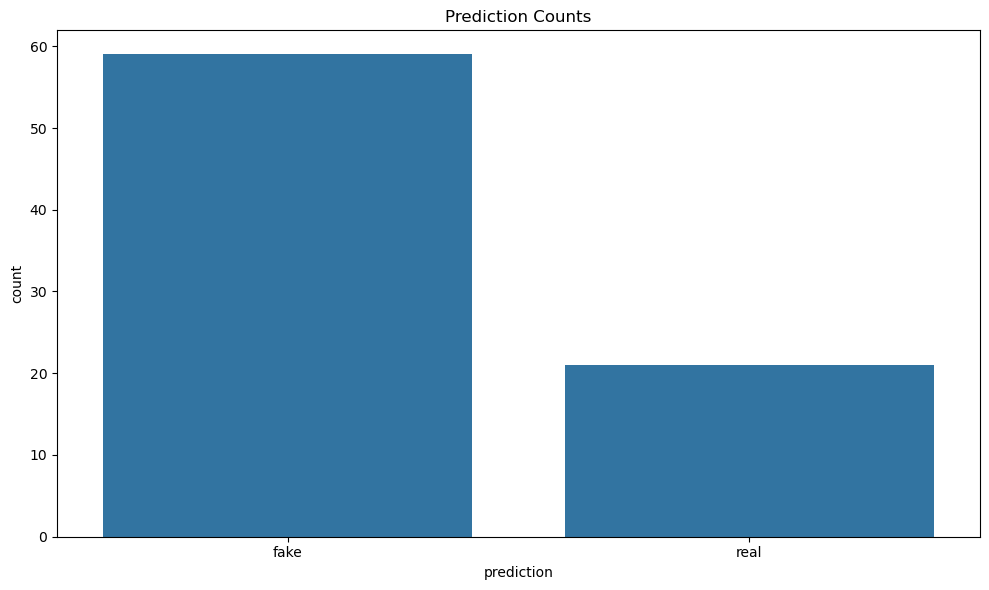

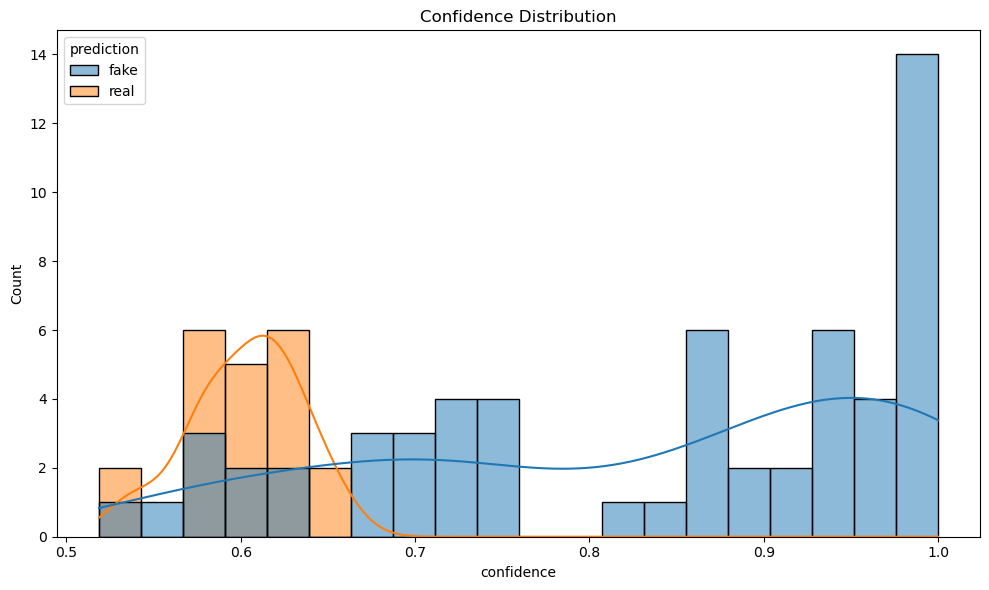

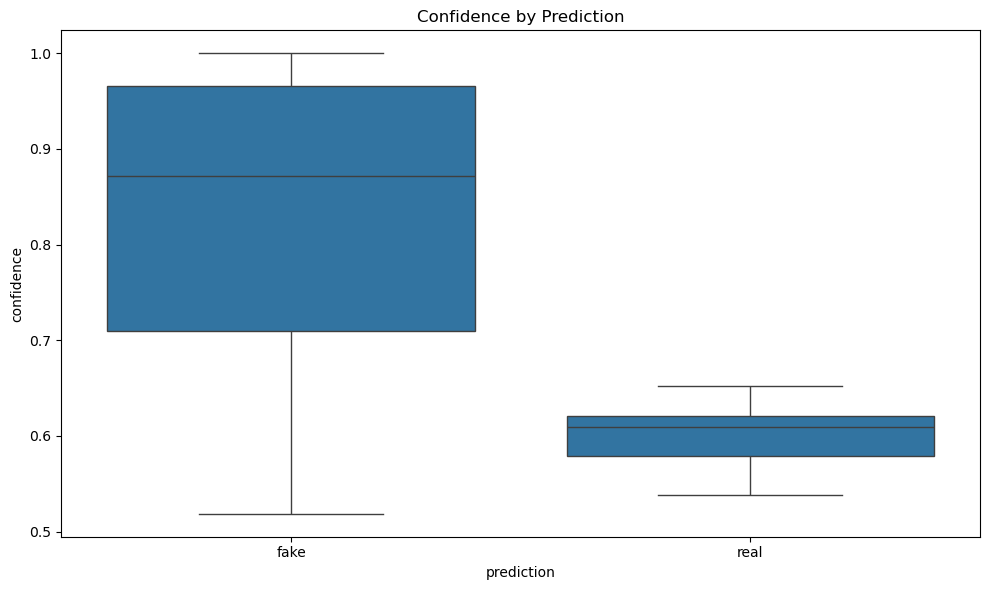

In [61]:
run_evaluation_pipeline(config, model = deep_model, model_type = 'deep_model')

Running prediction on evaluation videos...


Predicting: 100%|██████████| 80/80 [19:11<00:00, 14.40s/it]


Results saved to output/evaluations\vit_model\predictions.csv
Summary: 80 videos processed
Real: 2 (2.5%)
Fake: 78 (97.5%)
Generating result visualizations...
Evaluation pipeline complete.


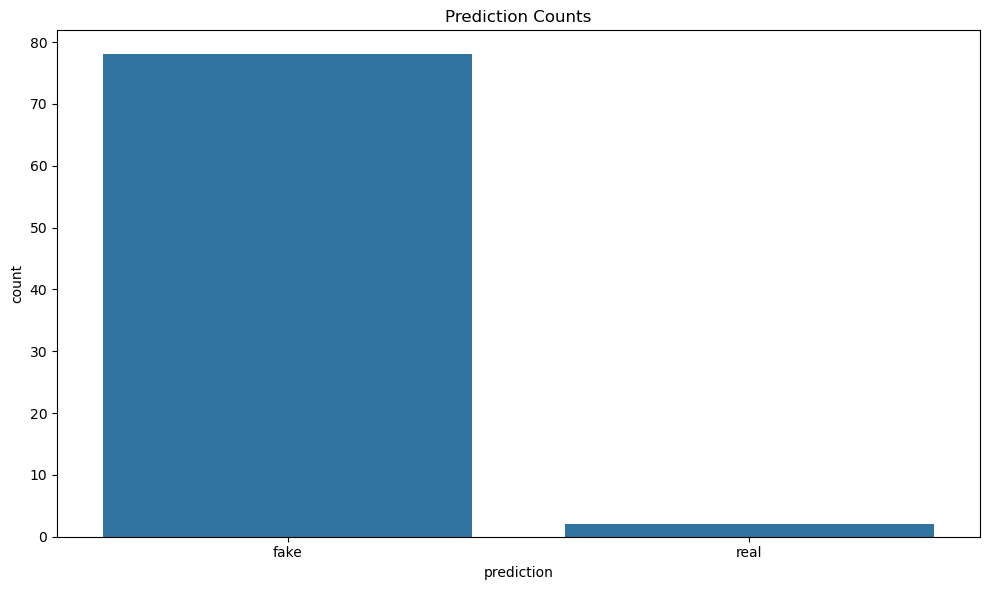

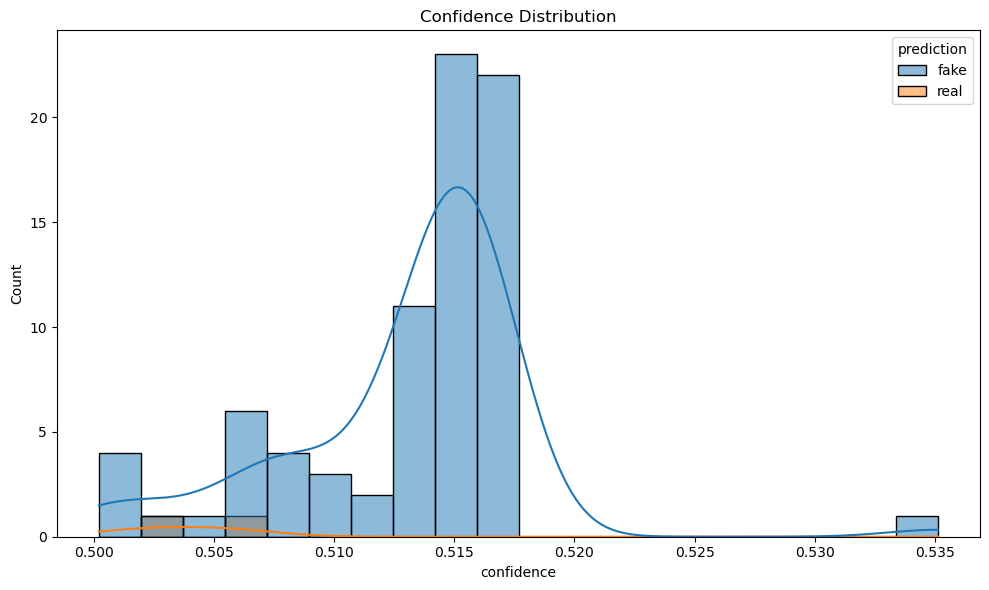

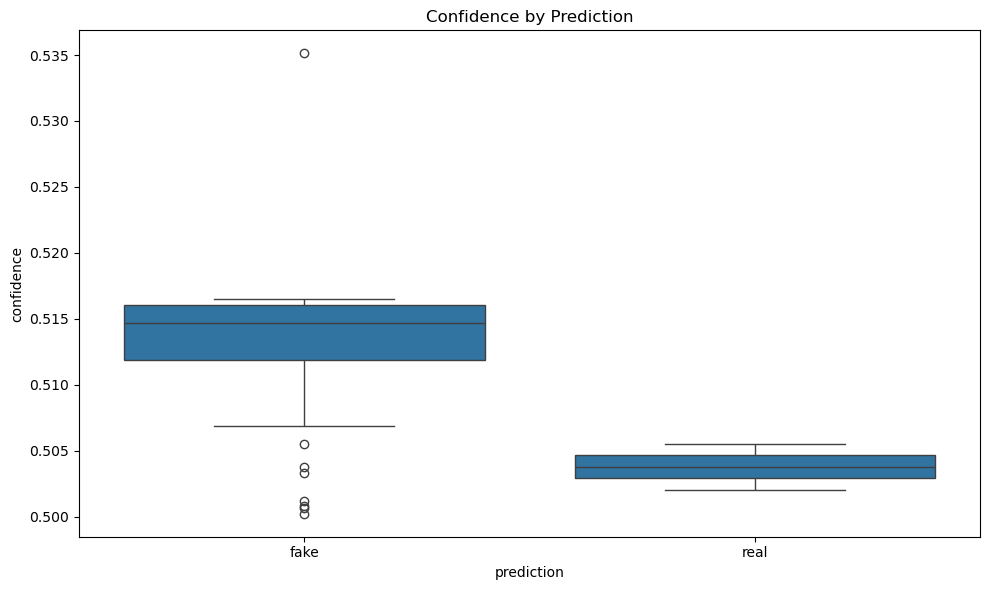

In [62]:
run_evaluation_pipeline(config, model = vit_model, model_type = 'vit_model')

Running prediction on evaluation videos...


Predicting: 100%|██████████| 80/80 [18:53<00:00, 14.17s/it]


Results saved to output/evaluations\fine_tuned_vit_model\predictions.csv
Summary: 80 videos processed
Real: 59 (73.8%)
Fake: 21 (26.2%)
Generating result visualizations...
Evaluation pipeline complete.


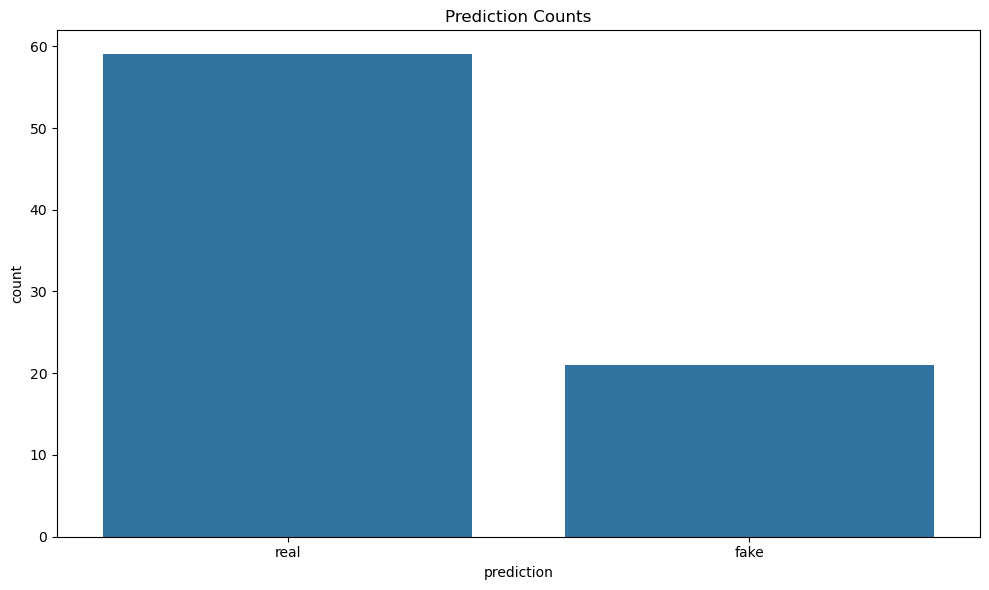

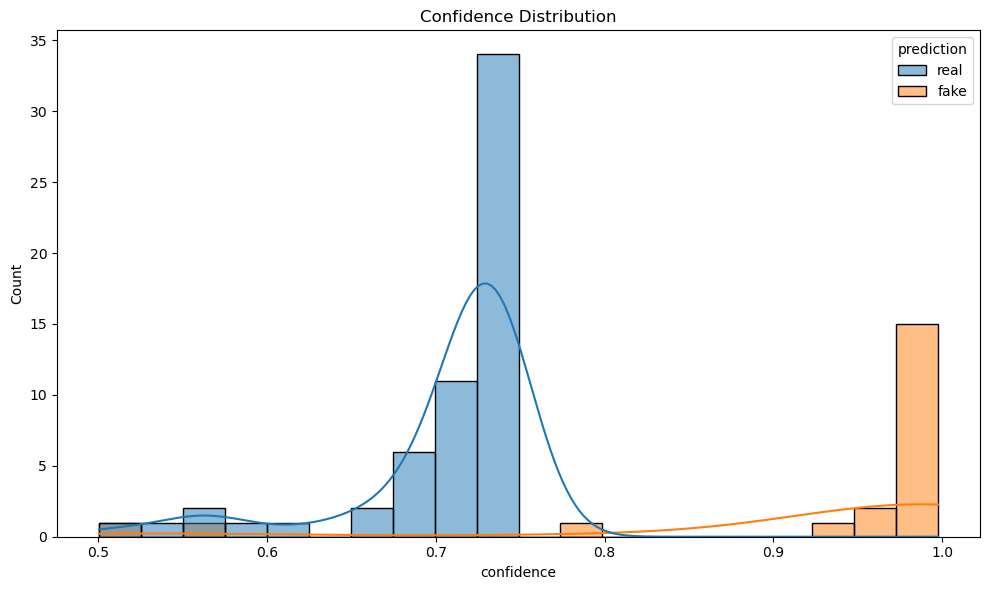

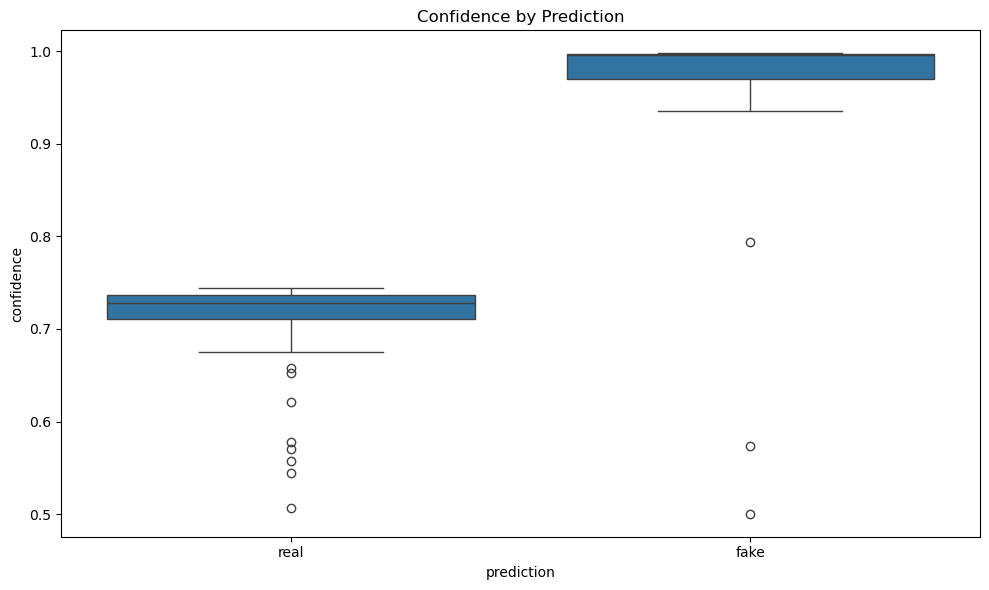

In [63]:
run_evaluation_pipeline(config, model = fine_tuned_vit_model, model_type = 'fine_tuned_vit_model')

In [64]:
import gradio as gr
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler
import os

model = vit_model
model.load_state_dict(torch.load('output/models/vit/best_model.pt', map_location='cpu'))
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

features_dir = os.path.join(config['output_dir'], 'features')
real_data = np.load(os.path.join(features_dir, '1_features.npz'))
fake_data = np.load(os.path.join(features_dir, '0_features.npz'))

real_features = real_data['features']
fake_features = fake_data['features']

X = np.vstack((real_features, fake_features))

scaler = StandardScaler()
scaler.fit(X)

def gradio_predict(video_file):
    try:
        features = process_video(
            video_file,
            sample_rate=config['sample_rate'],
            max_frames=config['max_frames'],
            resize_shape=(config['resize_width'], config['resize_height'])
        )
        if features is None:
            return "Error extracting features", 0.0

        feature_values = np.array(list(features.values())).reshape(1, -1)
        feature_values = scaler.transform(feature_values)

        feature_tensor = torch.tensor(feature_values, dtype=torch.float32).to(device)

        with torch.no_grad():
            outputs = model(feature_tensor)
            probs = torch.softmax(outputs, dim=1)
            pred_label = torch.argmax(probs, dim=1).item()
            confidence = probs[0, pred_label].item()

        pred_class = 'Real' if pred_label == 1 else 'Fake'
        return f"Prediction: {pred_class}", float(f"{confidence:.4f}")

    except Exception as e:
        return f"Error: {str(e)}", 0.0

interface = gr.Interface(
    fn=gradio_predict,
    inputs=gr.Video(label="Upload a video"),
    outputs=[gr.Textbox(label="Prediction"), gr.Number(label="Confidence")],
    title="Deepfake Video Detector",
    description="Upload a short video to check if it's Real or Fake."
)

interface.launch(share=False, debug=False, prevent_thread_lock=True)


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
